# Tests

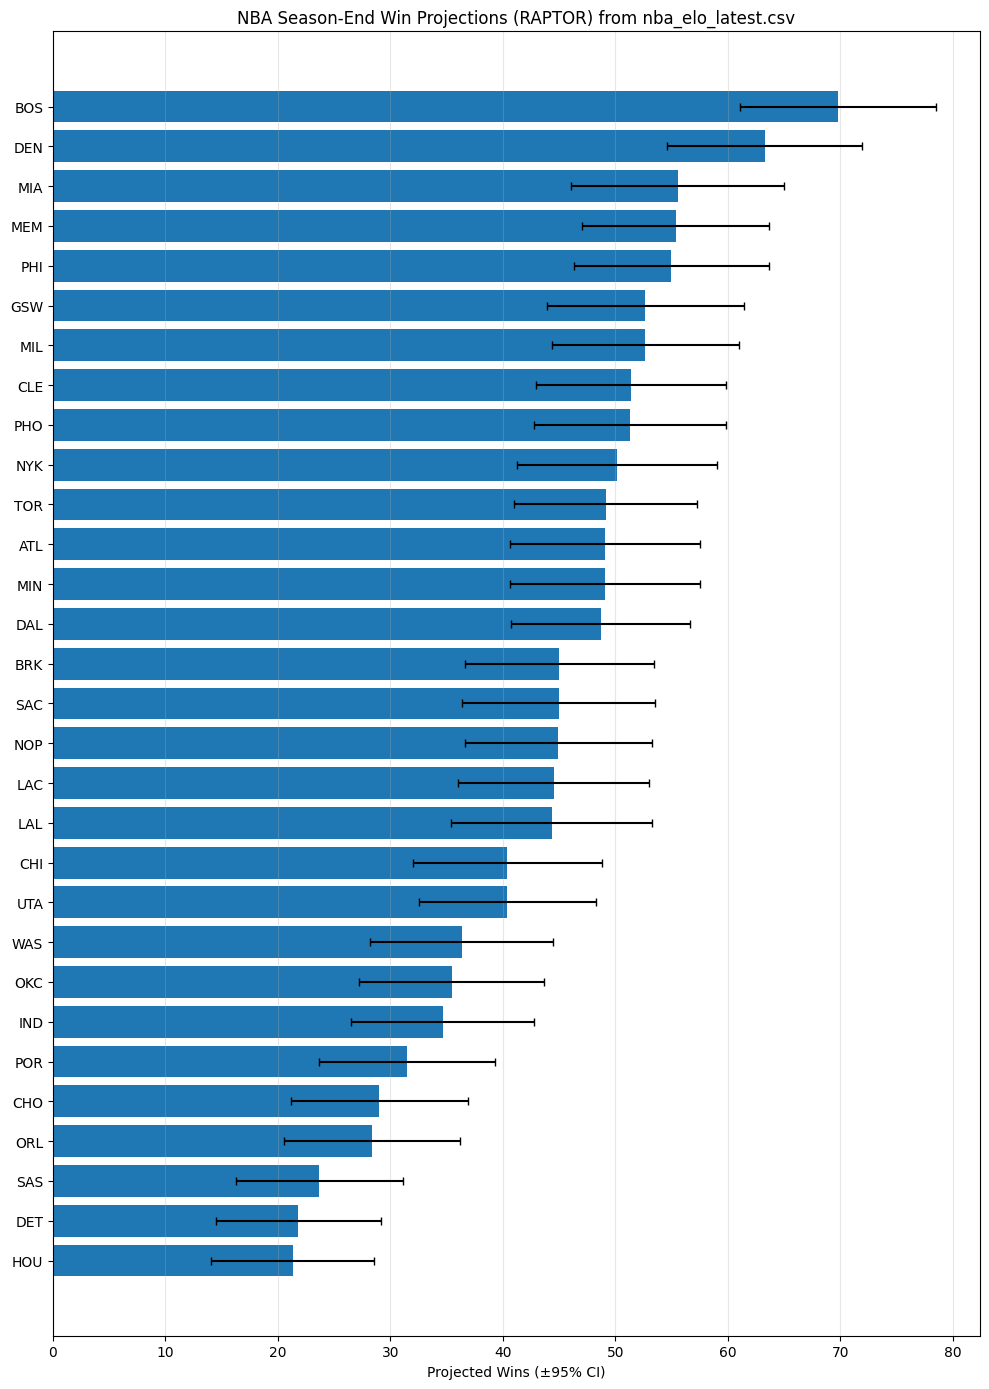

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the latest game‐by‐game predictions
df = pd.read_csv('nba_elo_latest.csv')

# 2. Build a long form table of (team, win_probability) for each game
#    Each row gives team1’s probability in raptor_prob1, and team2’s in raptor_prob2
team1 = df[['team1', 'raptor_prob1']].rename(columns={'team1':'team', 'raptor_prob1':'p'})
team2 = df[['team2', 'raptor_prob2']].rename(columns={'team2':'team', 'raptor_prob2':'p'})
probs = pd.concat([team1, team2], ignore_index=True)

# 3. For each team, compute:
#    • mean projected wins = sum of p’s
#    • variance      = sum of p*(1-p)
#    • SD            = sqrt(variance)
#    • 95% CI        ≈ mean ± 1.96*SD
stats = probs.groupby('team')['p'].agg([
    ('mean_wins', 'sum'),
    ('var_wins',   lambda x: np.sum(x*(1-x)))
]).reset_index()
stats['sd_wins'] = np.sqrt(stats['var_wins'])
stats['ci_lower'] = stats['mean_wins'] - 1.96*stats['sd_wins']
stats['ci_upper'] = stats['mean_wins'] + 1.96*stats['sd_wins']

# 4. Sort by mean projected wins for plotting
stats = stats.sort_values('mean_wins', ascending=False)

# 5. Plot a bar‐chart with error bars
plt.figure(figsize=(10, 14))
plt.barh(
    stats['team'],
    stats['mean_wins'],
    xerr=1.96*stats['sd_wins'],
    capsize=3
)
plt.gca().invert_yaxis()
plt.xlabel('Projected Wins (±95% CI)')
plt.title('NBA Season‐End Win Projections (RAPTOR) from nba_elo_latest.csv')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


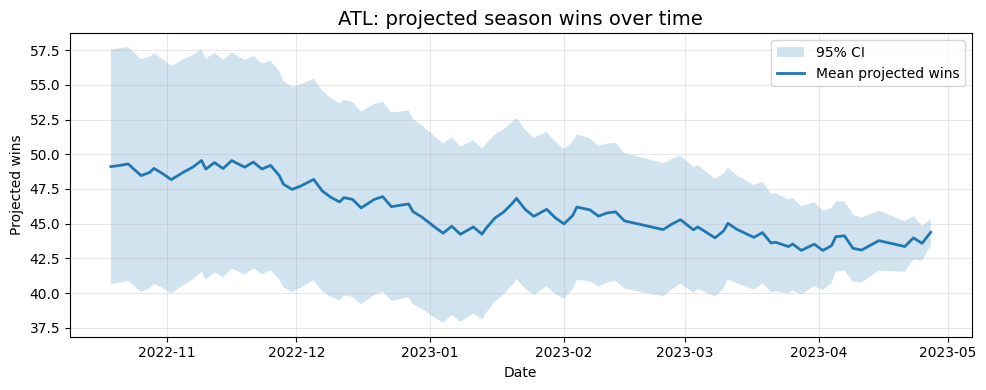

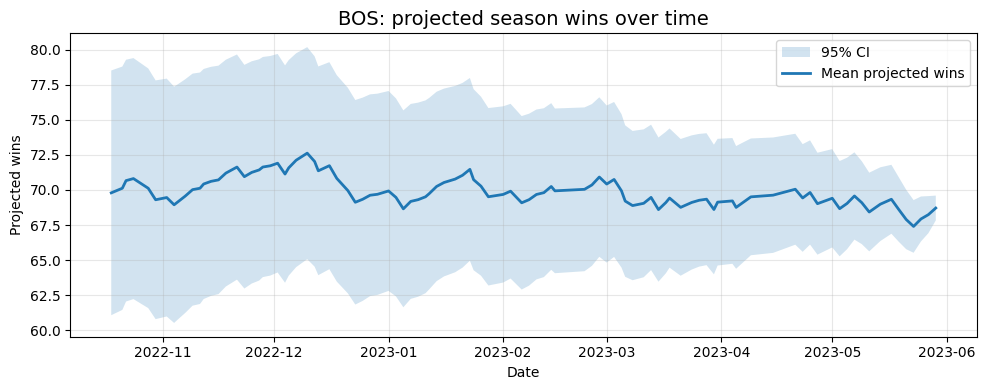

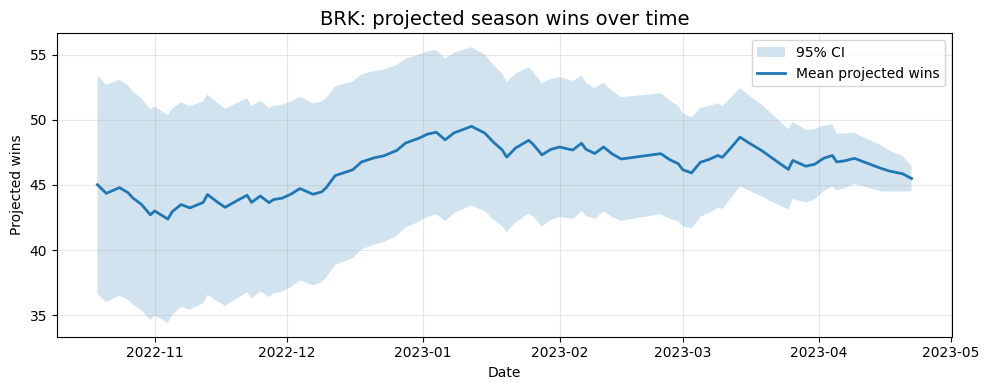

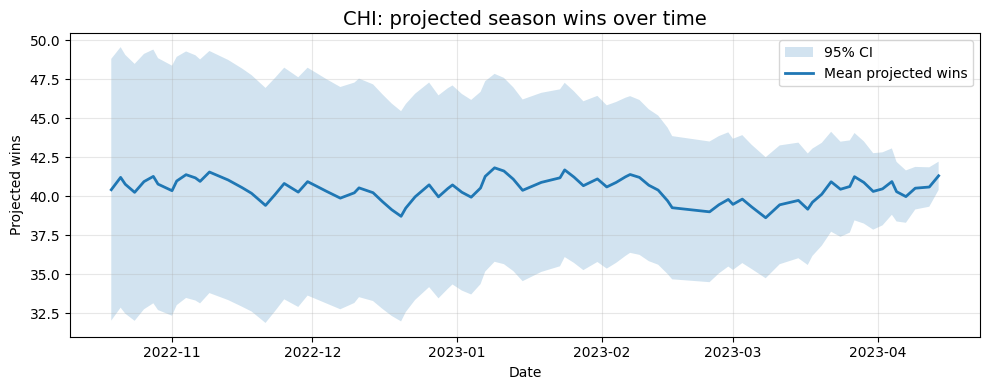

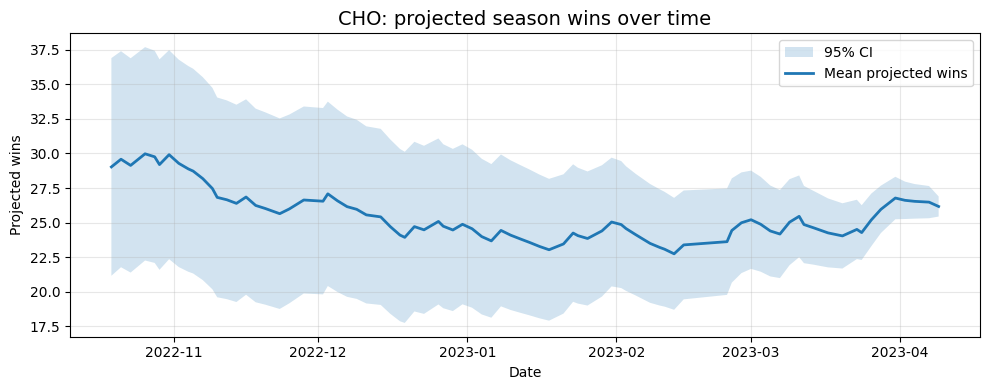

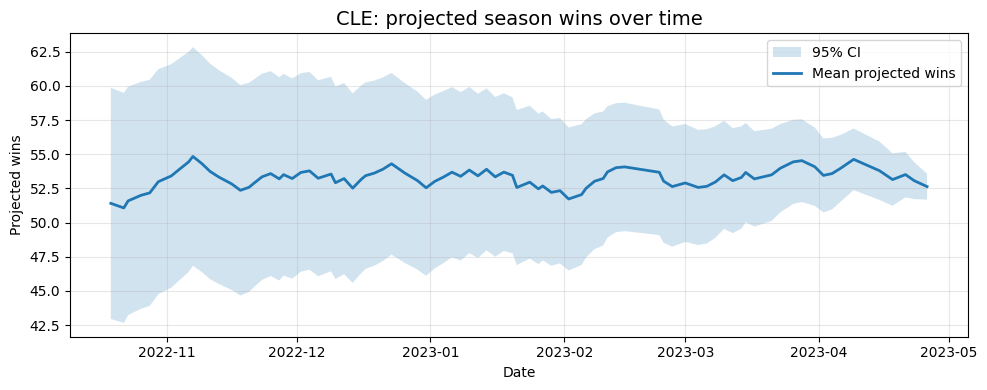

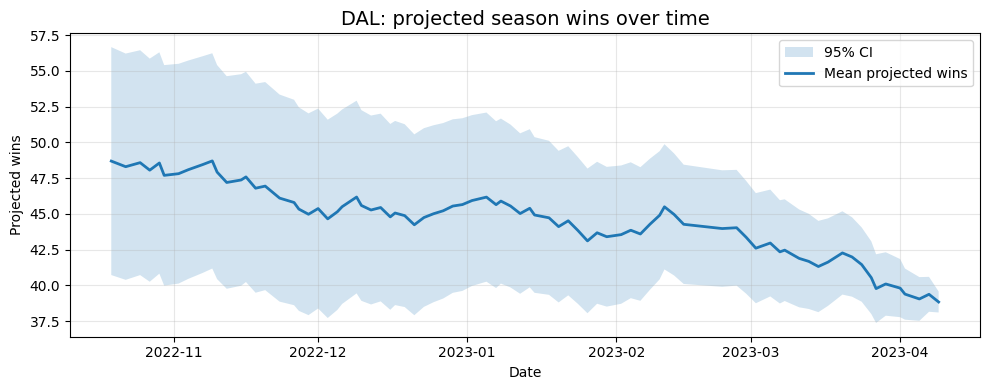

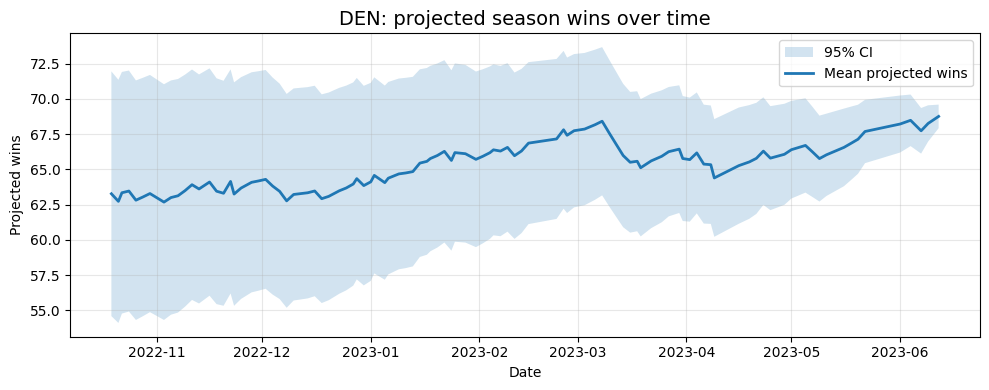

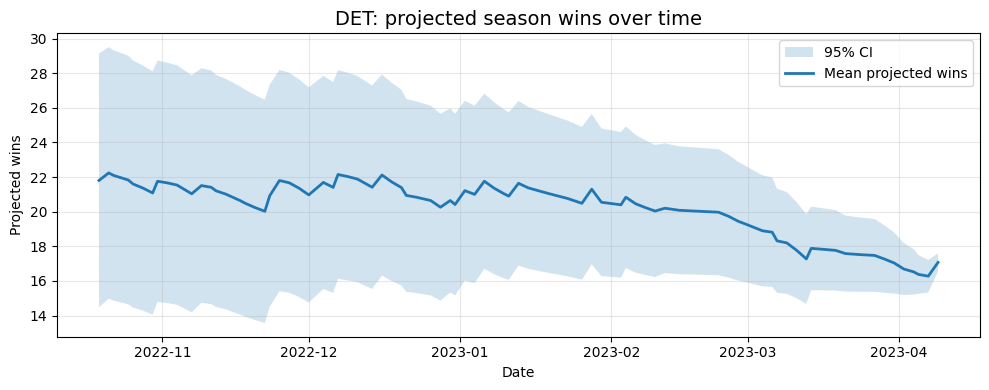

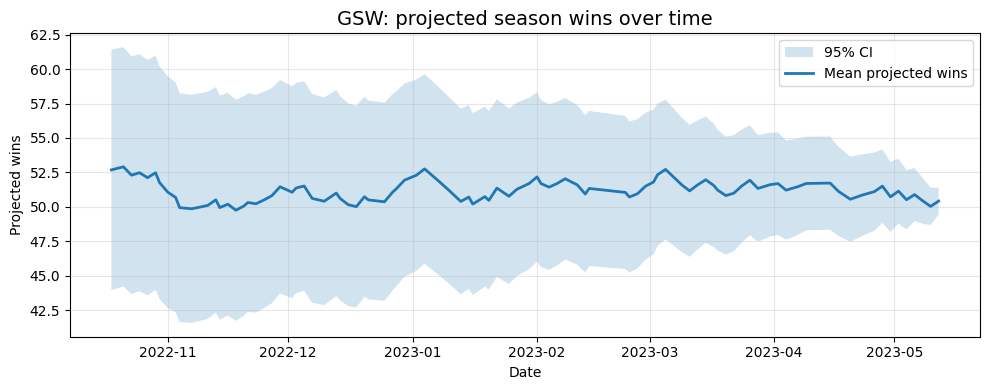

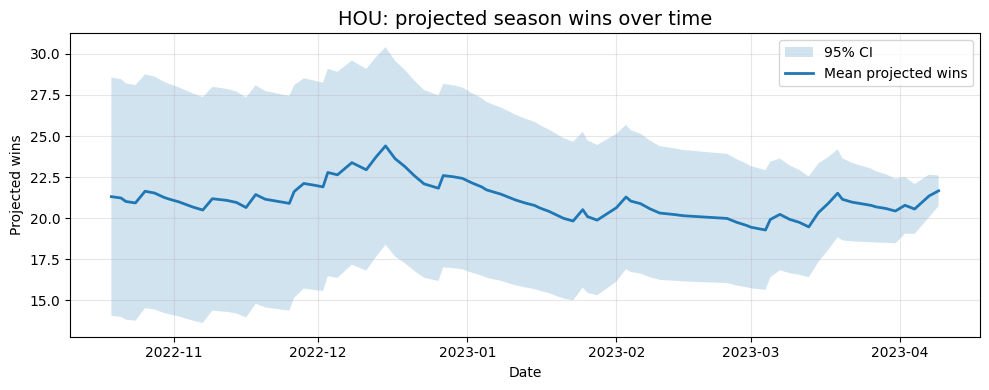

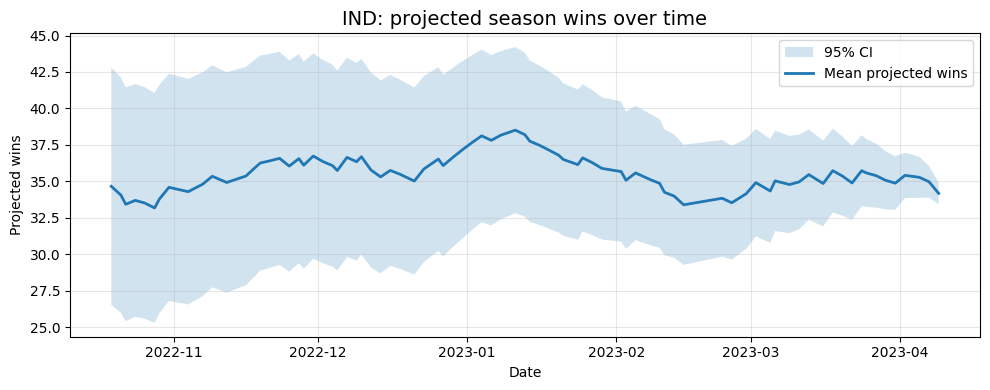

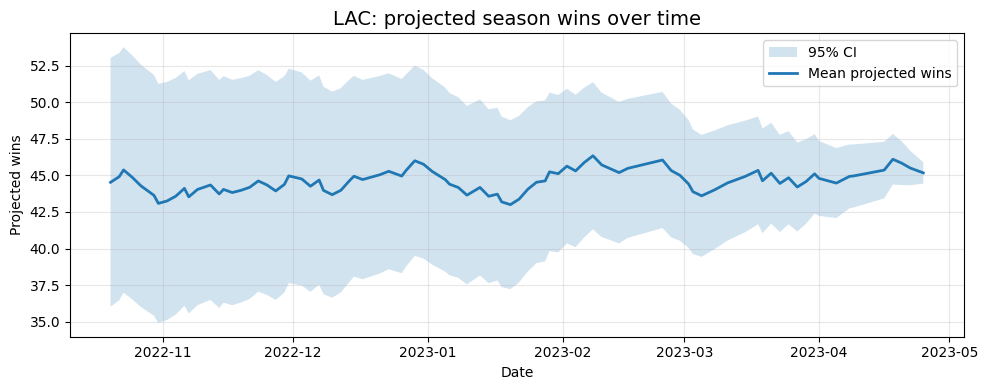

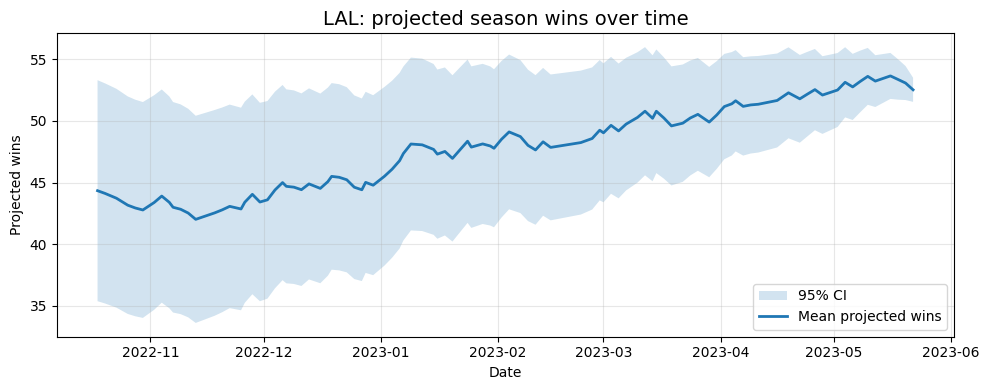

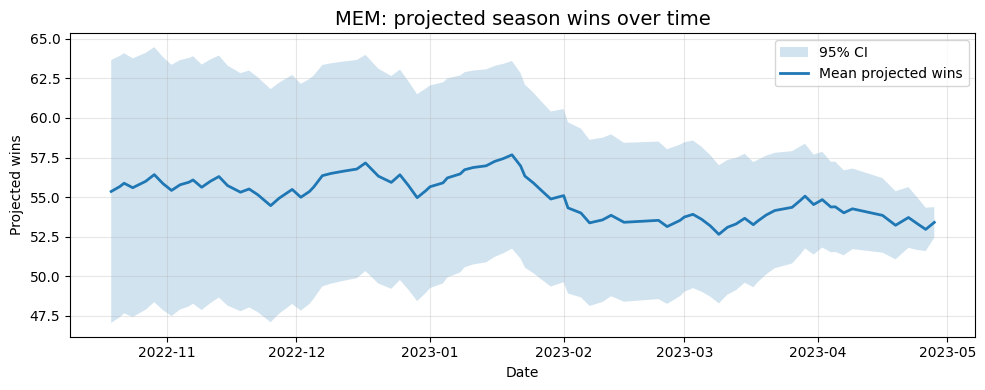

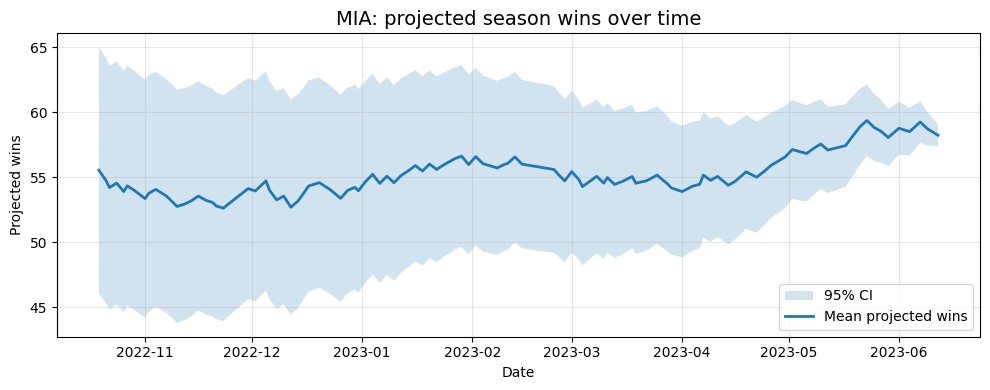

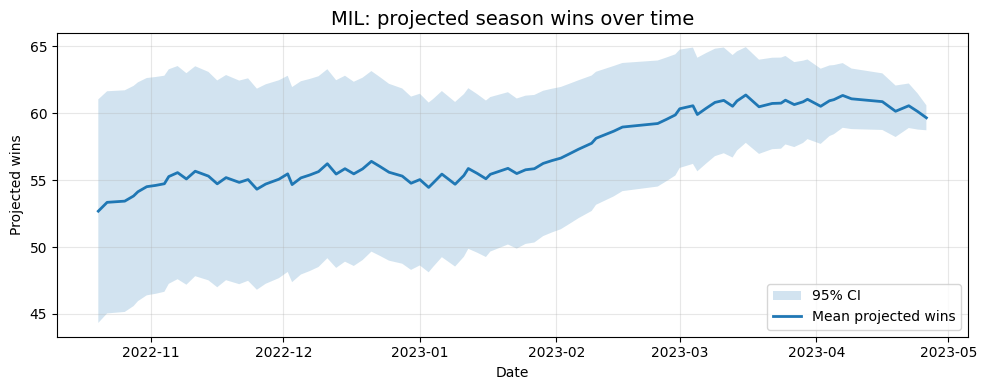

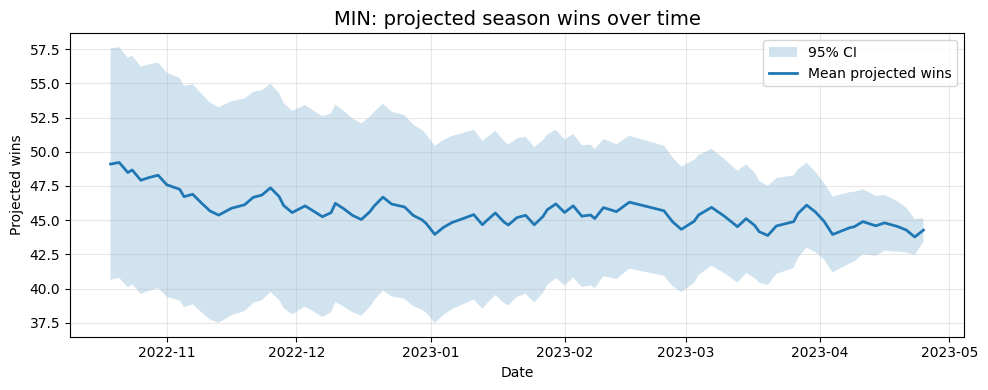

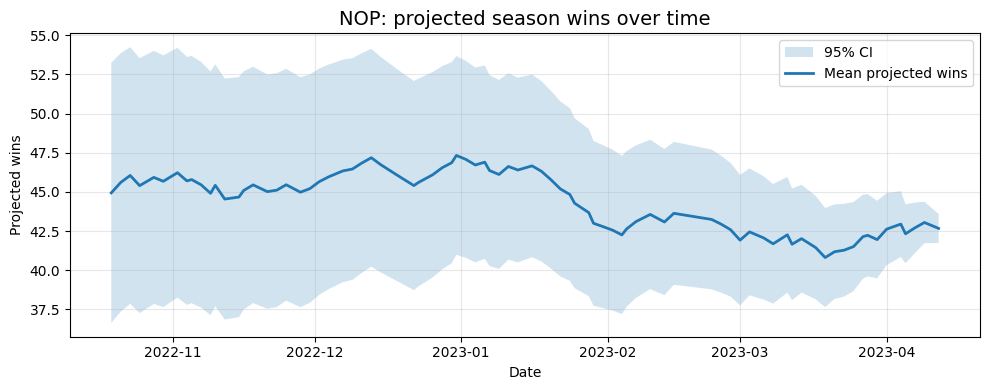

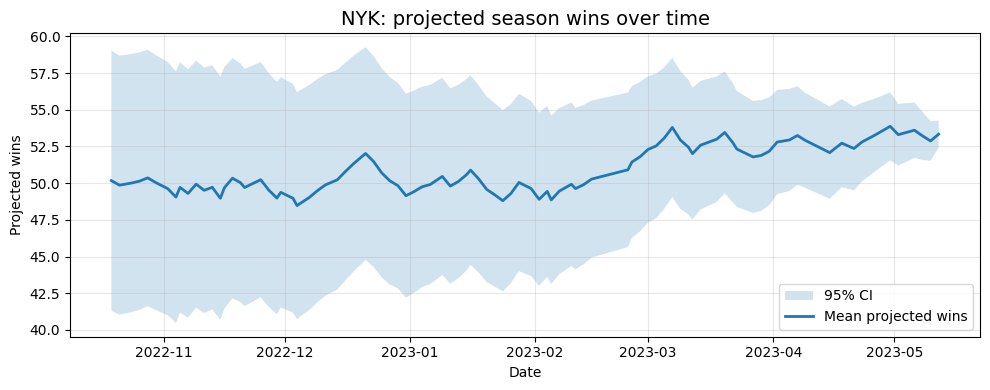

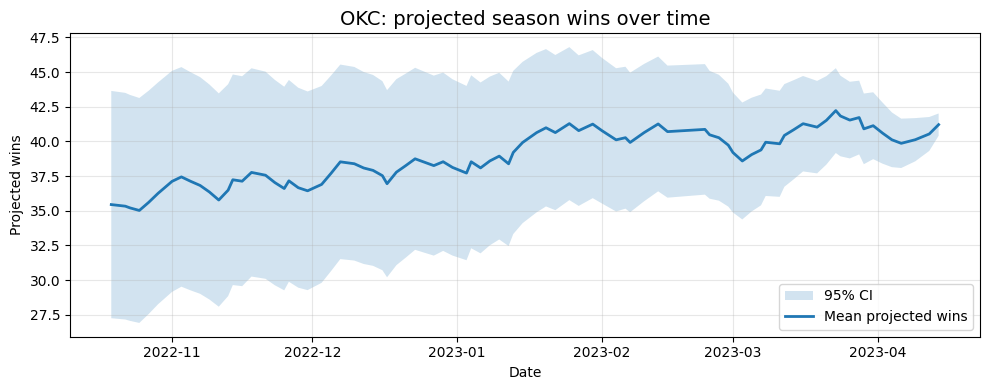

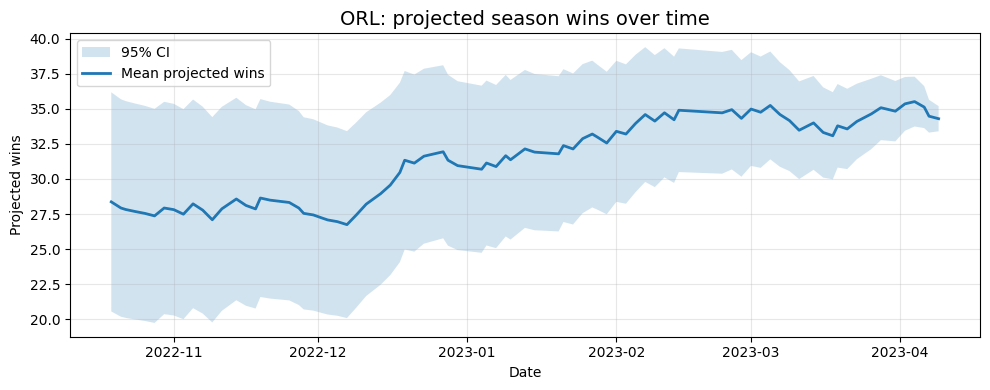

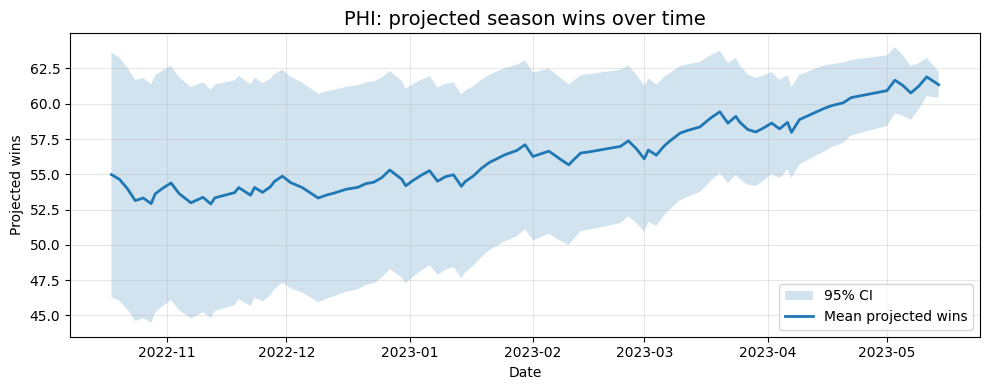

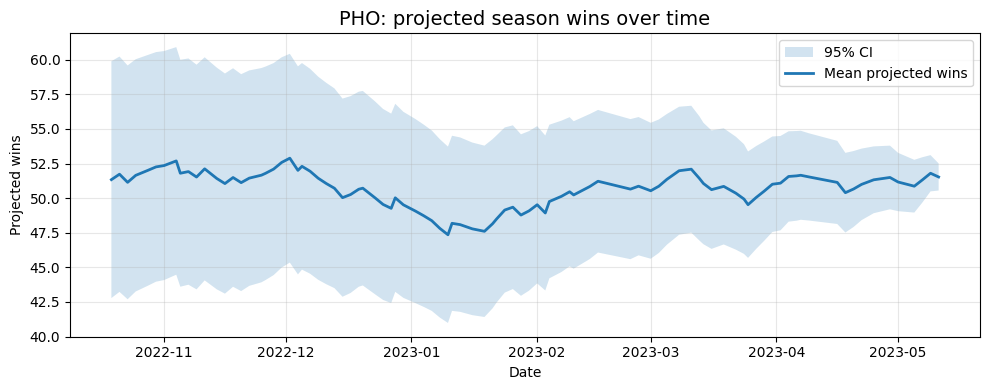

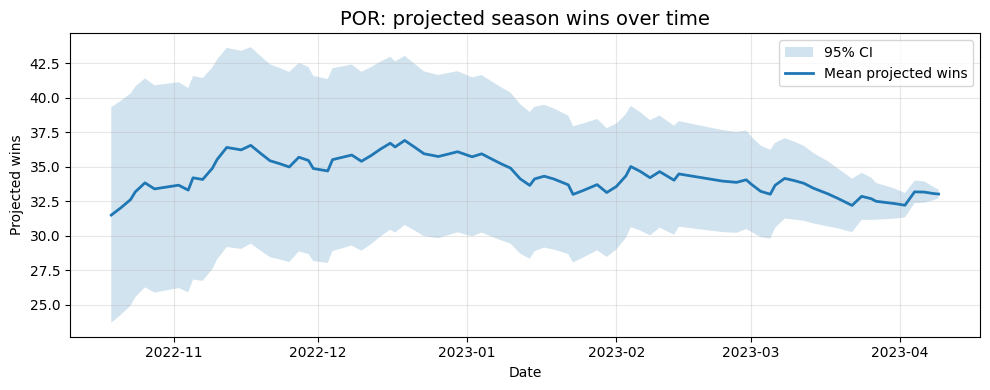

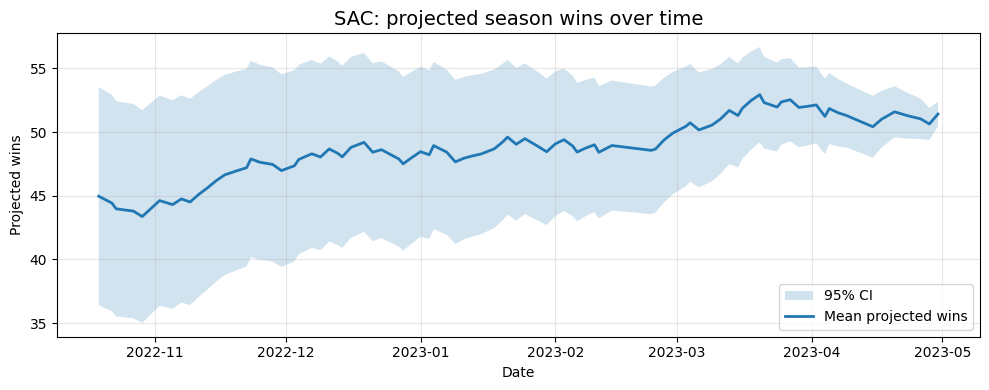

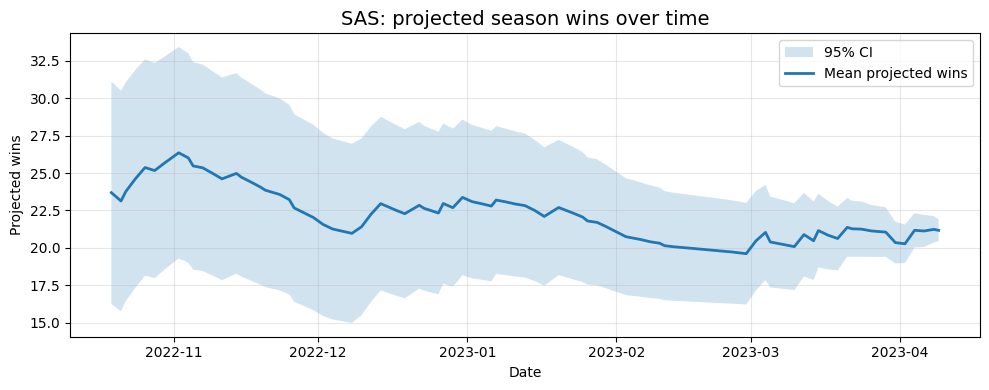

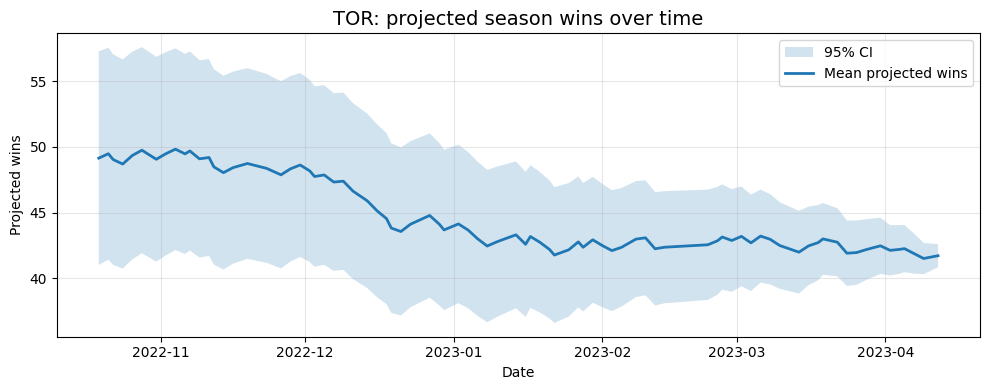

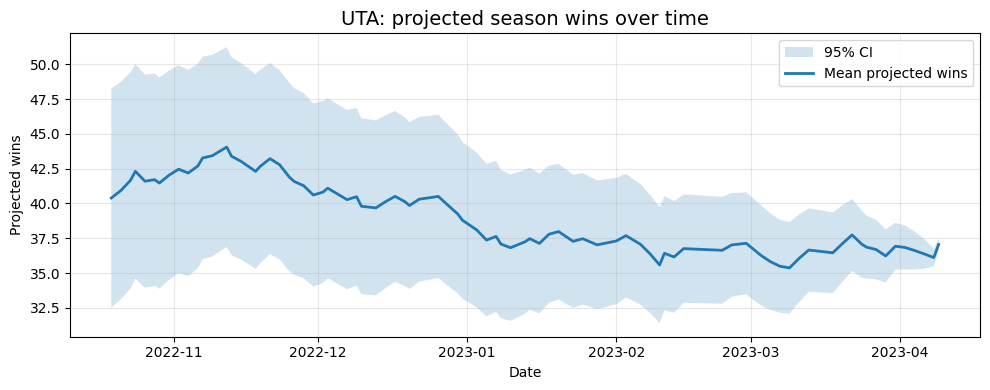

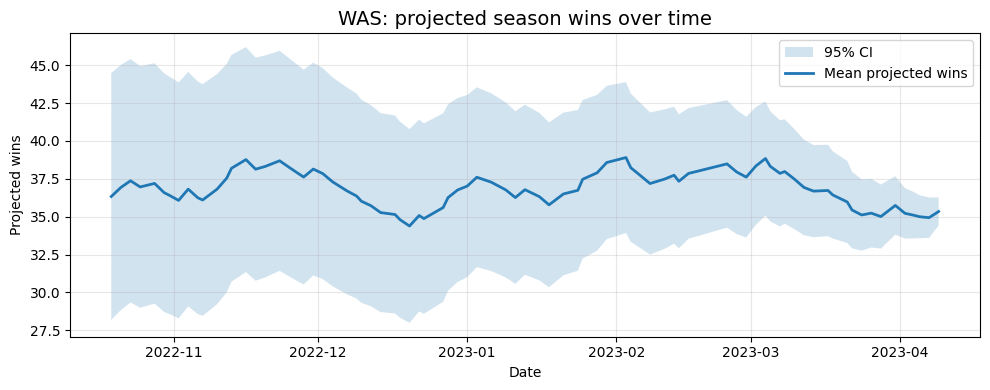

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the game-by-game RAPTOR predictions
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])

# 2. Flatten into one row per (team, game)
records = []
for _, row in df.iterrows():
    # team1
    records.append({
        'team':   row['team1'],
        'date':   row['date'],
        'prob':   row['raptor_prob1'],
        'actual': int(row['score1'] > row['score2'])
    })
    # team2
    records.append({
        'team':   row['team2'],
        'date':   row['date'],
        'prob':   row['raptor_prob2'],
        'actual': int(row['score2'] > row['score1'])
    })

flat = pd.DataFrame(records)

# 3. Function to build a timeseries of projected wins for a given team
def build_ts(team):
    g = flat[flat['team']==team].sort_values('date')
    dates = g['date'].unique()
    rows = []
    for d in dates:
        past   = g[g['date'] < d]
        future = g[g['date'] >= d]
        actual_wins = past['actual'].sum()
        exp_wins    = future['prob'].sum()
        var_future  = (future['prob'] * (1 - future['prob'])).sum()
        sd_future   = np.sqrt(var_future)
        mean_total  = actual_wins + exp_wins
        rows.append({
            'date':  d,
            'mean':  mean_total,
            'lower': mean_total - 1.96*sd_future,
            'upper': mean_total + 1.96*sd_future
        })
    return pd.DataFrame(rows)

# 4. Plot one chart per team
teams = sorted(flat['team'].unique())
for team in teams:
    ts = build_ts(team)
    plt.figure(figsize=(10,4))
    plt.fill_between(ts['date'], ts['lower'], ts['upper'], alpha=0.2,
                     label='95% CI')
    plt.plot(ts['date'], ts['mean'], lw=2, label='Mean projected wins')
    plt.title(f'{team}: projected season wins over time', fontsize=14)
    plt.xlabel('Date'); plt.ylabel('Projected wins')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()


# Stats

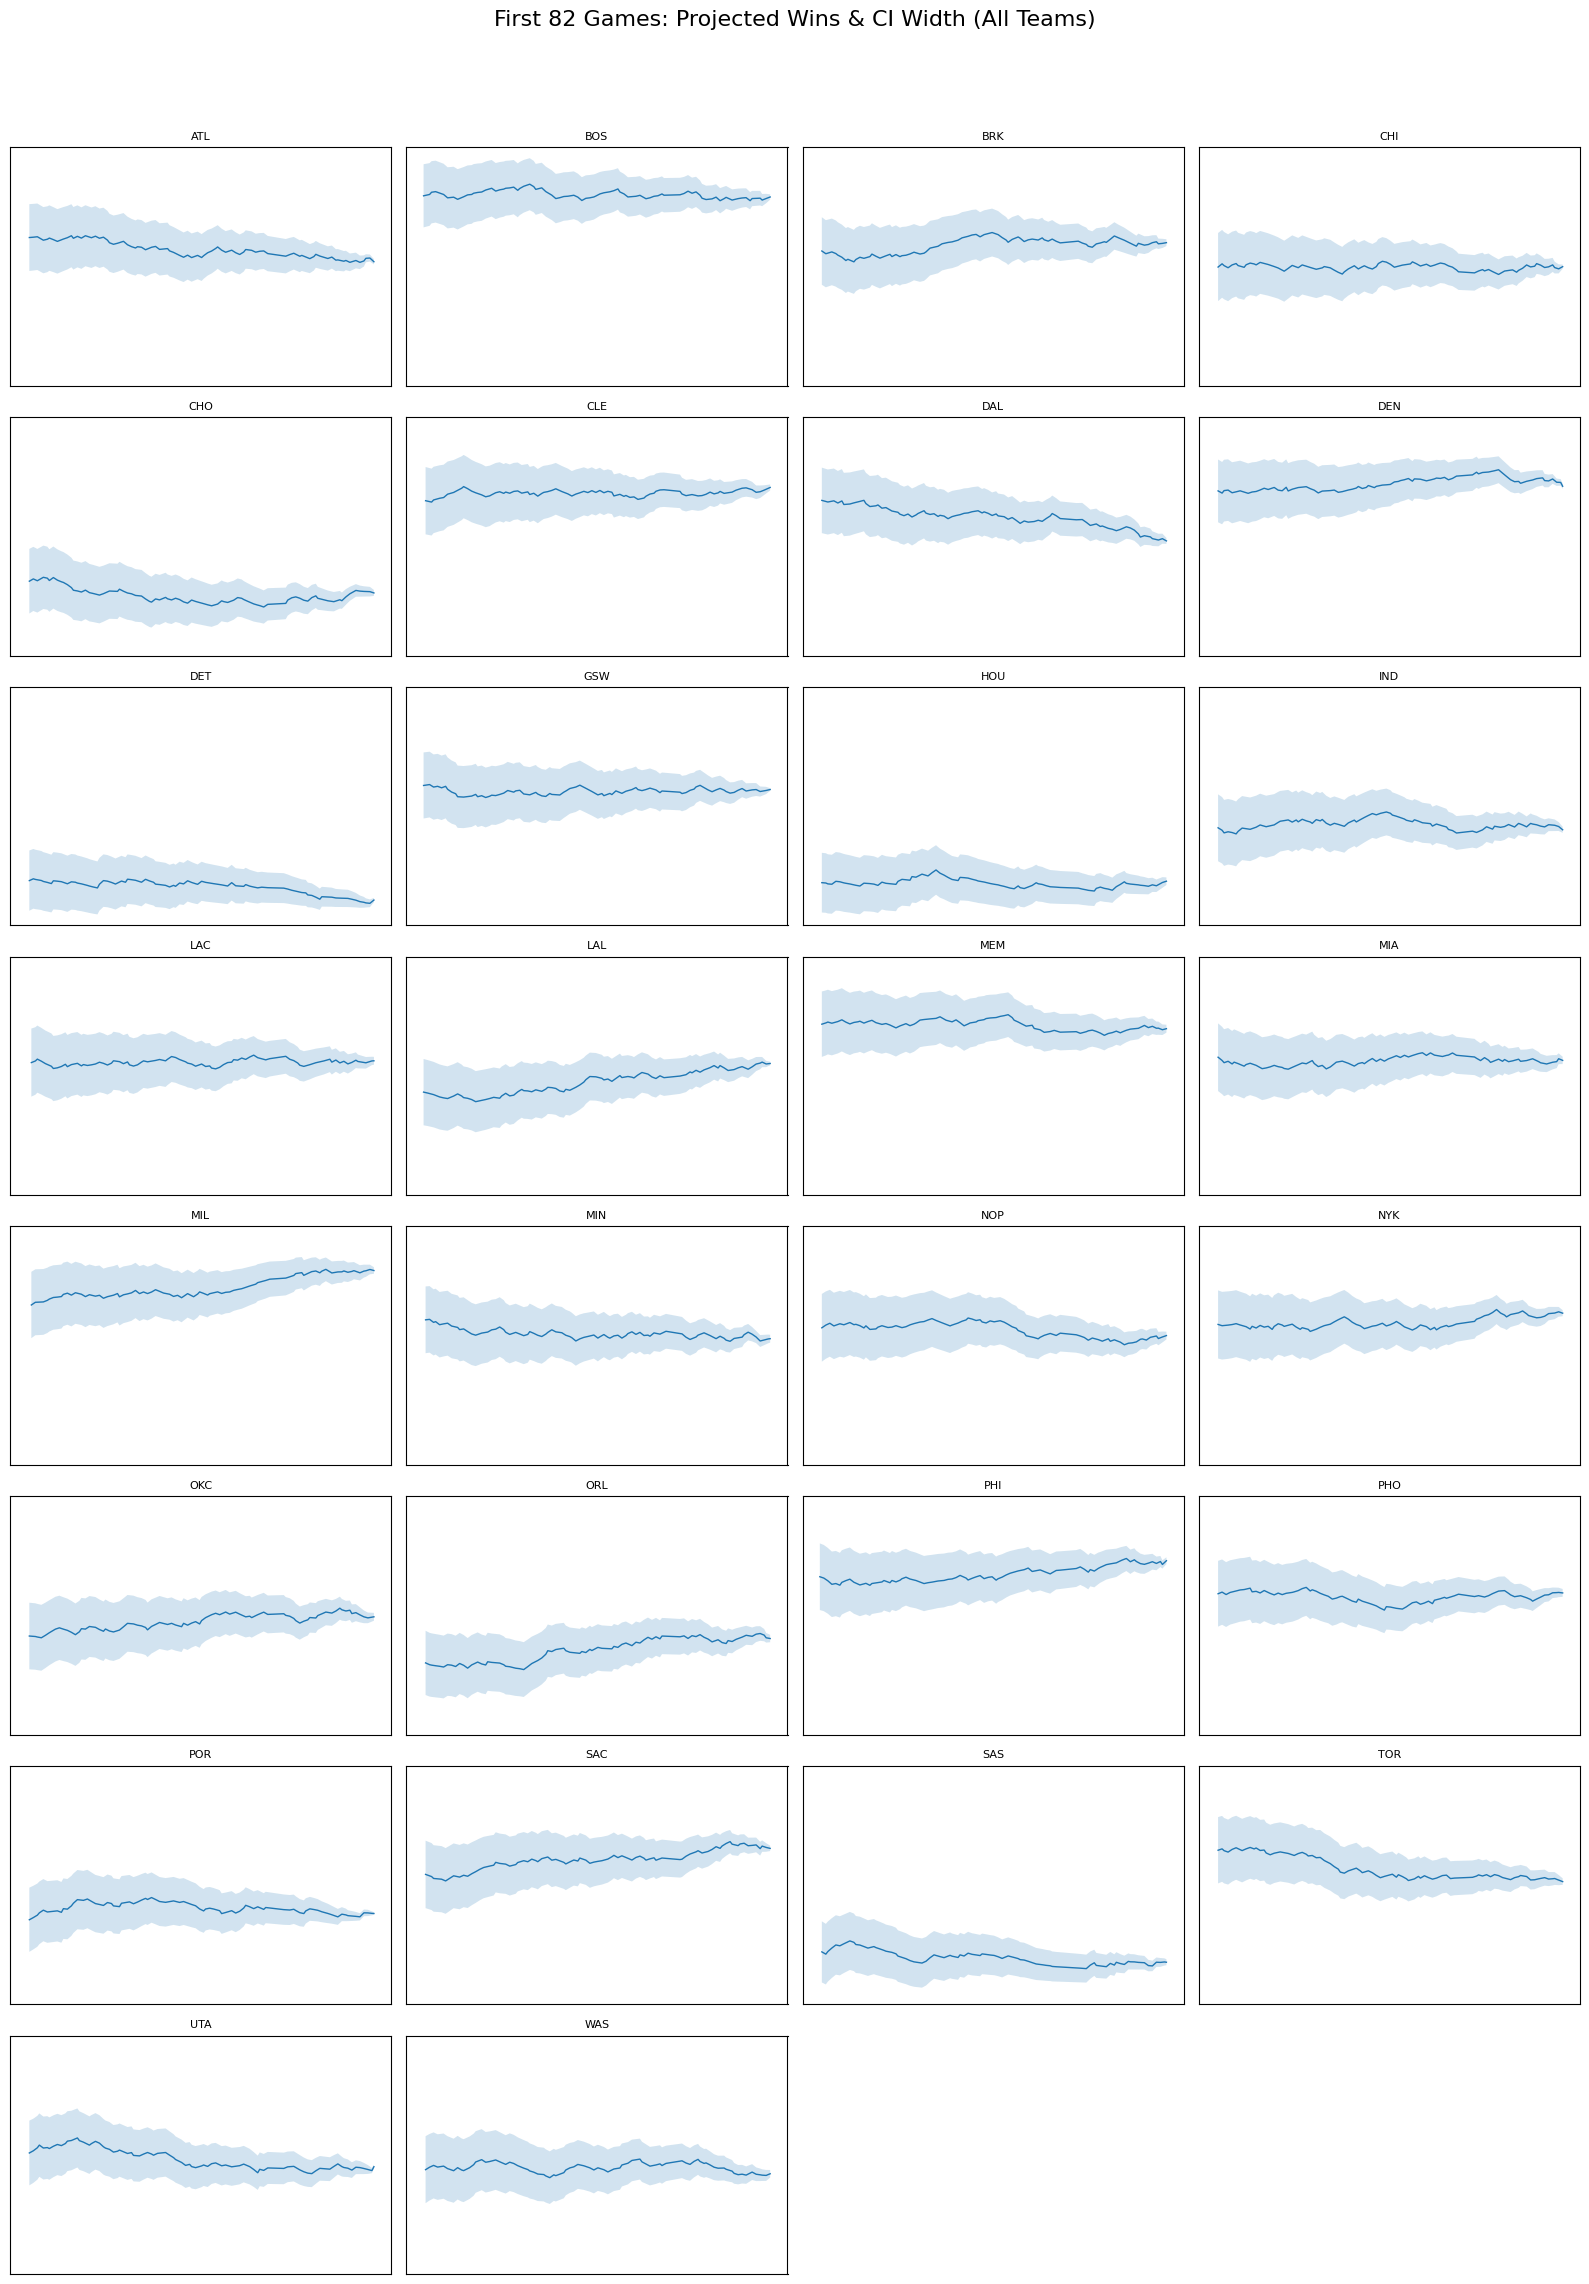

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load & flatten (all games)
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])
records = []
for _, row in df.iterrows():
    records.append({'team': row['team1'], 'date': row['date'],
                    'prob': row['raptor_prob1'],
                    'actual': int(row['score1'] > row['score2'])})
    records.append({'team': row['team2'], 'date': row['date'],
                    'prob': row['raptor_prob2'],
                    'actual': int(row['score2'] > row['score1'])})
flat = pd.DataFrame(records)

# 2. Build a timeseries of projected wins + CI width for the first 82 games
def build_ts_first82(team):
    g = flat[flat['team'] == team].sort_values('date')
    g = g.iloc[:82]  # keep only regular-season (first 82 games)
    rows = []
    for d in sorted(g['date'].unique()):
        past = g[g['date'] < d]
        future = g[g['date'] >= d]
        actual_wins = past['actual'].sum()
        exp_wins    = future['prob'].sum()
        var_future  = (future['prob'] * (1 - future['prob'])).sum()
        sd_future   = np.sqrt(var_future)
        mean_total  = actual_wins + exp_wins
        lower = mean_total - 1.96 * sd_future
        upper = mean_total + 1.96 * sd_future
        ci_width = upper - lower
        rows.append({
            'date':     d,
            'mean':     mean_total,
            'lower':    lower,
            'upper':    upper,
            'ci_width': ci_width
        })
    return pd.DataFrame(rows)

# 3. Plot each team's regular-season projection in a grid
teams = sorted(flat['team'].unique())
cols = 4
rows = int(np.ceil(len(teams) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, team in zip(axes, teams):
    ts = build_ts_first82(team)
    ax.fill_between(ts['date'], ts['lower'], ts['upper'], alpha=0.2)
    ax.plot(ts['date'], ts['mean'], lw=1)
    ax.set_title(team, fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

# turn off unused subplots
for ax in axes[len(teams):]:
    ax.axis('off')

fig.suptitle('First 82 Games: Projected Wins & CI Width (All Teams)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


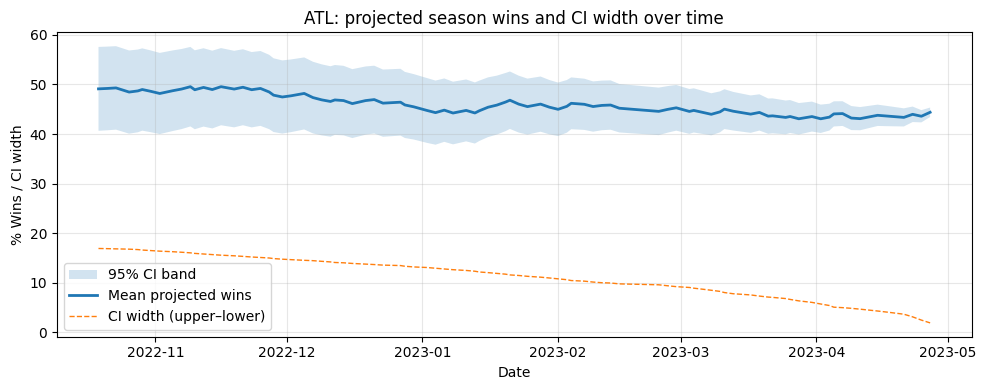

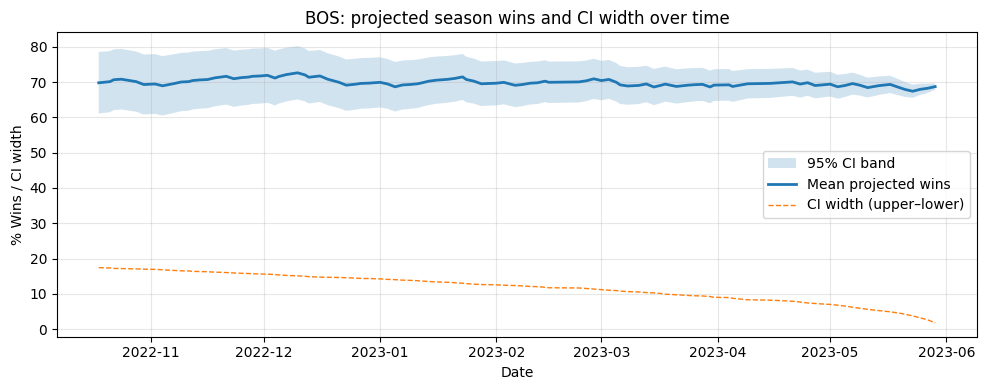

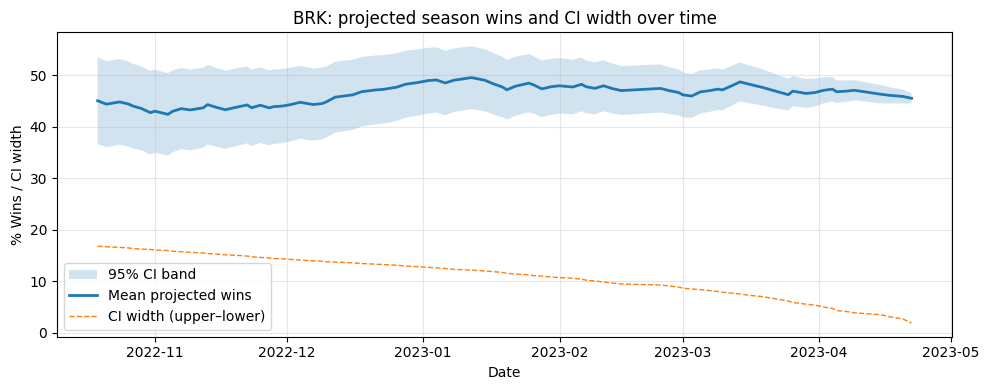

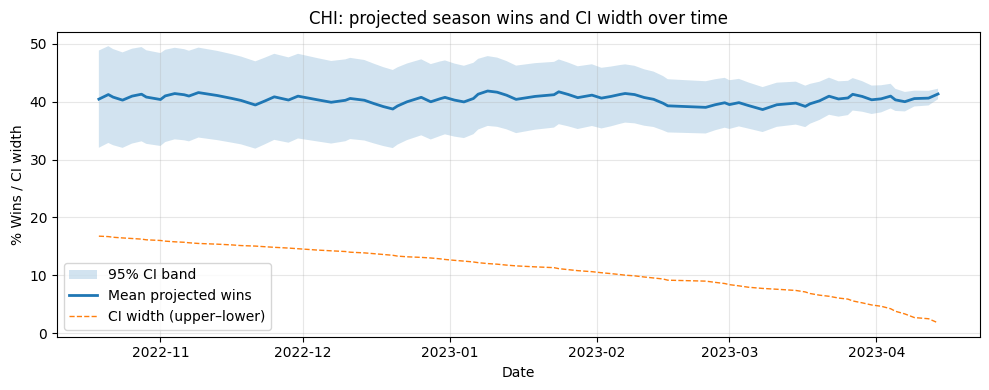

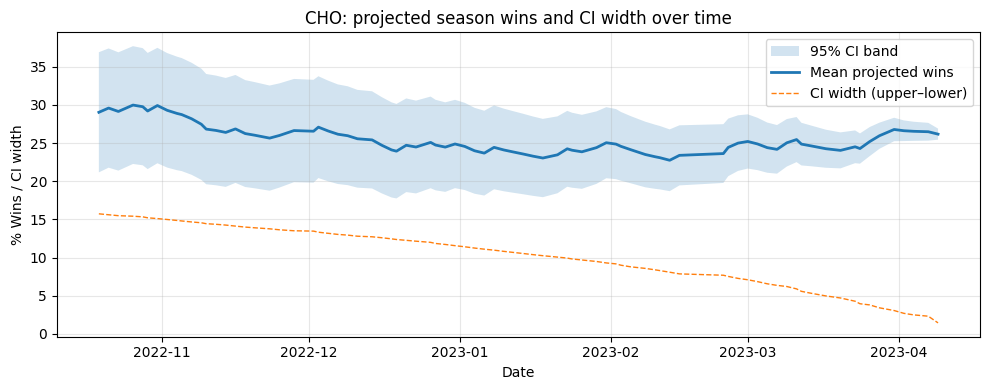

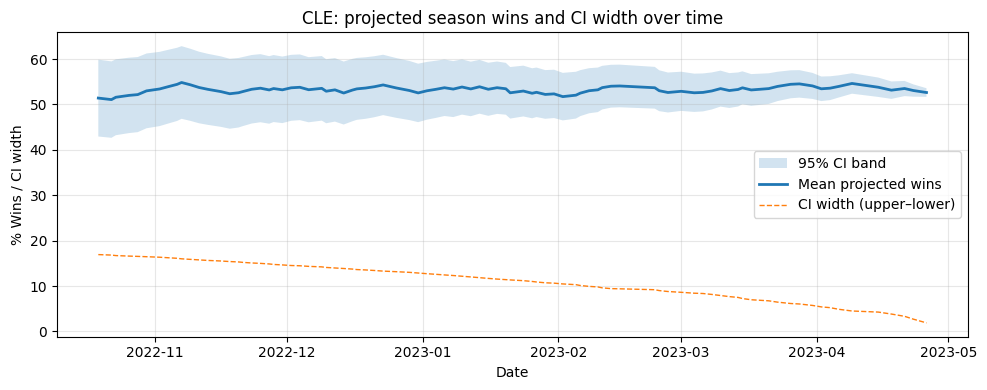

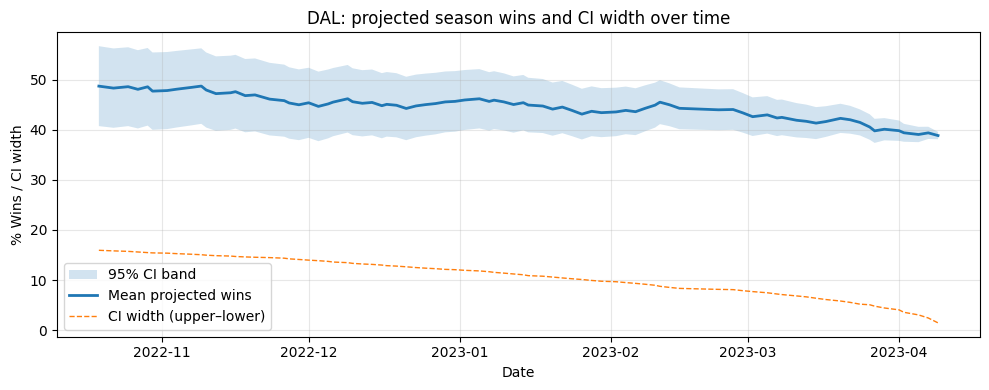

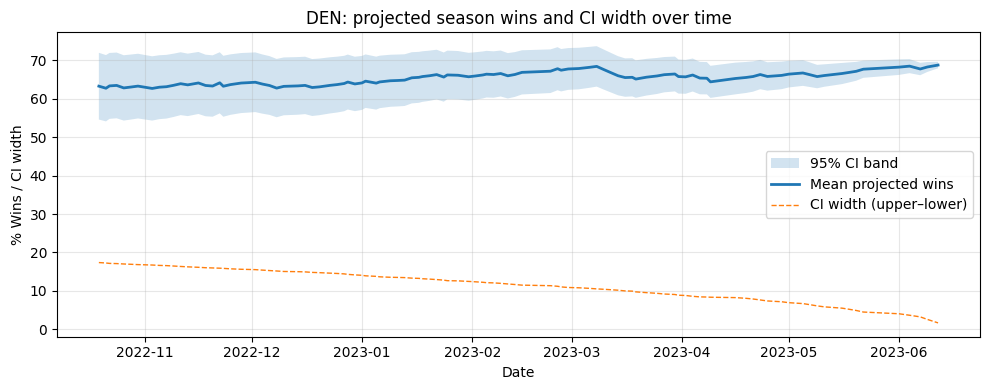

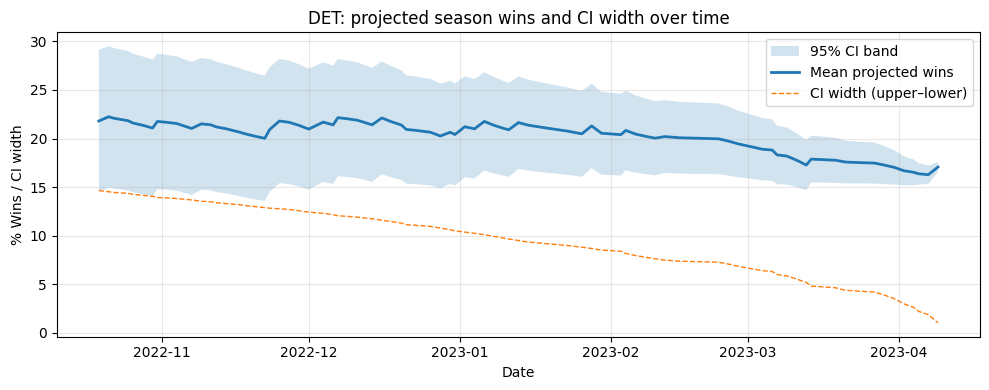

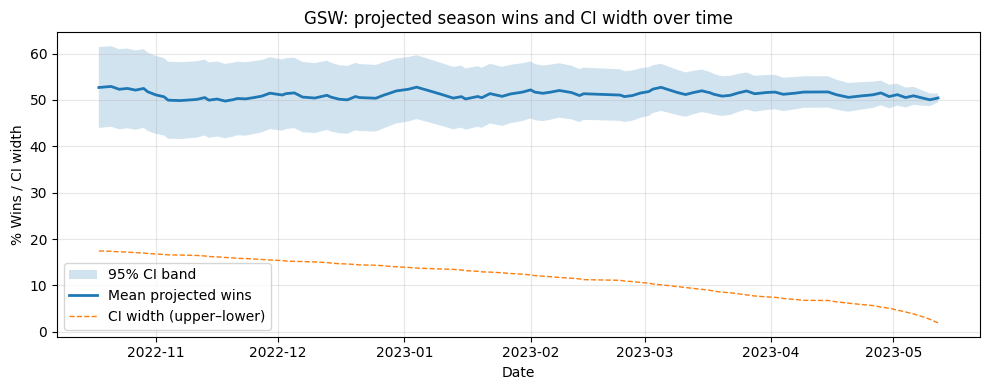

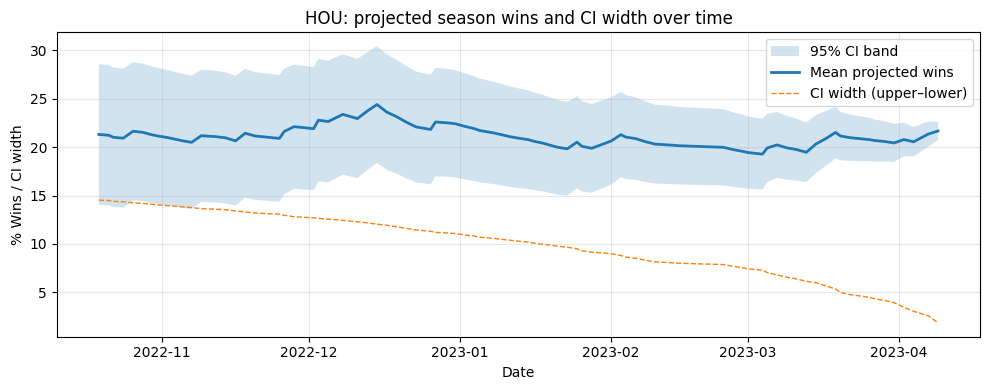

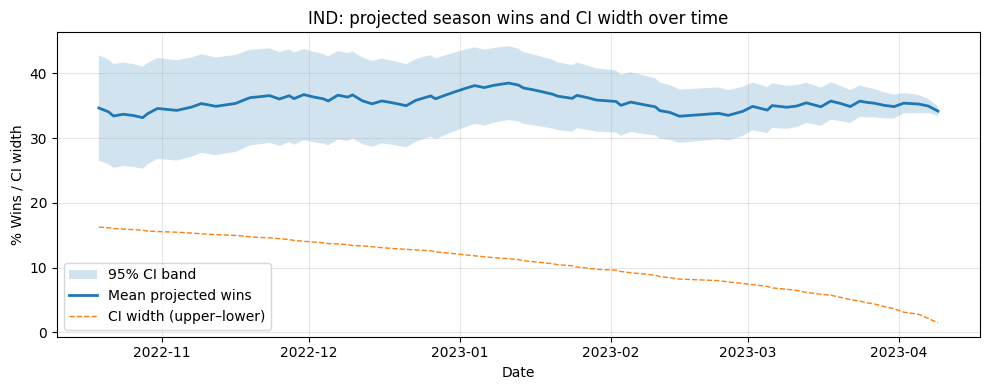

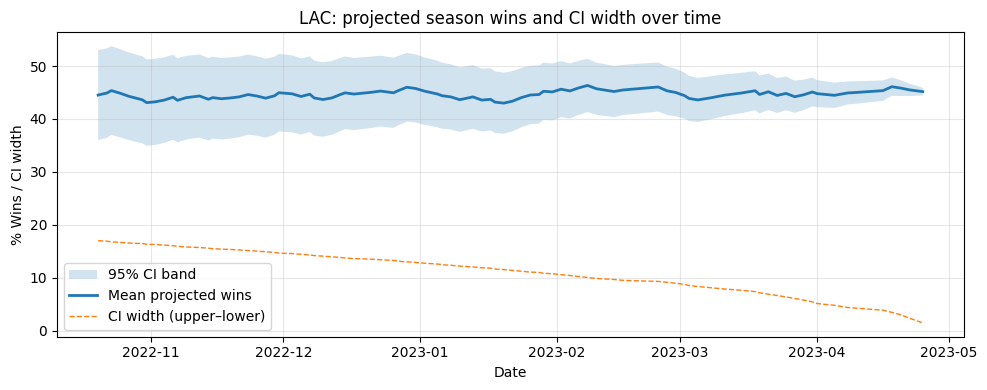

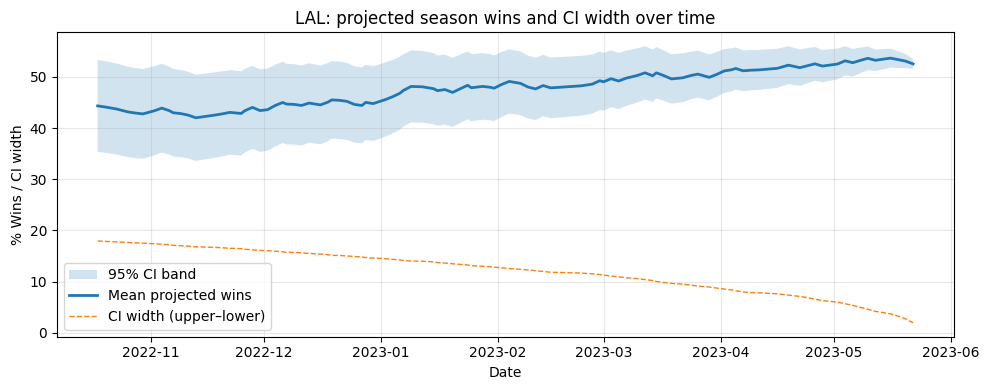

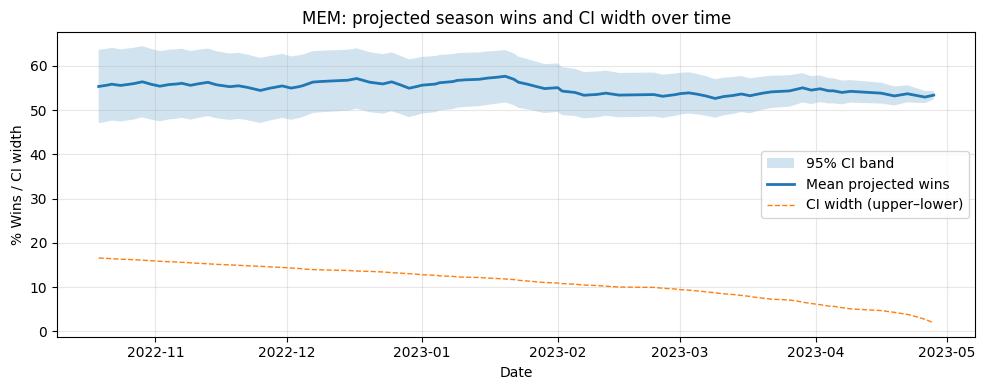

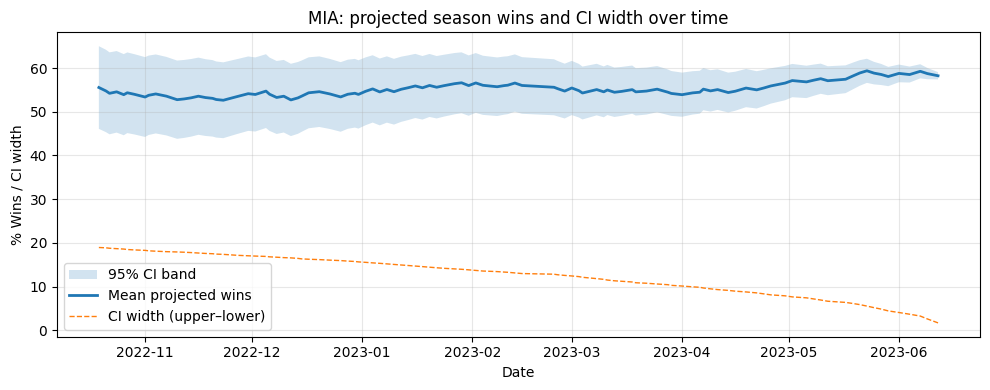

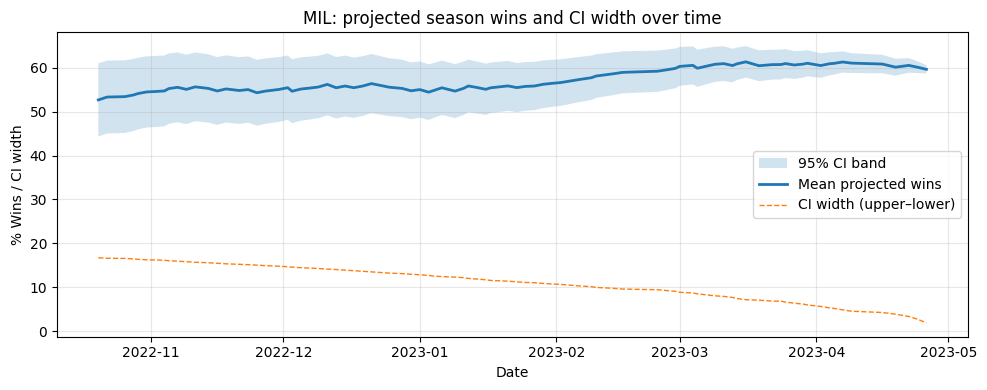

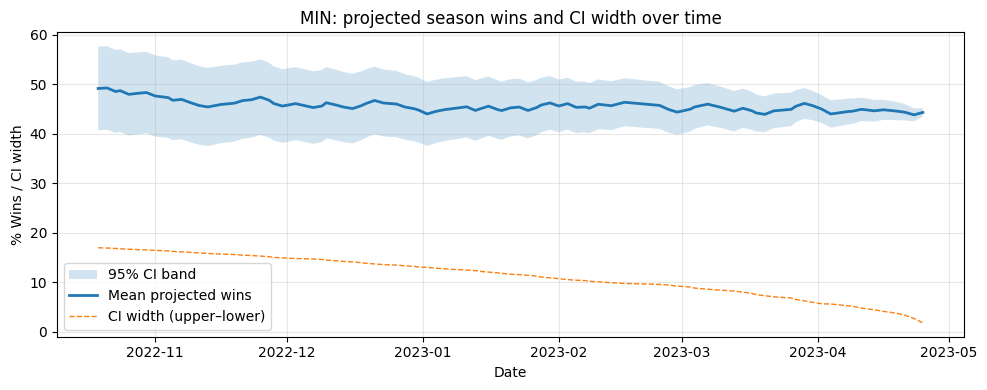

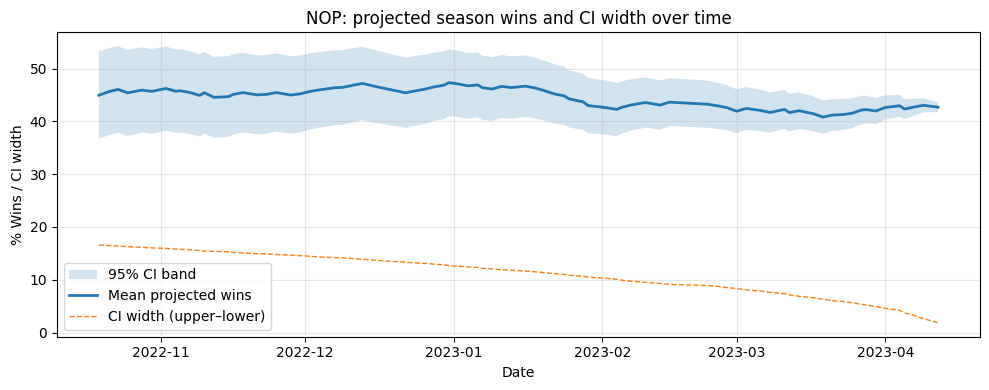

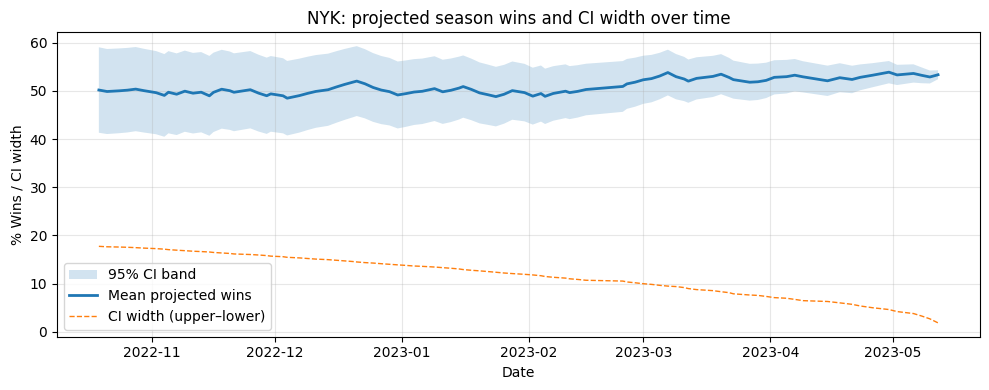

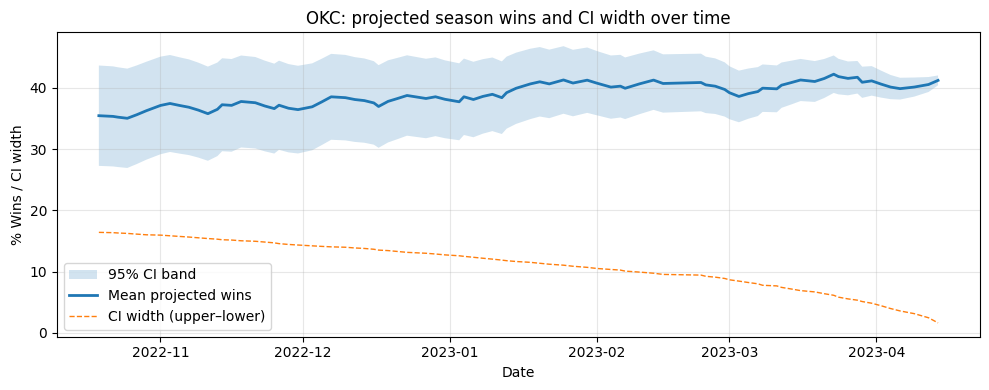

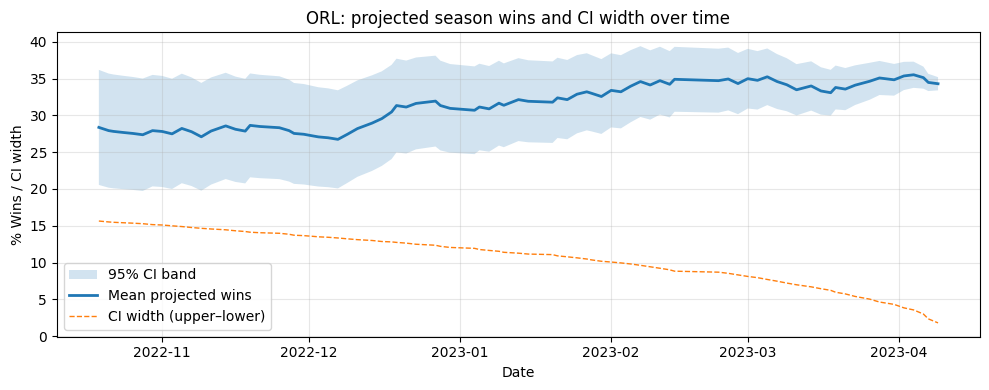

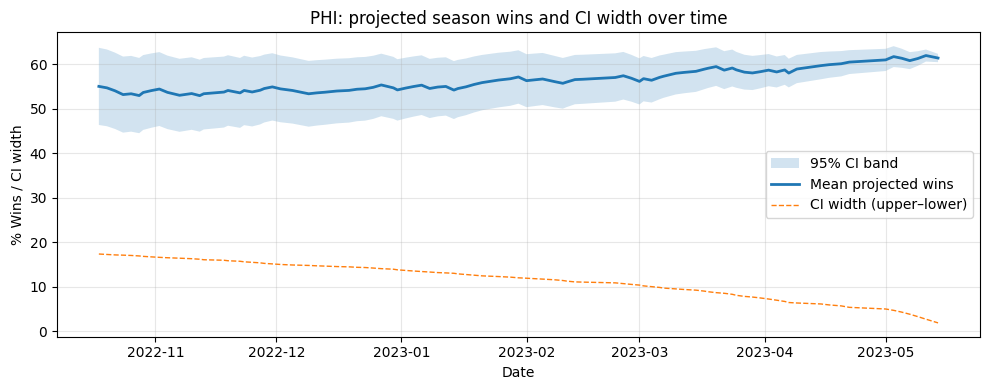

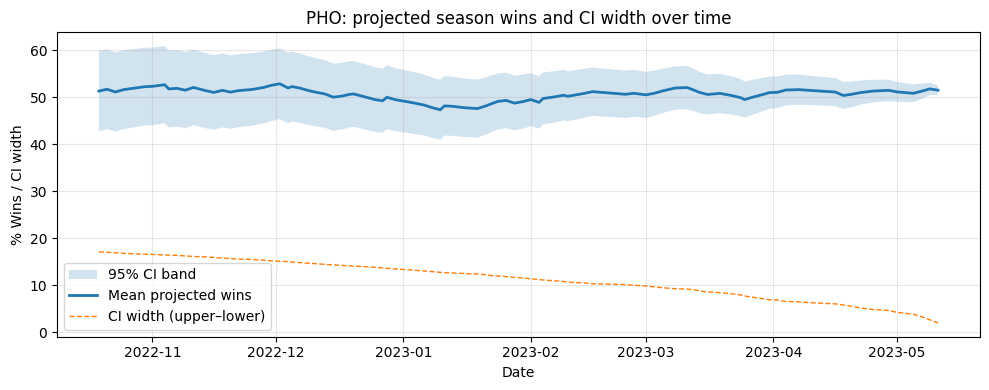

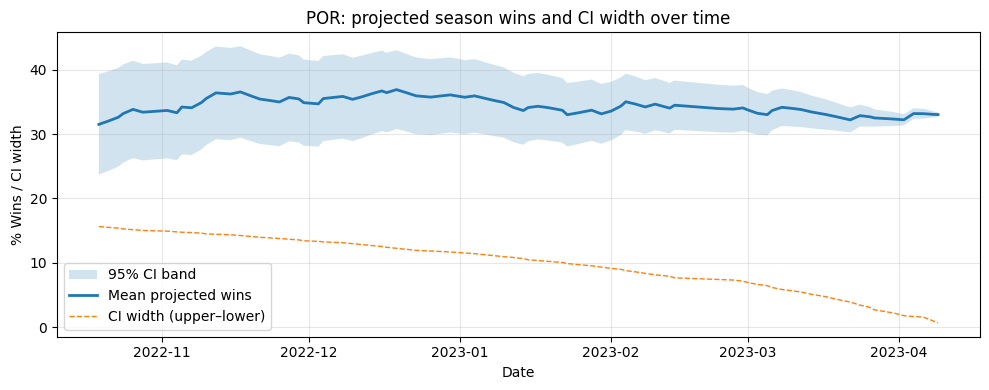

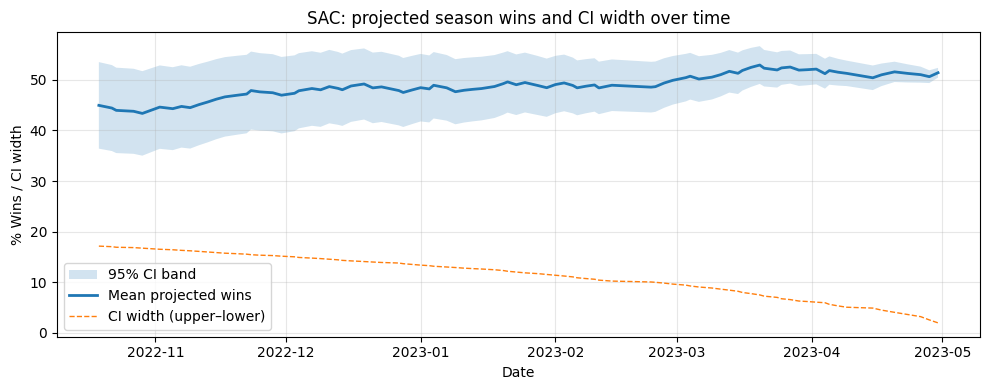

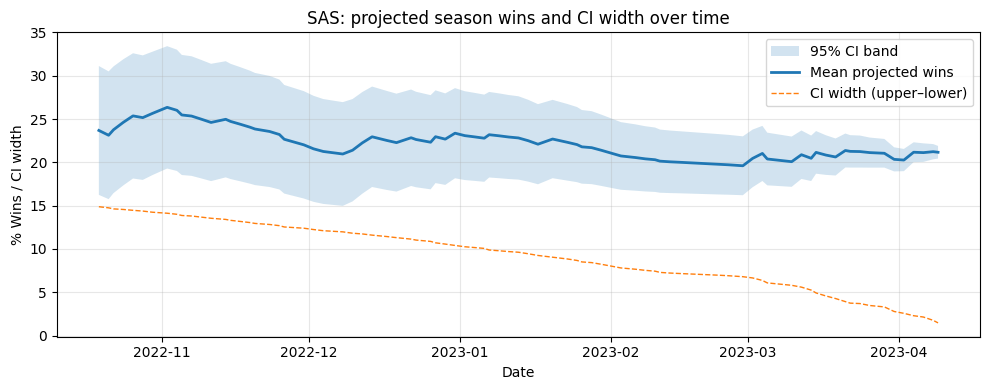

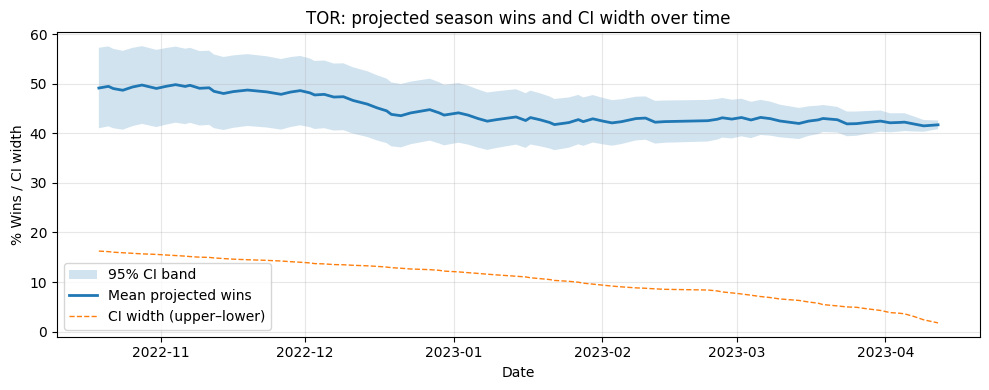

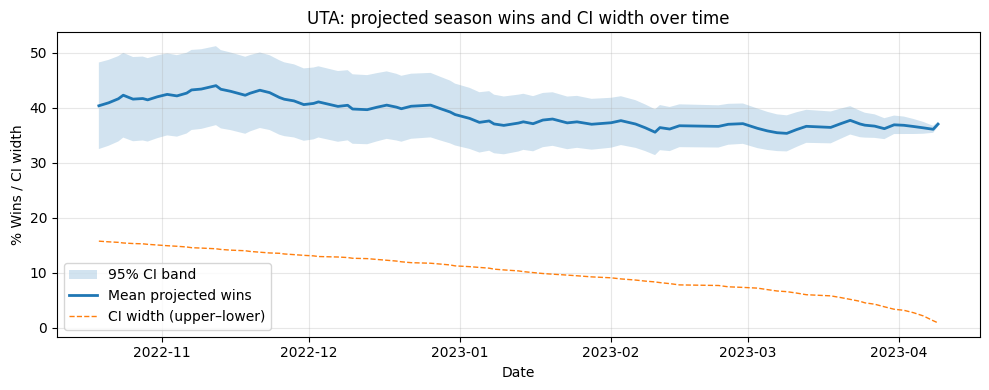

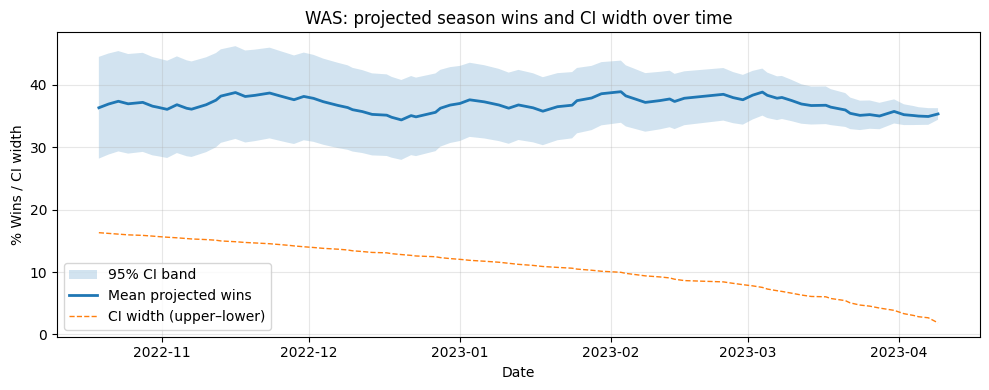

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load & flatten (same as before)
df = pd.read_csv('nba_elo_latest.csv', parse_dates=['date'])
records = []
for _, row in df.iterrows():
    records.append({'team': row['team1'], 'date': row['date'],
                    'prob': row['raptor_prob1'],
                    'actual': int(row['score1'] > row['score2'])})
    records.append({'team': row['team2'], 'date': row['date'],
                    'prob': row['raptor_prob2'],
                    'actual': int(row['score2'] > row['score1'])})
flat = pd.DataFrame(records)

# 2. Build the timeseries DataFrame, now including CI width
def build_ts(team):
    g = flat[flat['team']==team].sort_values('date')
    rows = []
    for d in g['date'].unique():
        past   = g[g['date'] < d]
        future = g[g['date'] >= d]
        actual_wins = past['actual'].sum()
        exp_wins    = future['prob'].sum()
        var_future  = (future['prob'] * (1 - future['prob'])).sum()
        sd_future   = np.sqrt(var_future)
        mean_total  = actual_wins + exp_wins
        lower = mean_total - 1.96*sd_future
        upper = mean_total + 1.96*sd_future
        # compute CI width
        ci_width = upper - lower
        rows.append({
            'date':     d,
            'mean':     mean_total,
            'lower':    lower,
            'upper':    upper,
            'ci_width': ci_width
        })
    return pd.DataFrame(rows)

# 3. Plot loop with CI width line
for team in sorted(flat['team'].unique()):
    ts = build_ts(team)
    plt.figure(figsize=(10, 4))
    # shaded CI band
    plt.fill_between(ts['date'], ts['lower'], ts['upper'], alpha=0.2,
                     label='95% CI band')
    # mean projection
    plt.plot(ts['date'], ts['mean'], lw=2, label='Mean projected wins')
    # CI width over time
    plt.plot(ts['date'], ts['ci_width'], lw=1, linestyle='--',
             label='CI width (upper–lower)')
    plt.title(f'{team}: projected season wins and CI width over time')
    plt.xlabel('Date')
    plt.ylabel('% Wins / CI width')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [31]:
# Assuming `rank_df` DataFrame (indexed by date, columns=teams, values=ranks) is already in your session

# 1. Save the wide-format CSV (dates as rows, teams as columns)
rank_df.to_csv('predicted_rank_over_time_wide.csv')

# 2. Also save a long-format CSV (one row per date-team)
rank_long = (
    rank_df
    .reset_index()  # moves date from index to column
    .melt(id_vars='date', var_name='team', value_name='rank')
)
rank_long.to_csv('predicted_rank_over_time_long.csv', index=False)

print("Saved 'predicted_rank_over_time_wide.csv' and 'predicted_rank_over_time_long.csv' in the current directory.")


Saved 'predicted_rank_over_time_wide.csv' and 'predicted_rank_over_time_long.csv' in the current directory.


# Analysis

In [17]:
# --- after your existing imports, flat dataframe, and build_ts(team) function ---

# 1. Gather initial & final mean wins for every team
diffs = {}
for team in sorted(flat['team'].unique()):
    ts = build_ts(team)            # your existing timeseries builder
    initial = ts.loc[0,    'mean']
    final   = ts.loc[len(ts)-1, 'mean']
    diffs[team] = final - initial

# 2. Find the team with the largest absolute change
best_team = max(diffs, key=lambda t: abs(diffs[t]))
initial, final = initial, final  # just placeholders—recompute below for clarity
initial = build_ts(best_team).loc[0,    'mean']
final   = build_ts(best_team).loc[len(build_ts(best_team))-1, 'mean']
change  = diffs[best_team]

print(f"Team with the biggest shift: {best_team}")
print(f"  Initial forecast: {initial:.2f} wins")
print(f"  Final forecast:   {final:.2f} wins")
print(f"  Net change:       {change:.2f} wins")


Team with the biggest shift: DAL
  Initial forecast: 48.69 wins
  Final forecast:   38.83 wins
  Net change:       -9.86 wins


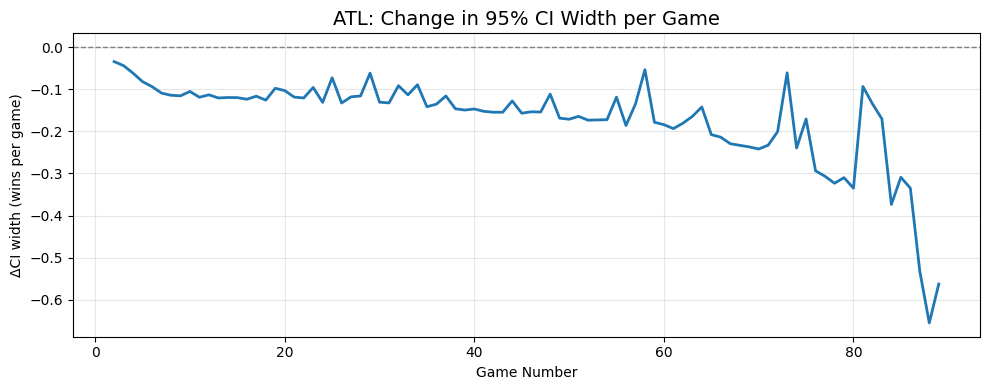

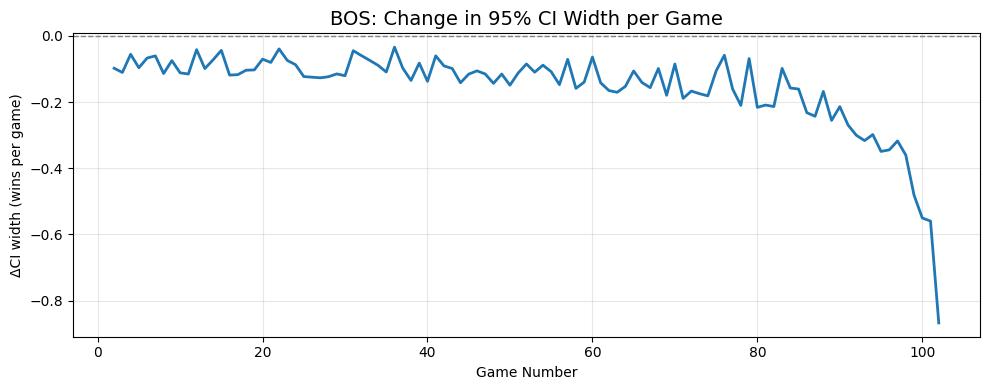

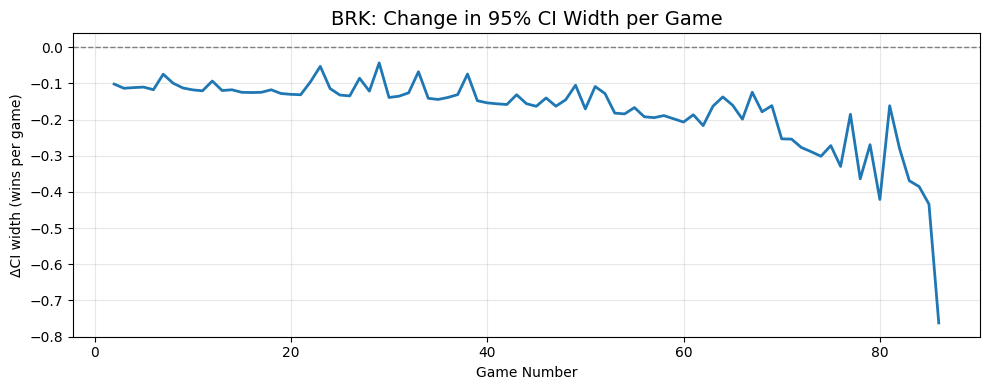

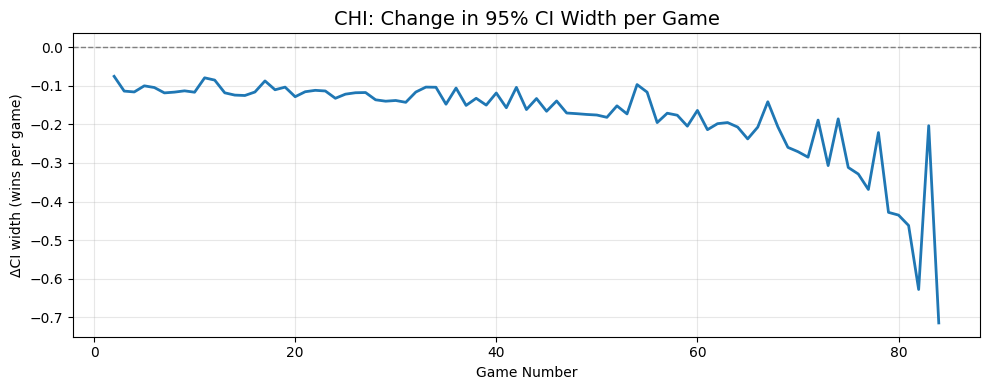

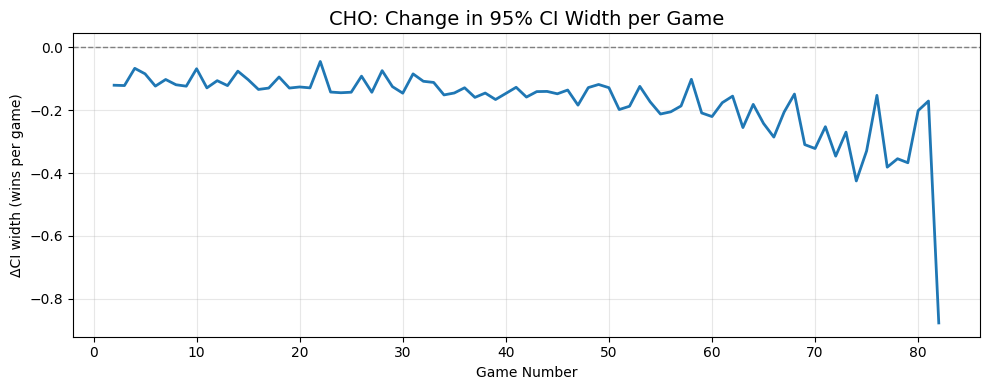

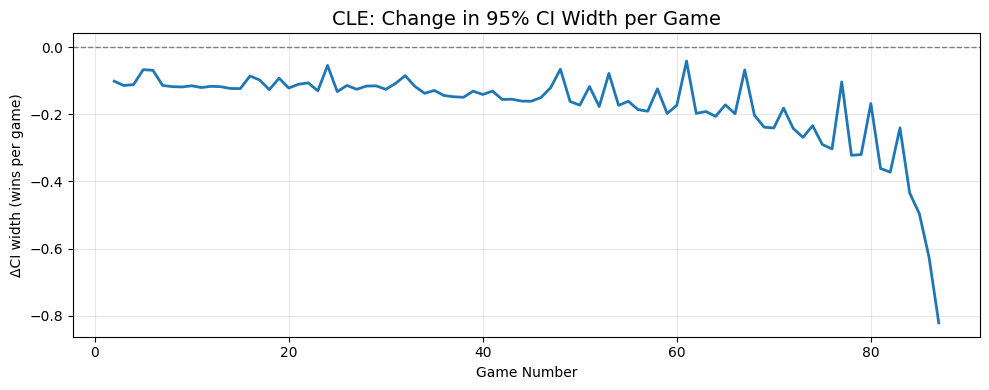

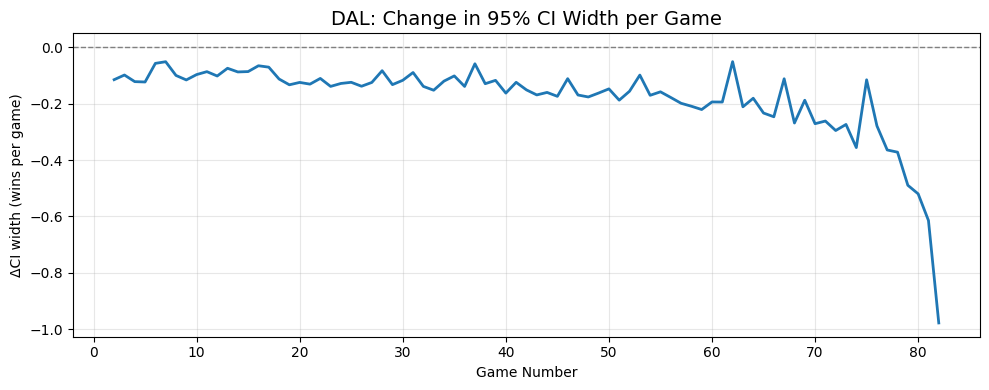

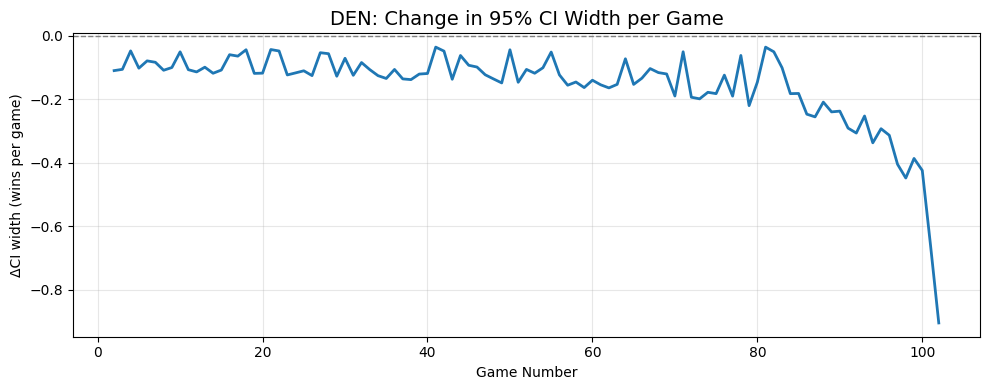

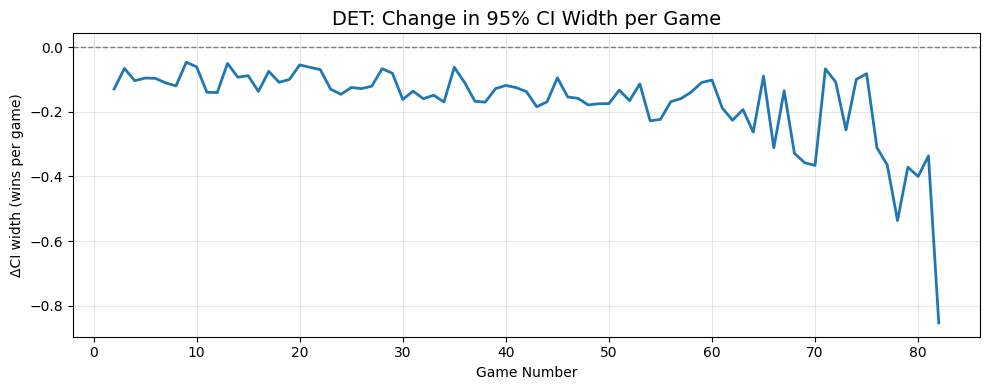

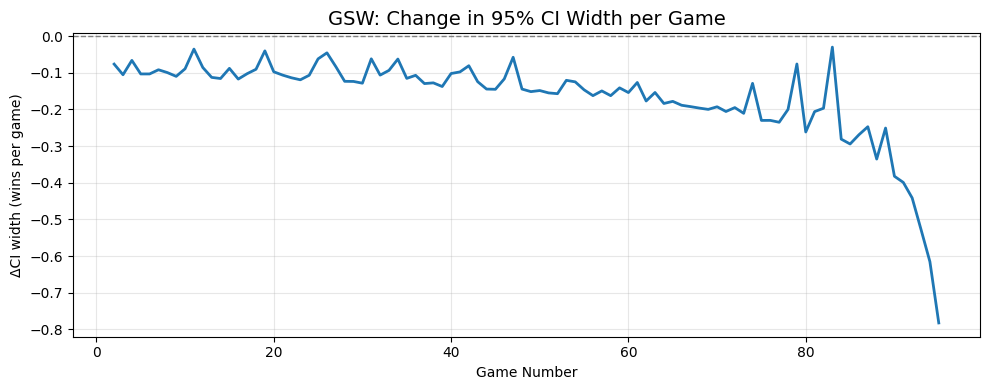

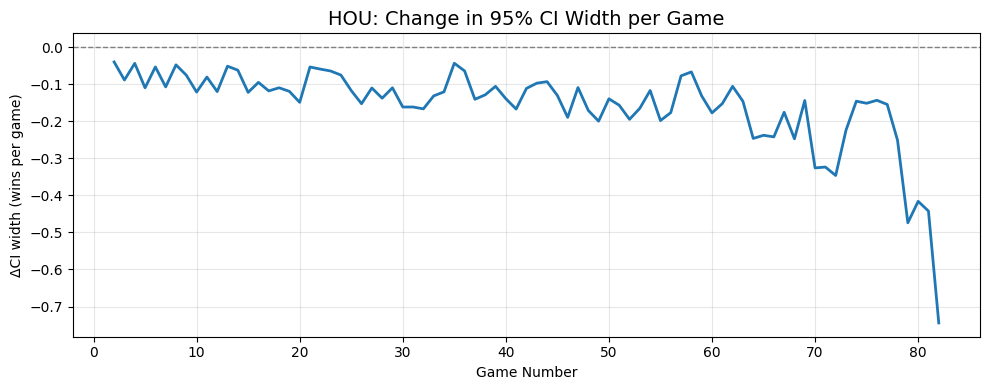

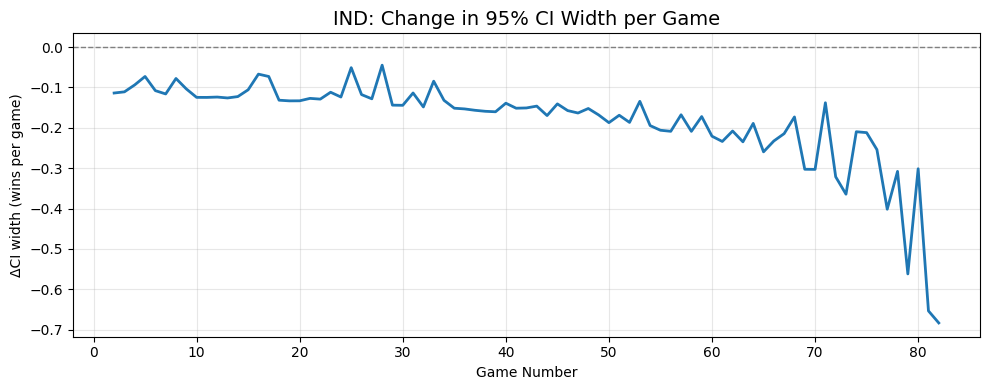

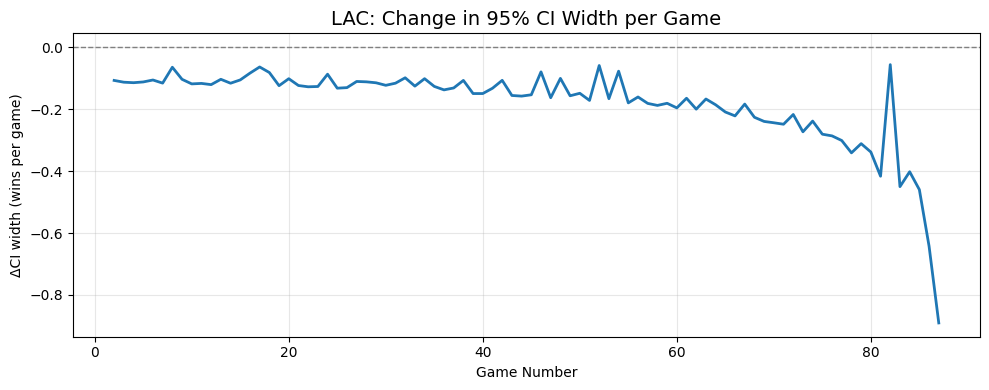

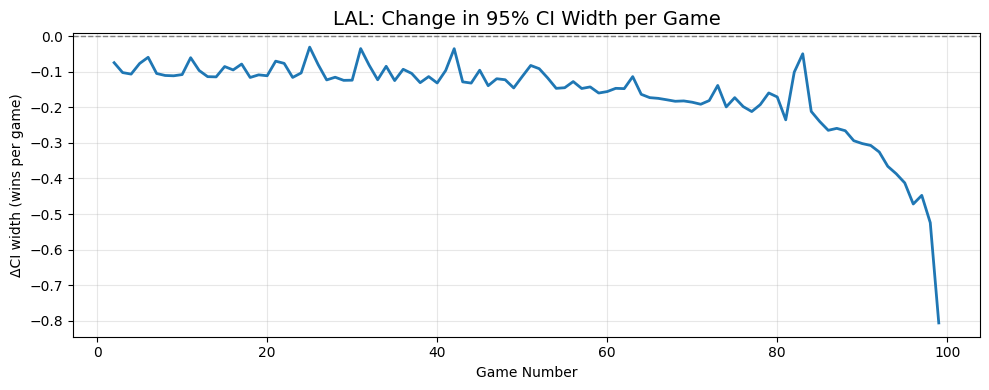

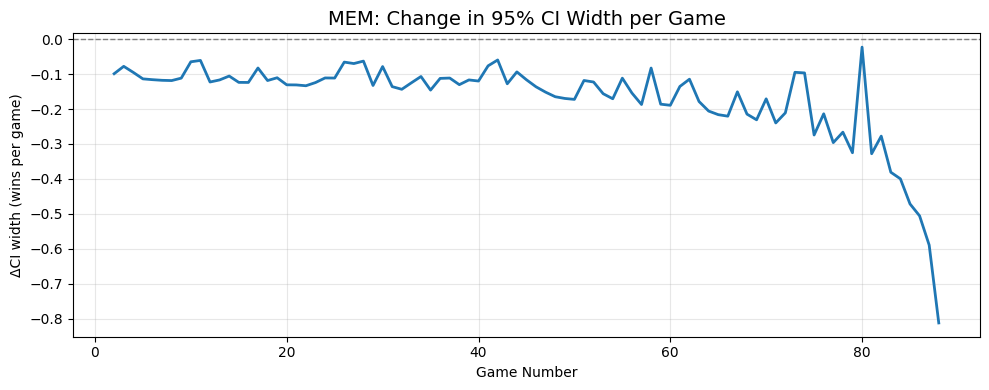

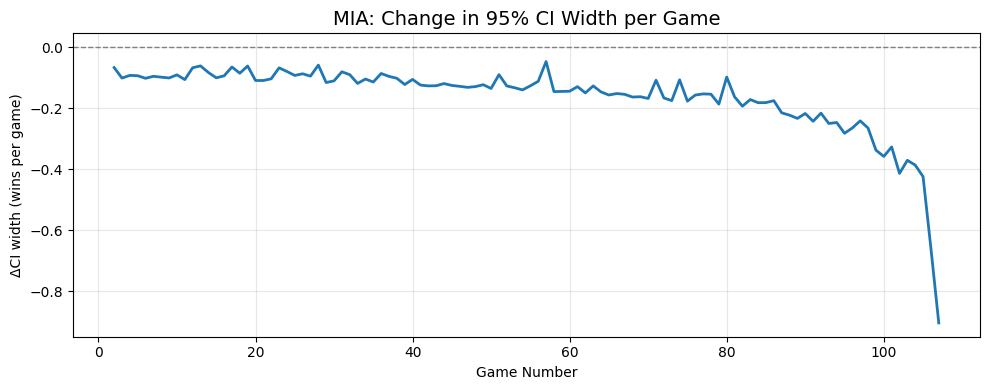

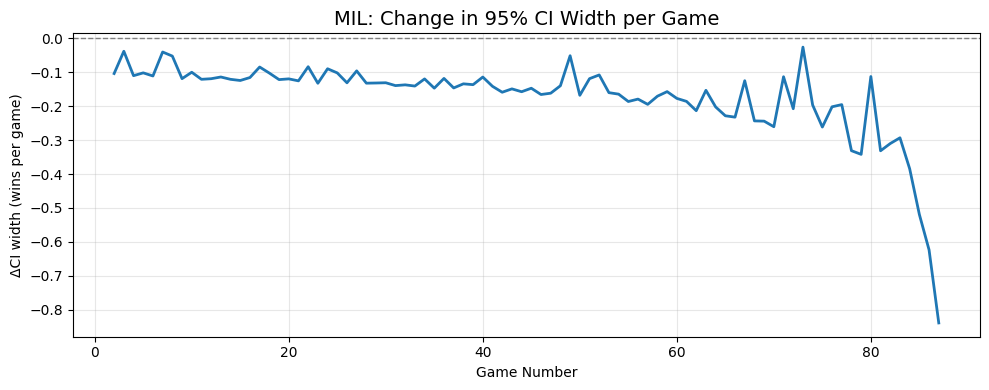

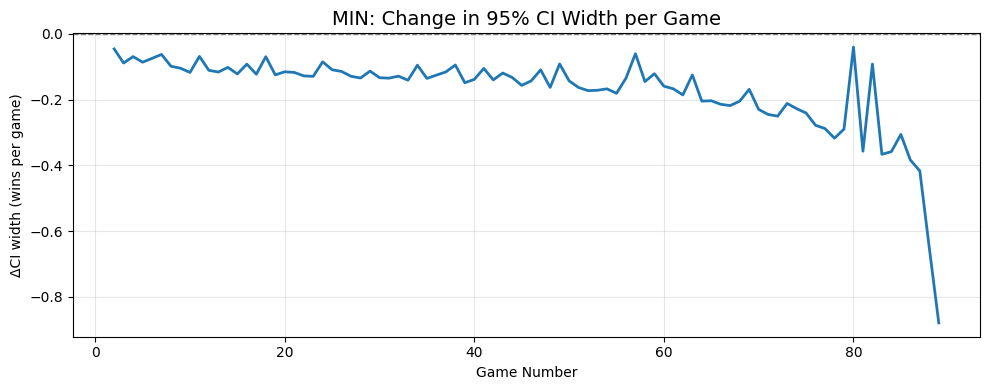

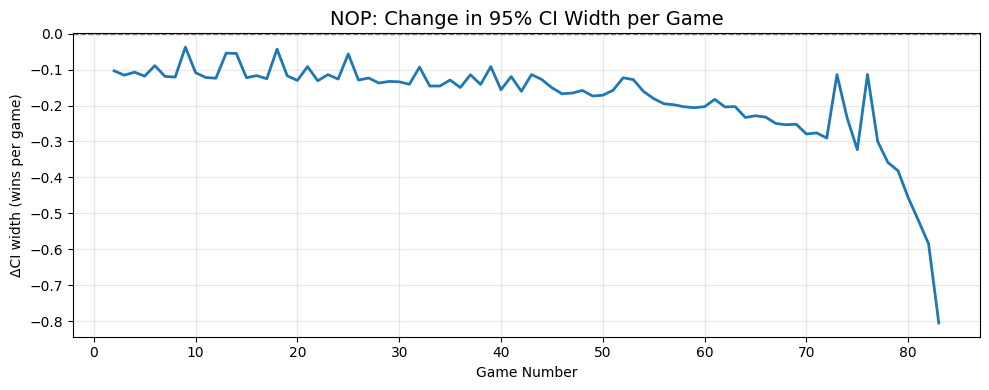

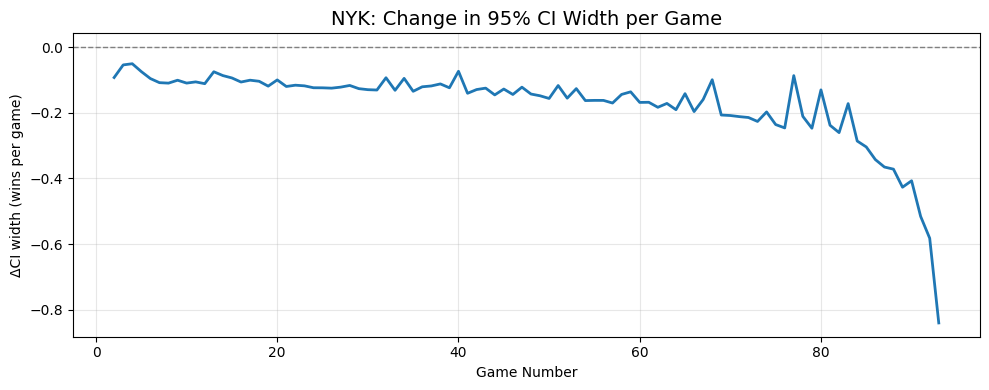

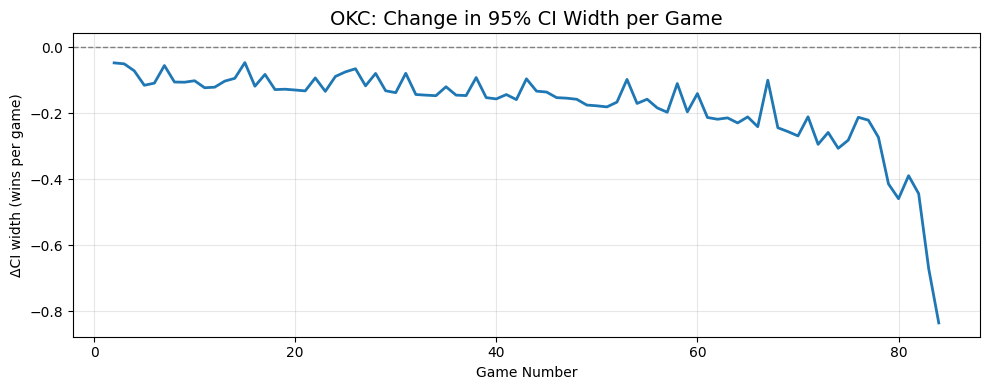

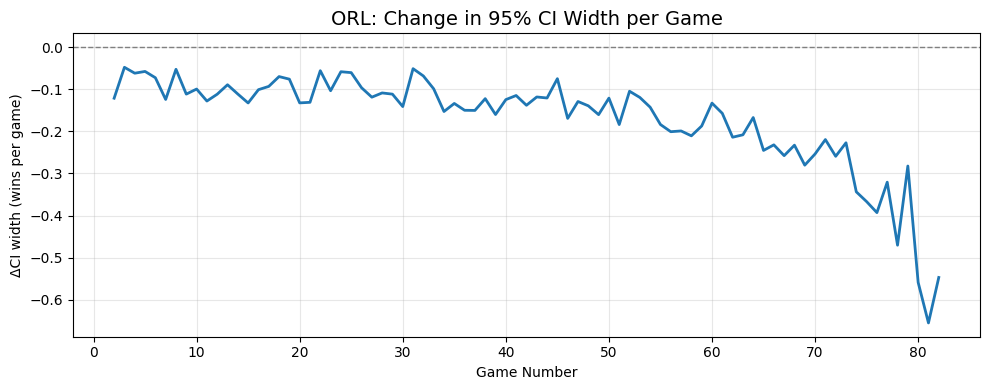

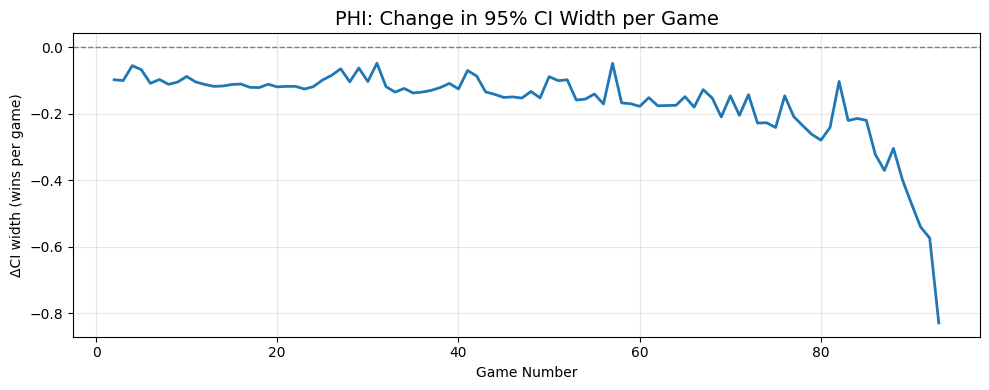

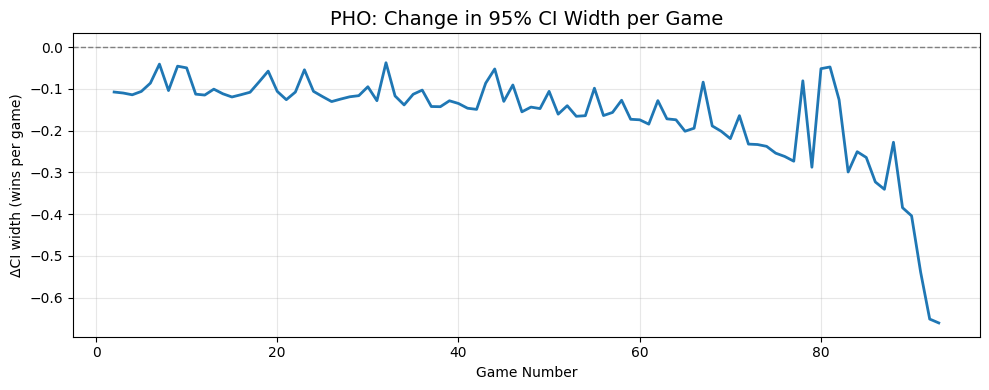

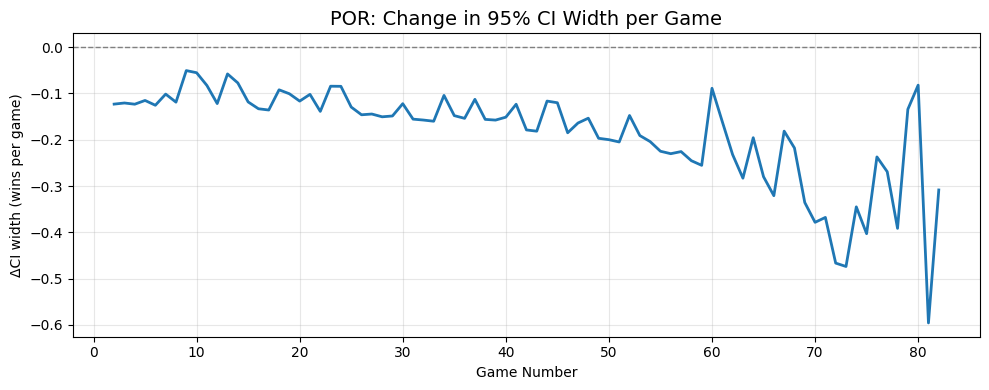

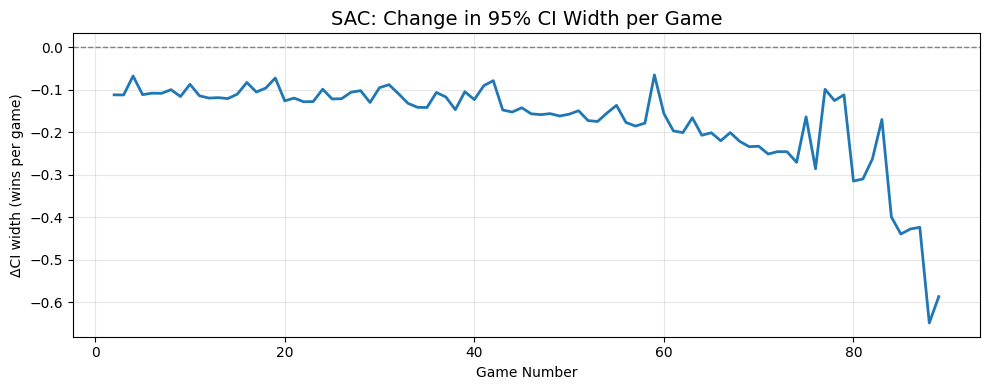

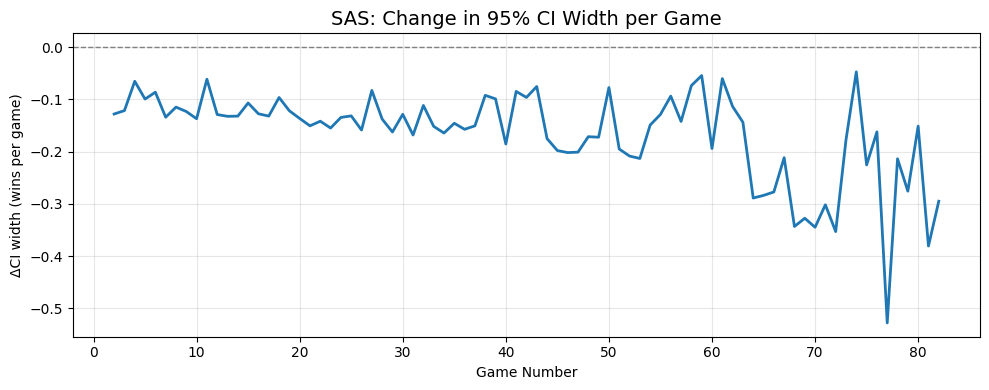

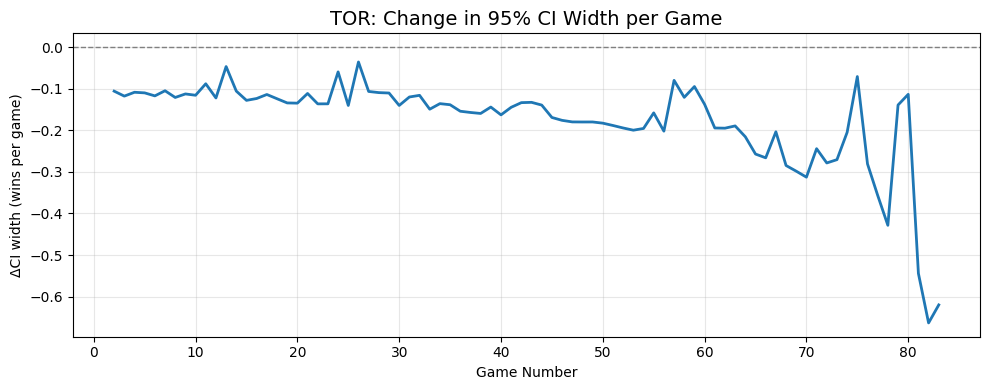

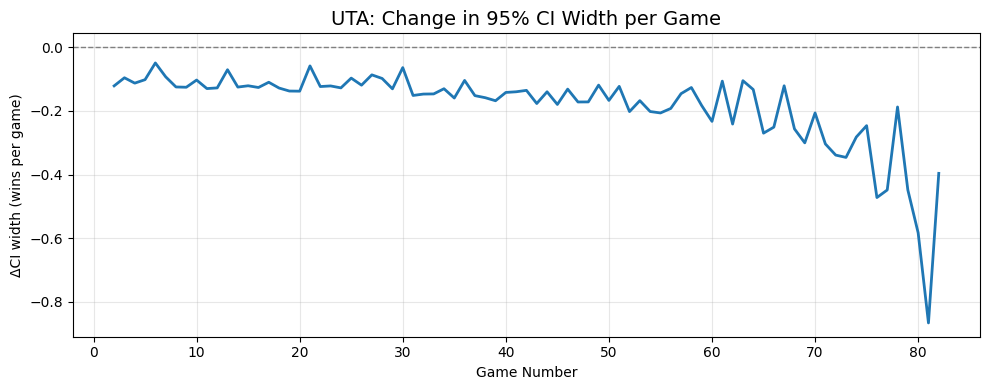

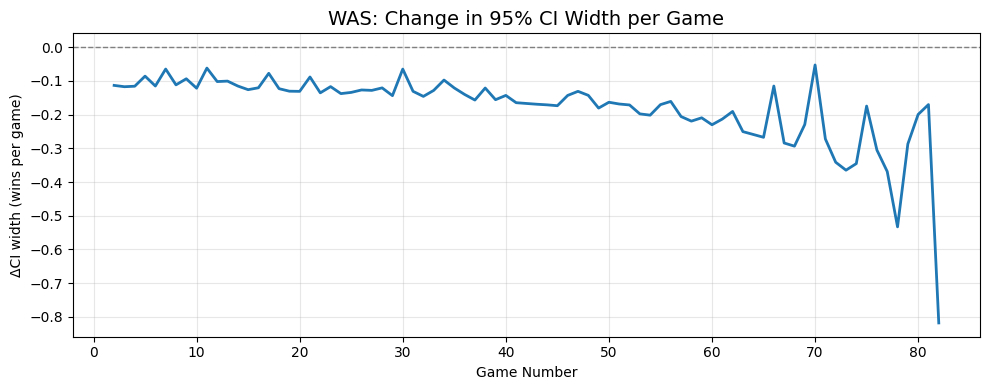

In [20]:
import matplotlib.pyplot as plt

teams = sorted(flat['team'].unique())
for team in teams:
    ts = build_ts(team)  # your DataFrame with ['date','ci_width',…]
    
    # 1) assign sequential game numbers
    ts = ts.reset_index(drop=True)
    ts['game_num'] = ts.index + 1
    
    # 2) slope per game = change in CI width from one game to the next
    ts['ci_slope_game'] = ts['ci_width'].diff()
    
    # 3) plot
    plt.figure(figsize=(10, 4))
    plt.plot(ts['game_num'], ts['ci_slope_game'], lw=2)
    plt.axhline(0, color='gray', lw=1, linestyle='--')
    plt.title(f'{team}: Change in 95% CI Width per Game', fontsize=14)
    plt.xlabel('Game Number')
    plt.ylabel('ΔCI width (wins per game)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

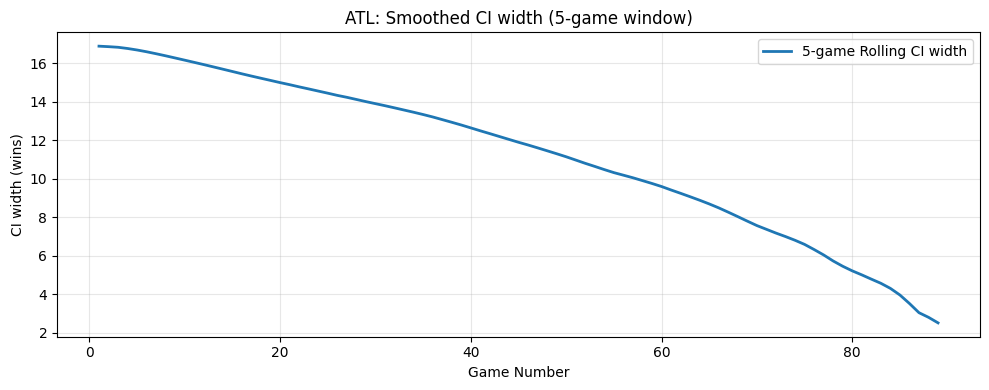

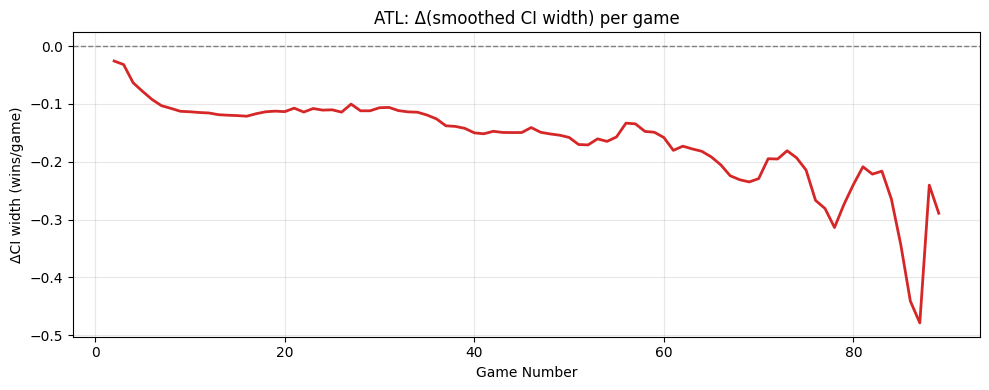

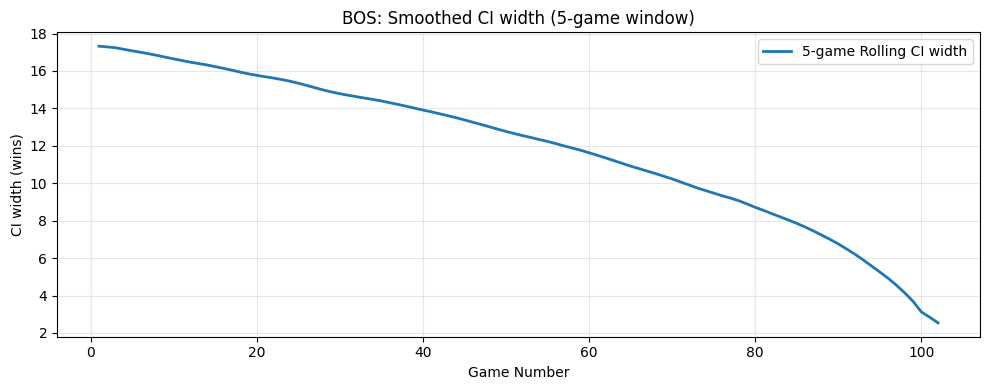

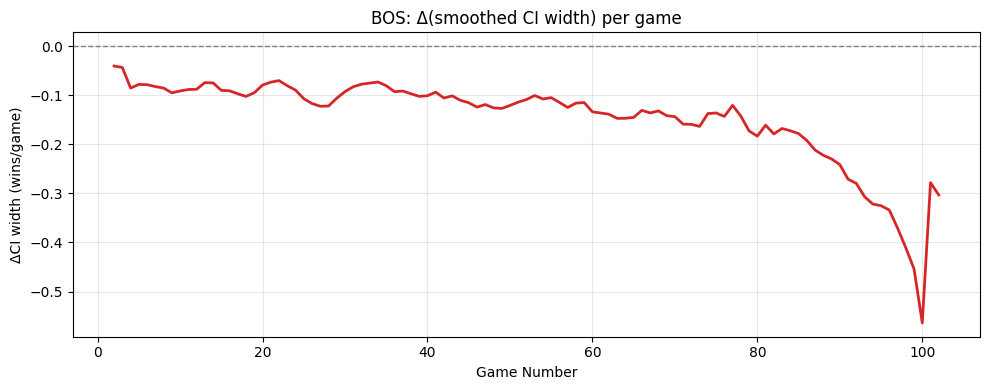

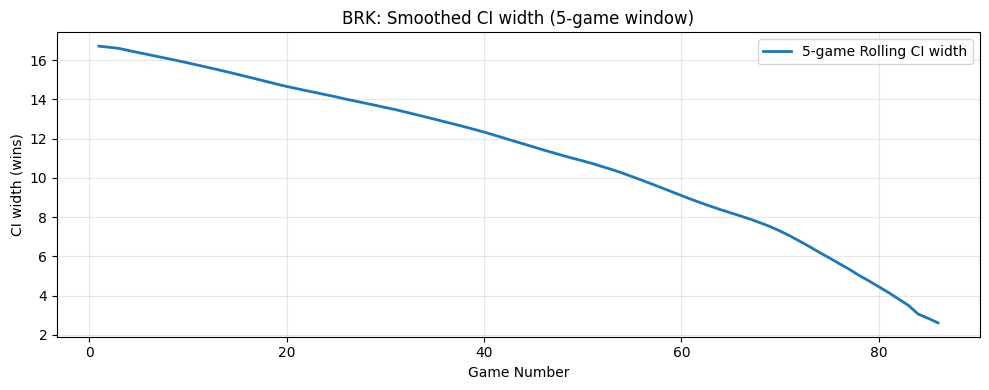

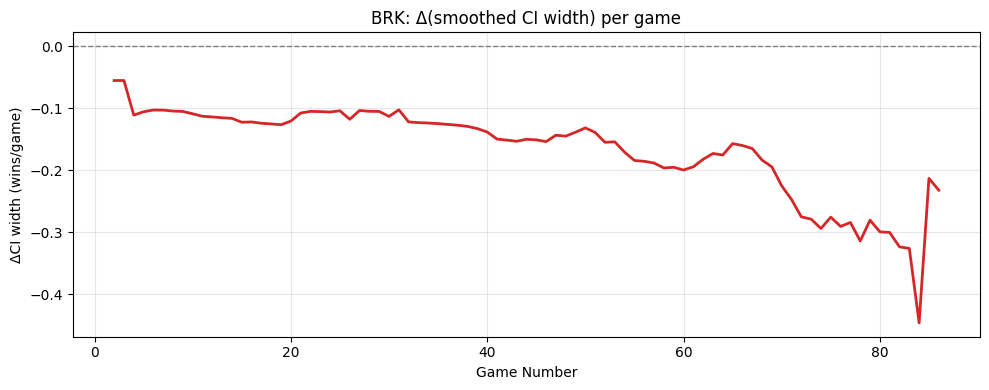

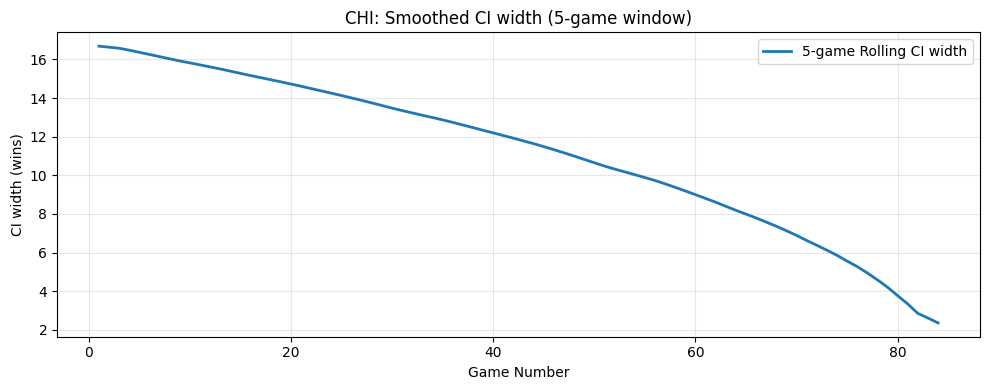

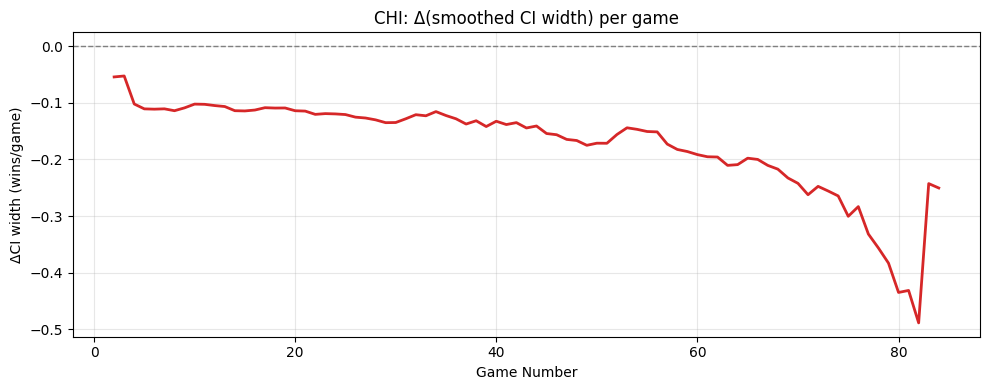

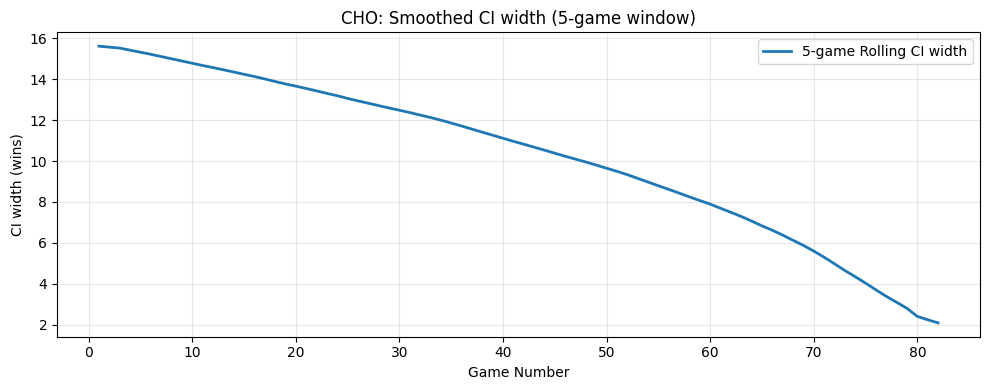

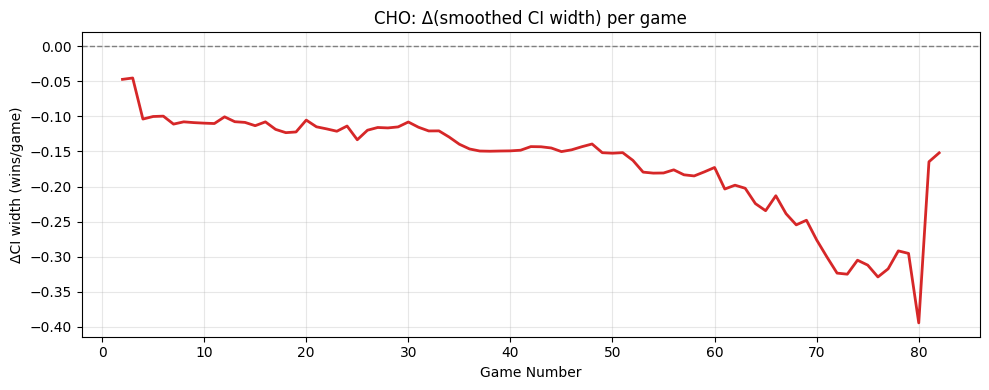

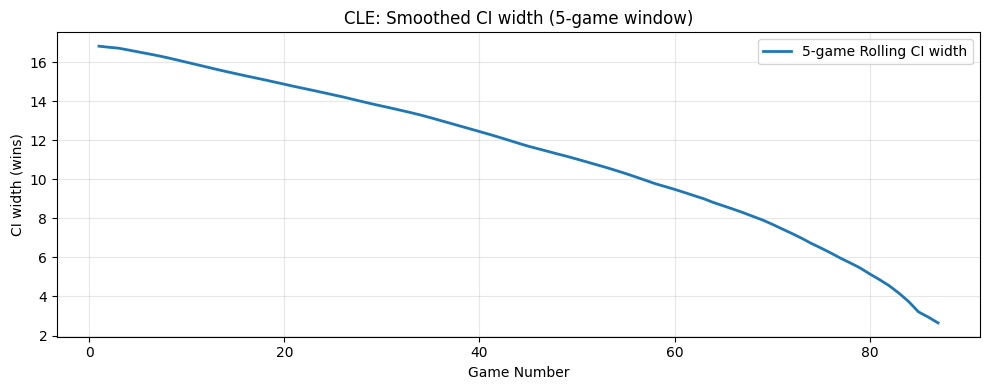

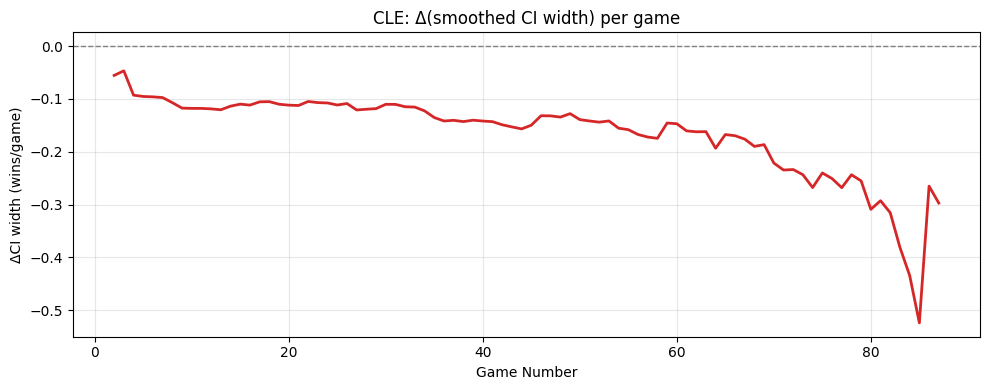

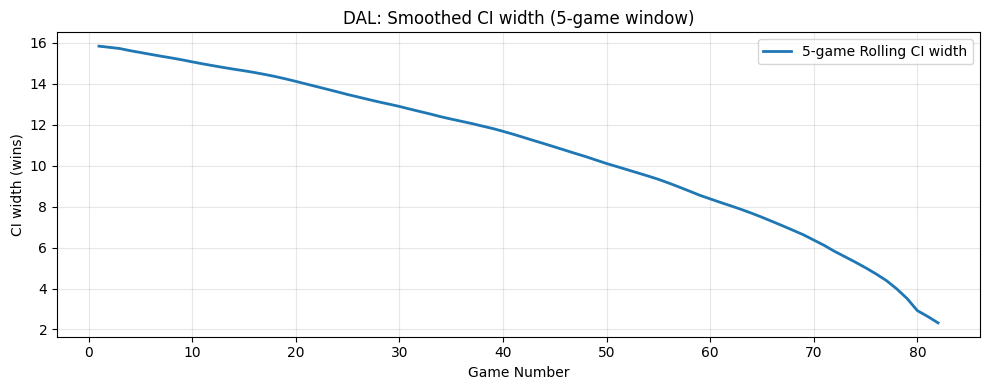

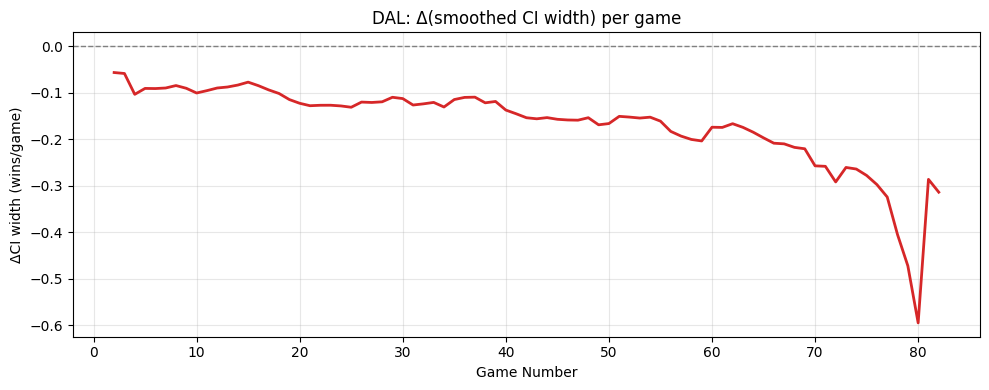

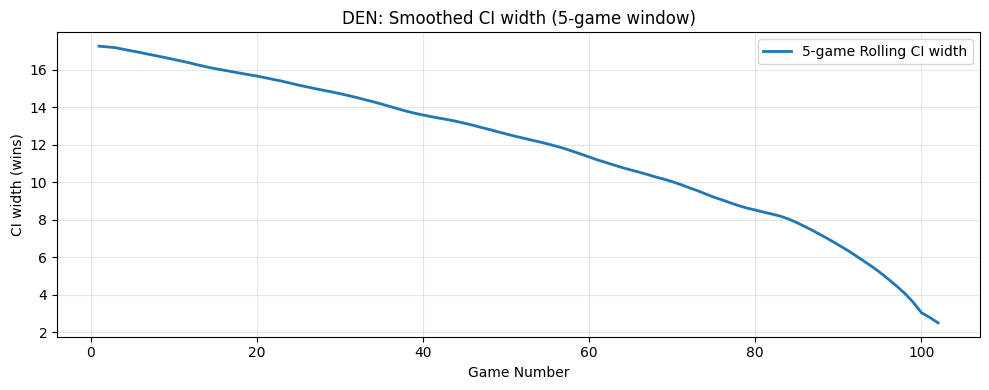

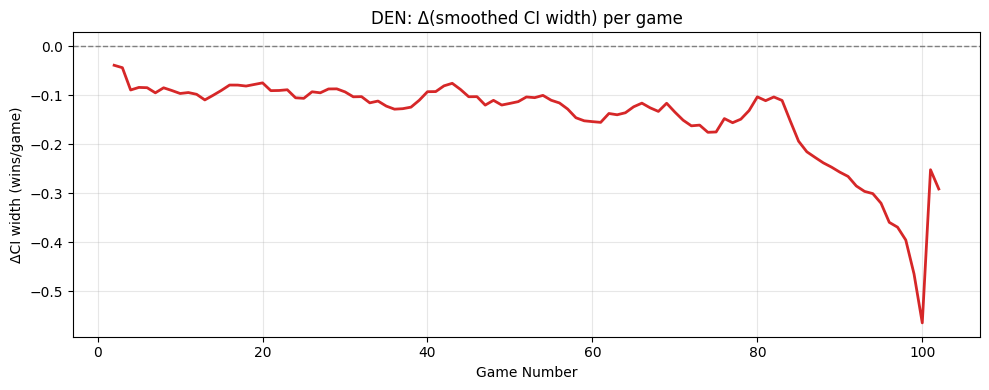

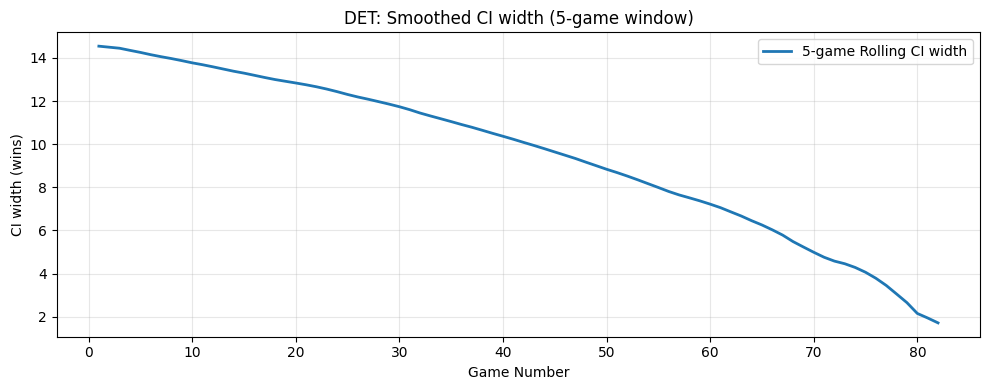

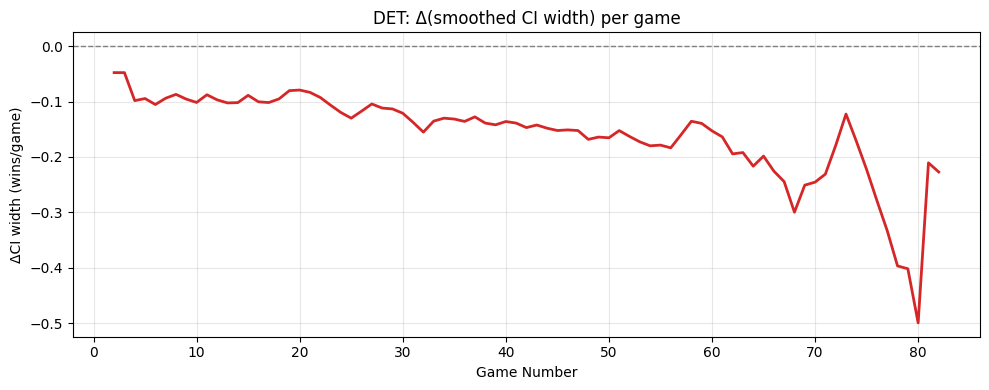

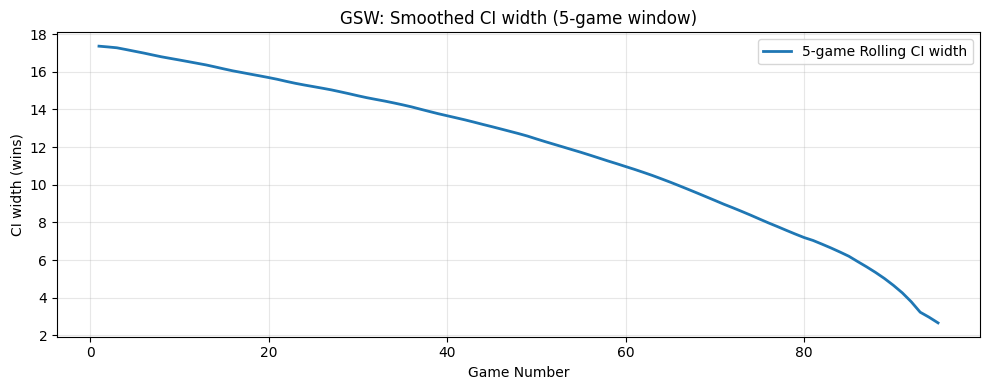

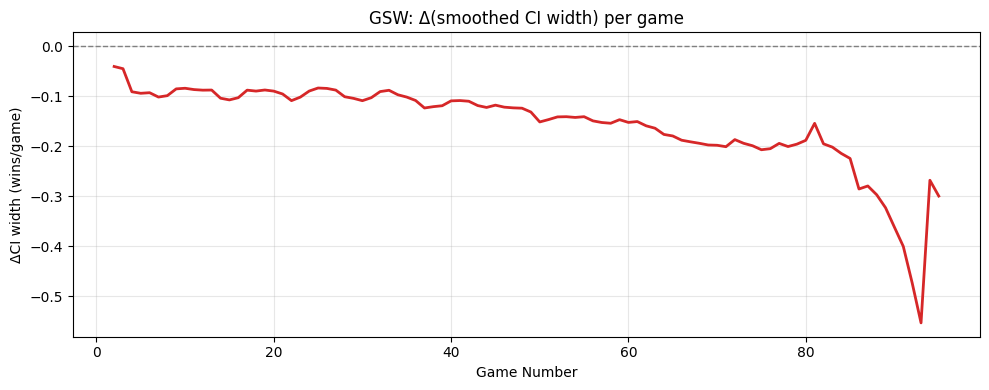

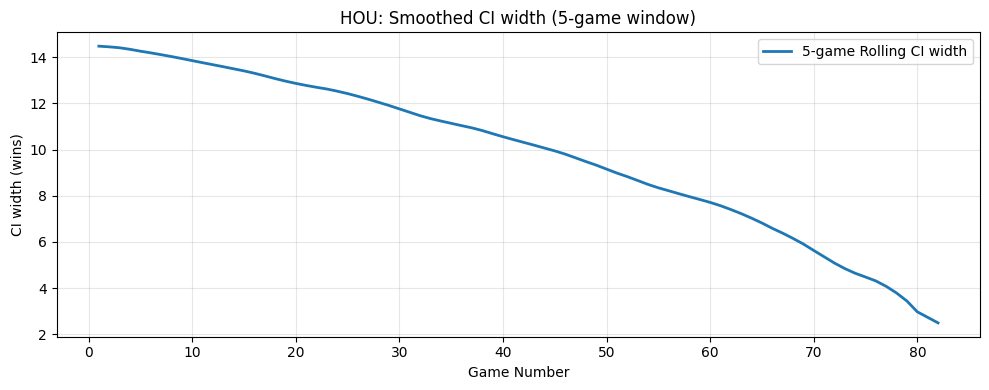

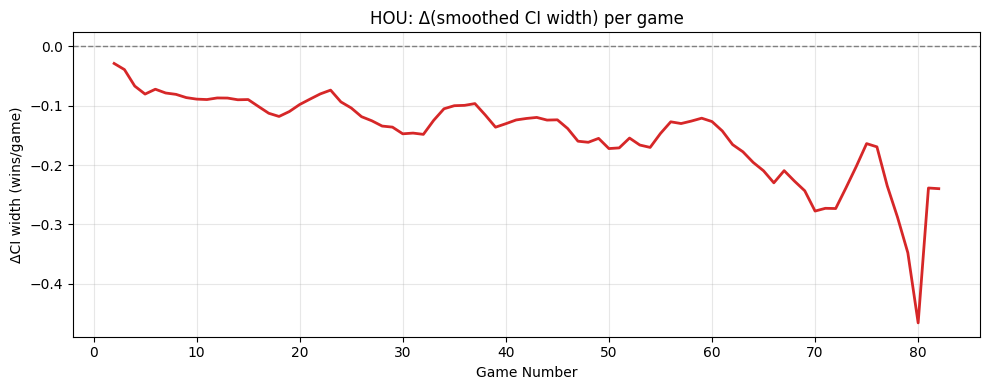

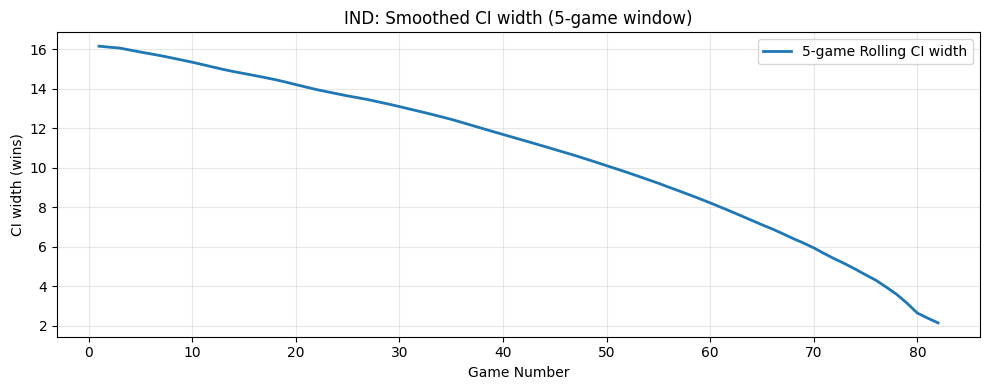

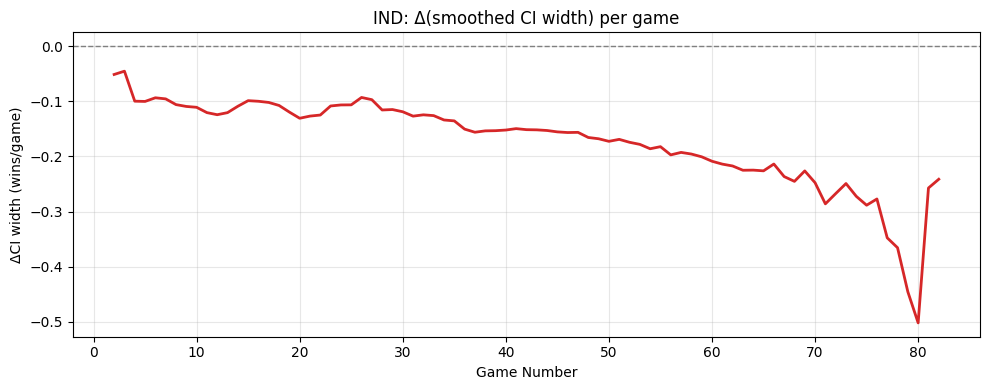

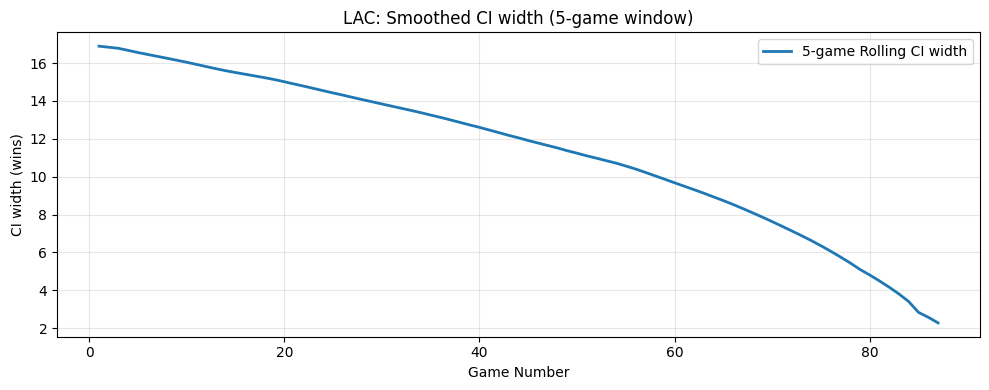

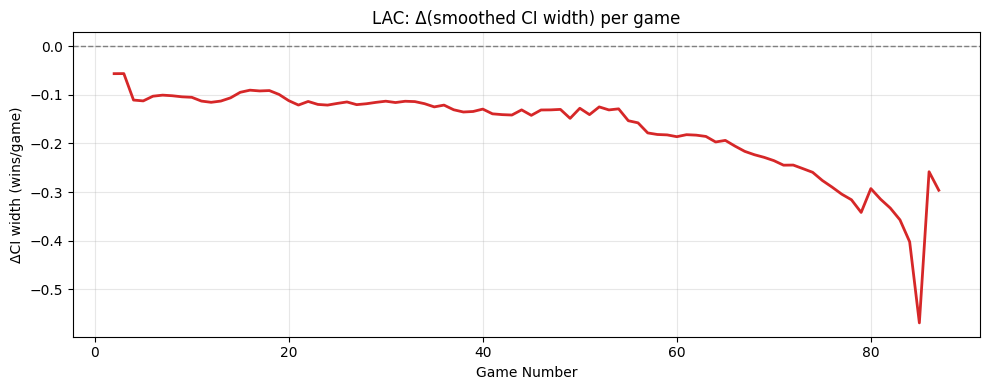

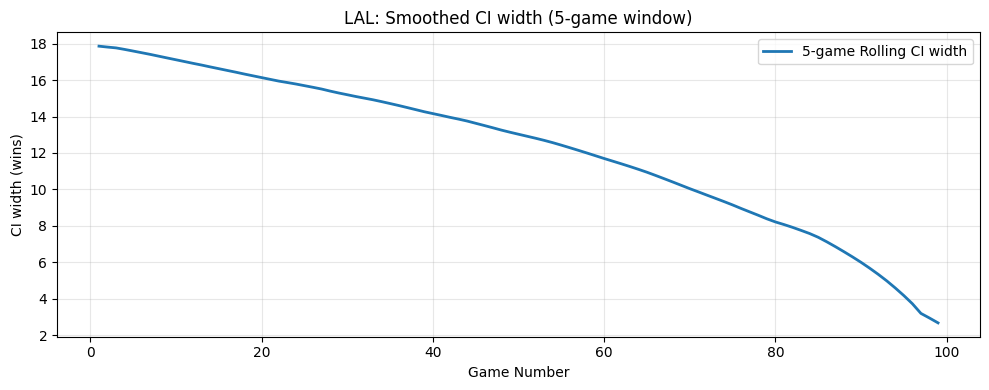

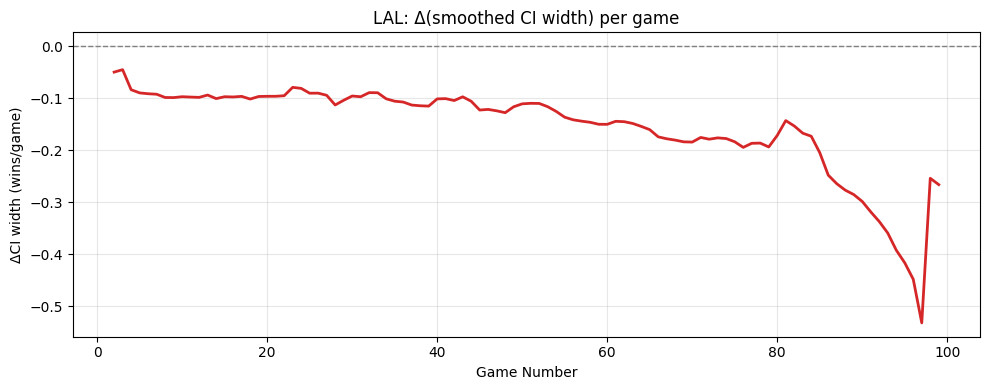

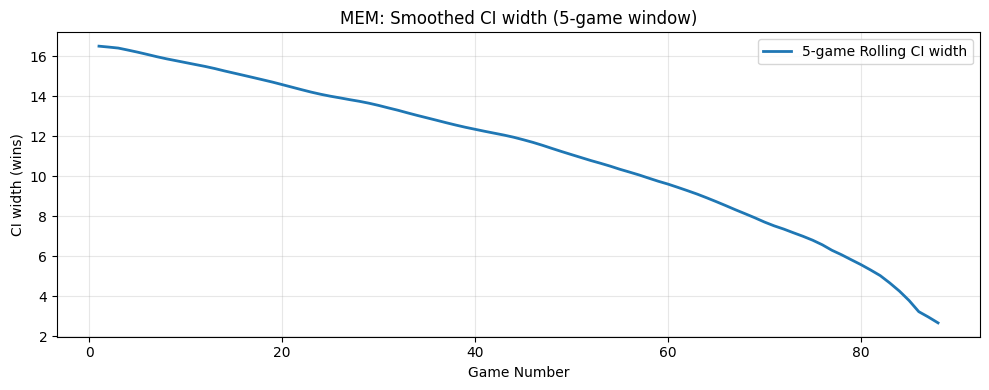

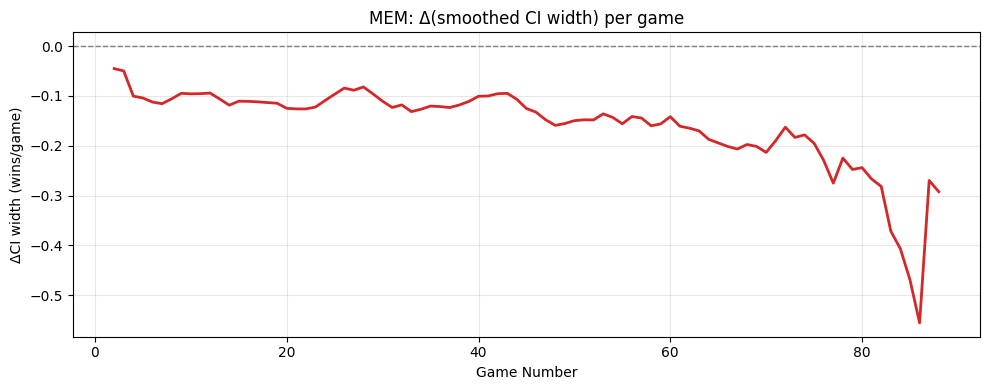

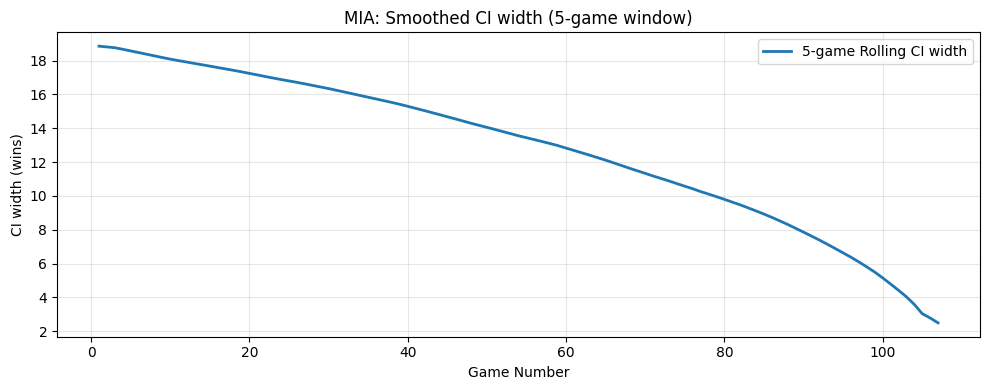

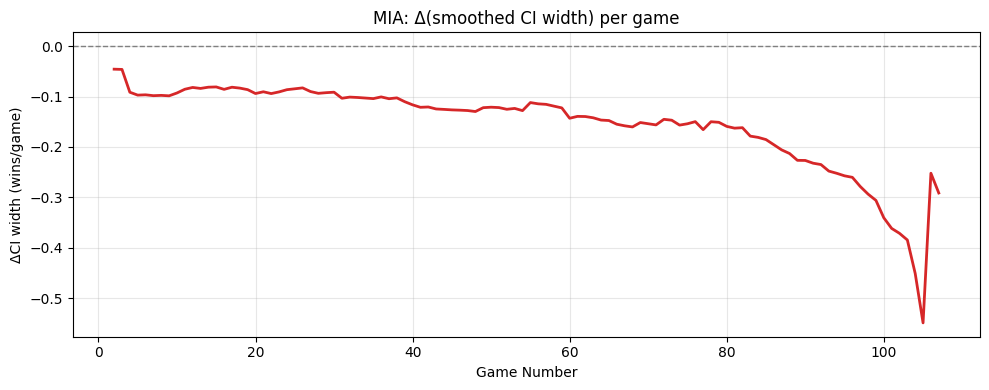

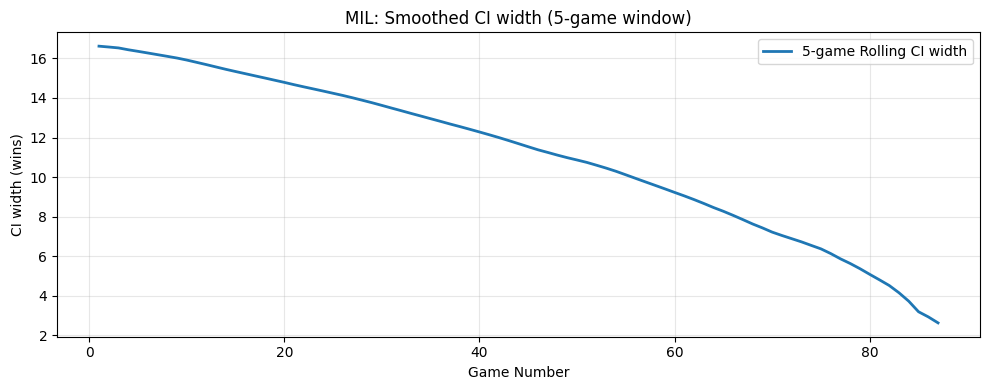

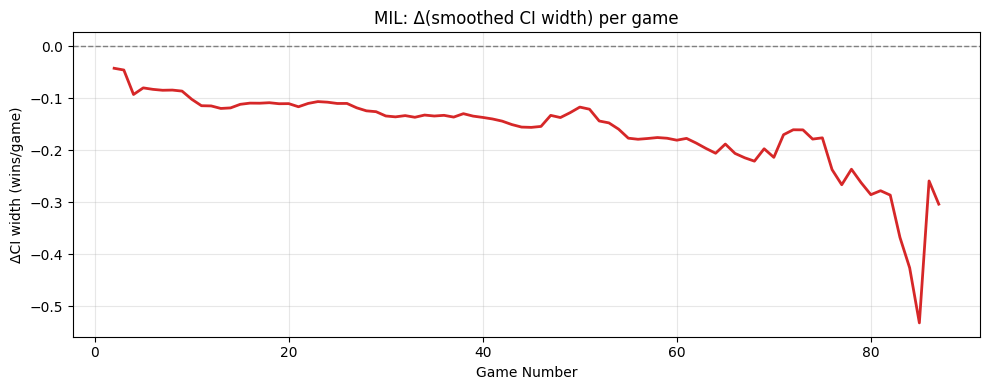

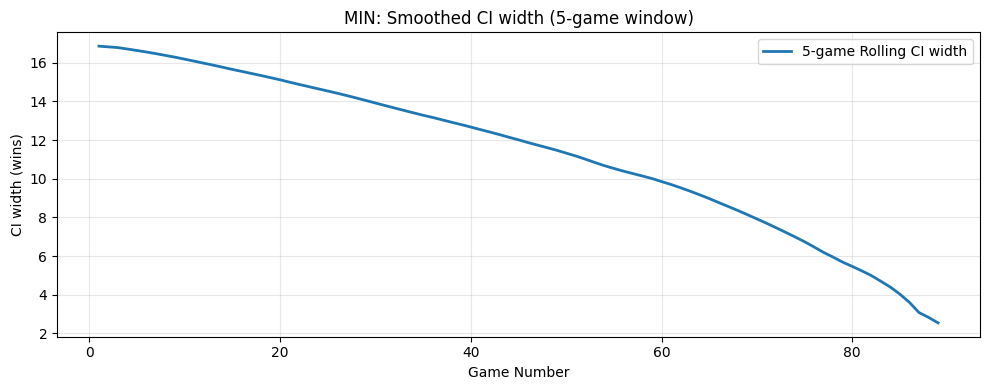

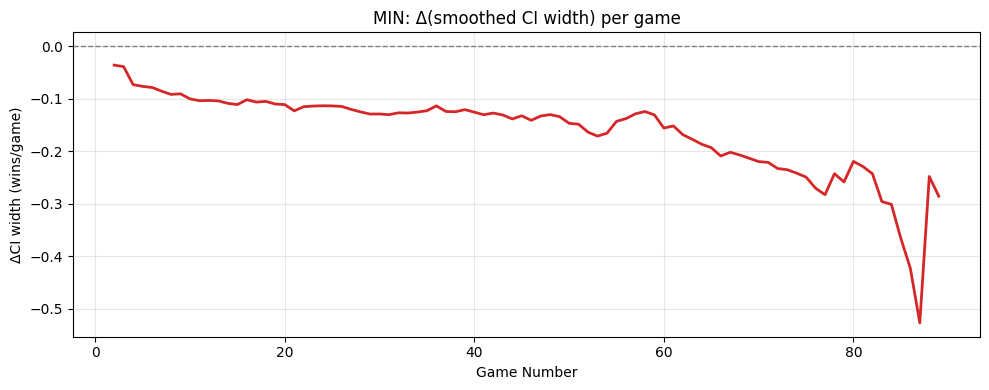

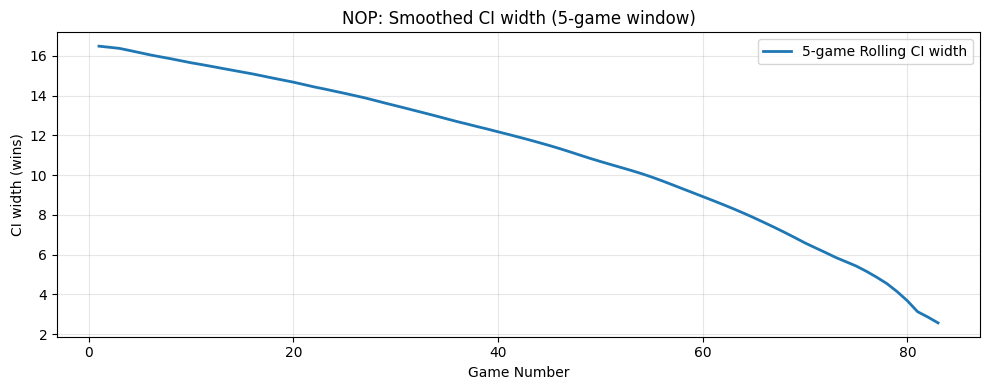

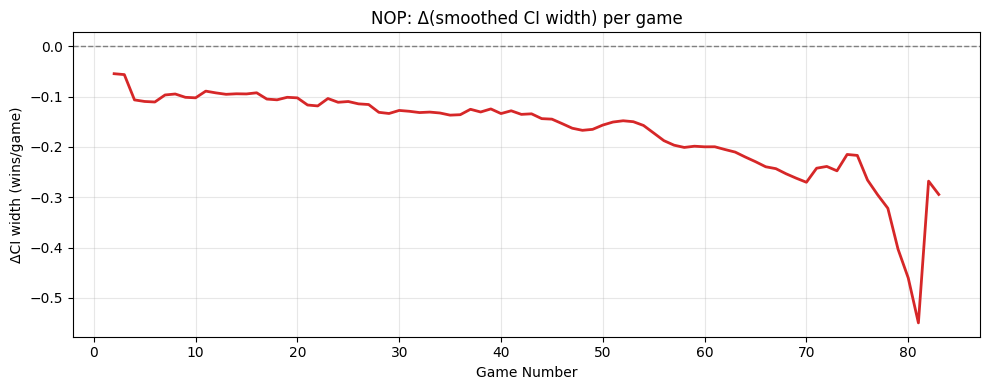

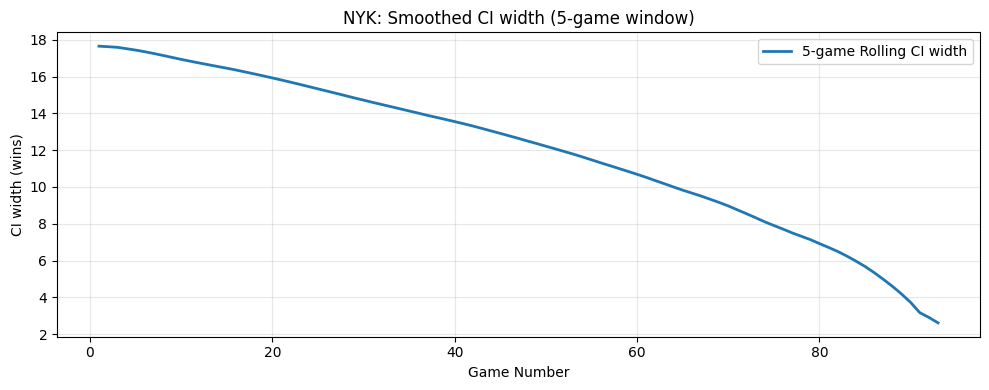

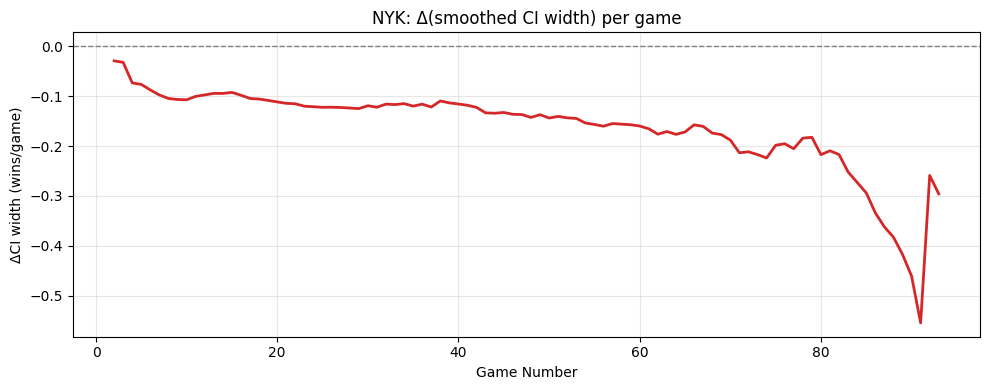

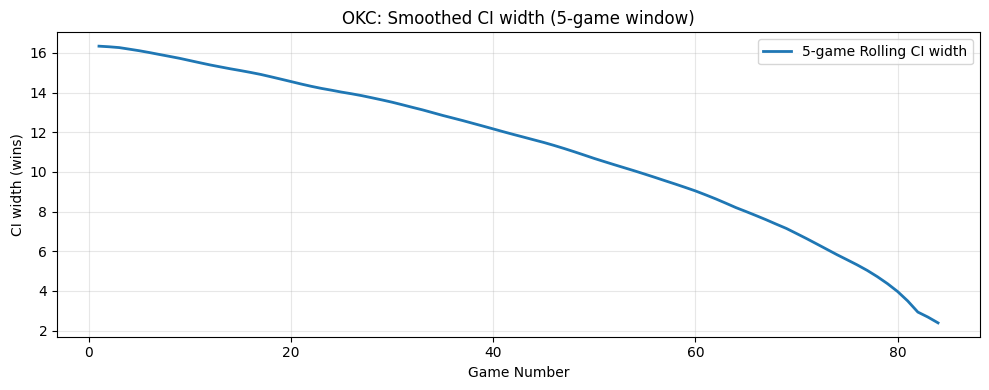

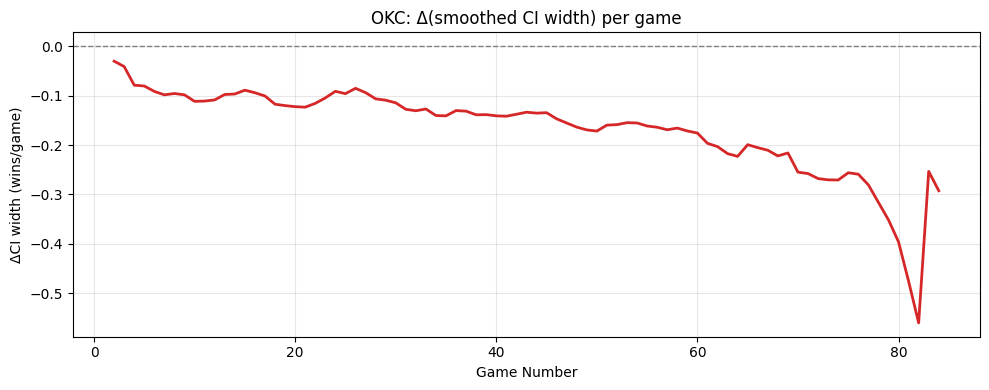

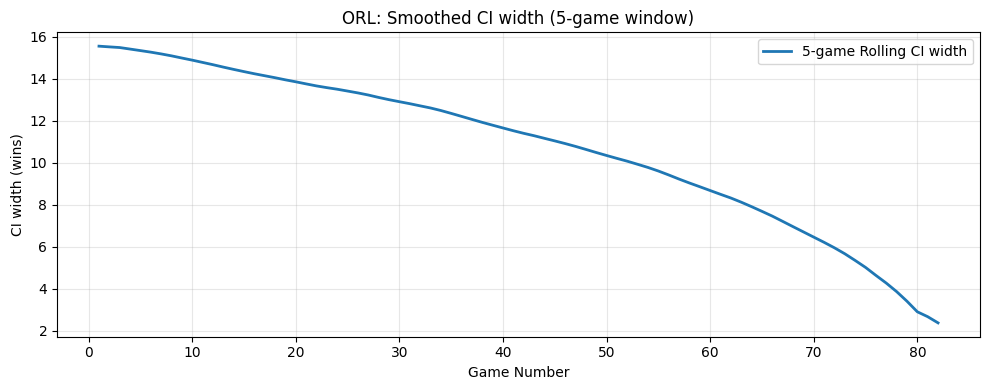

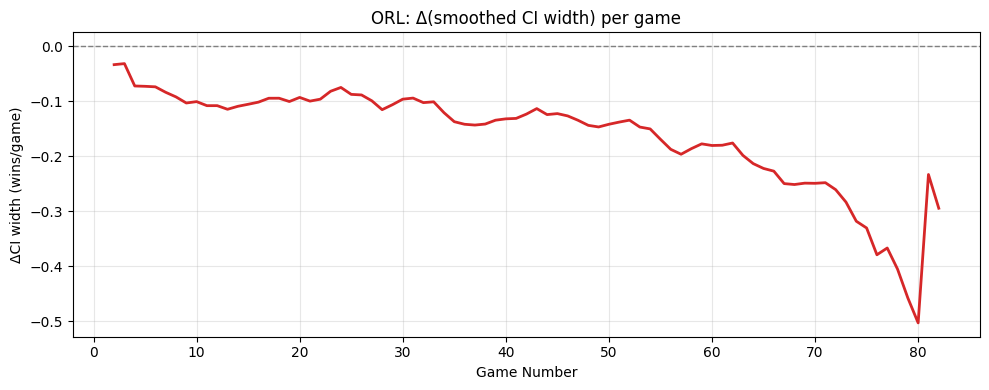

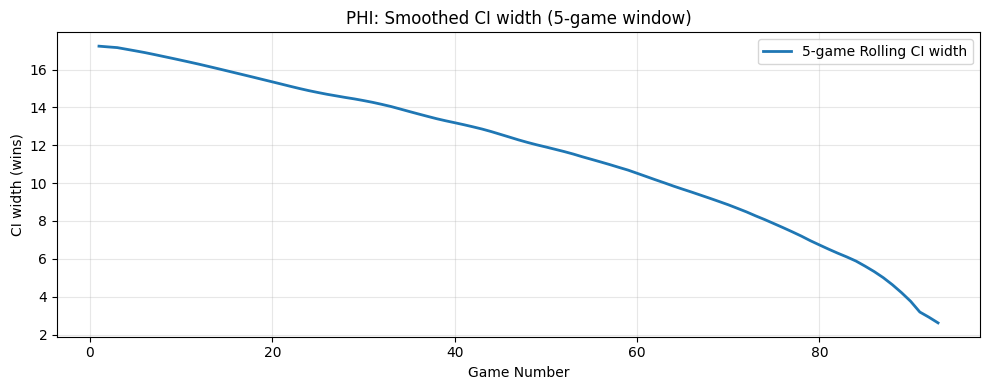

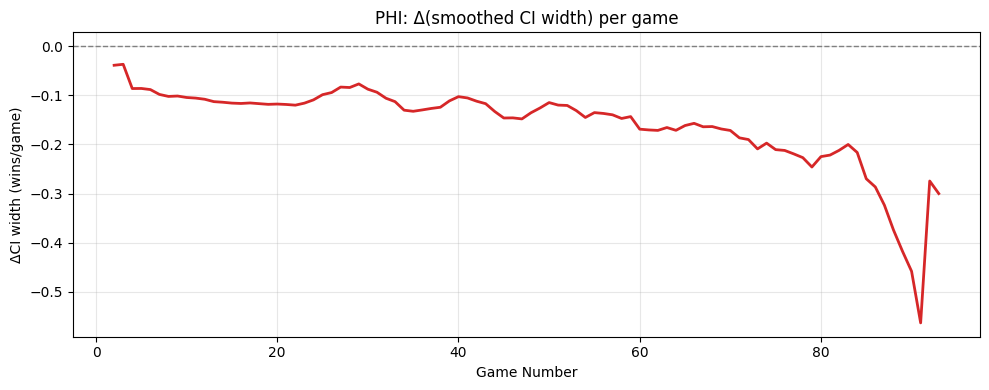

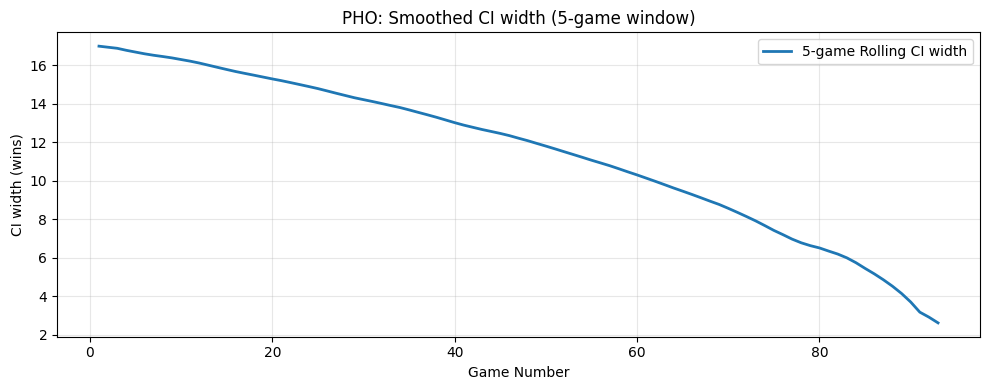

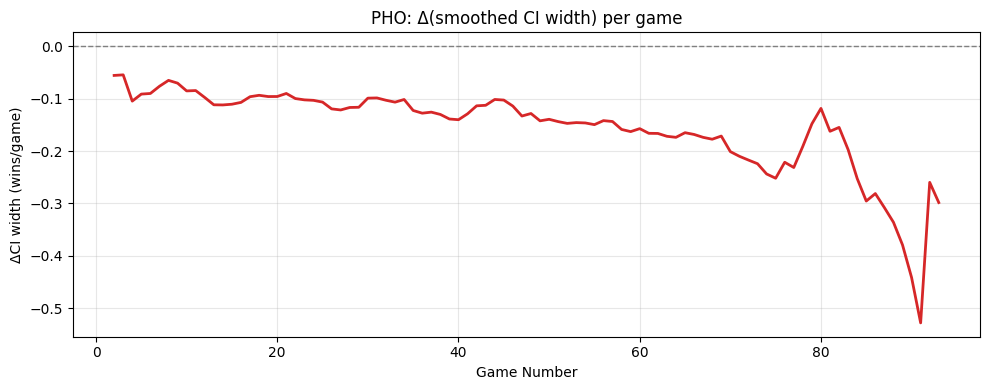

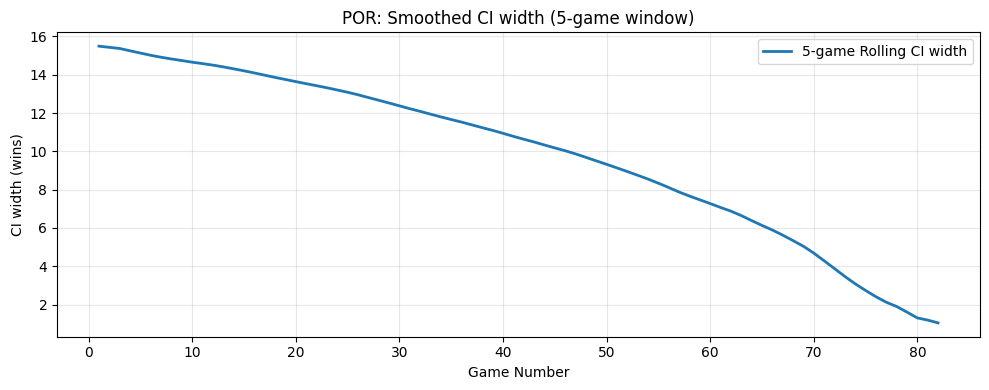

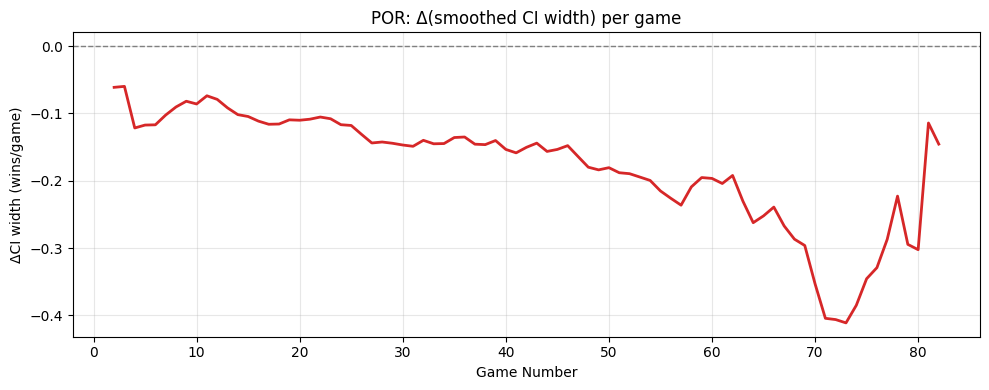

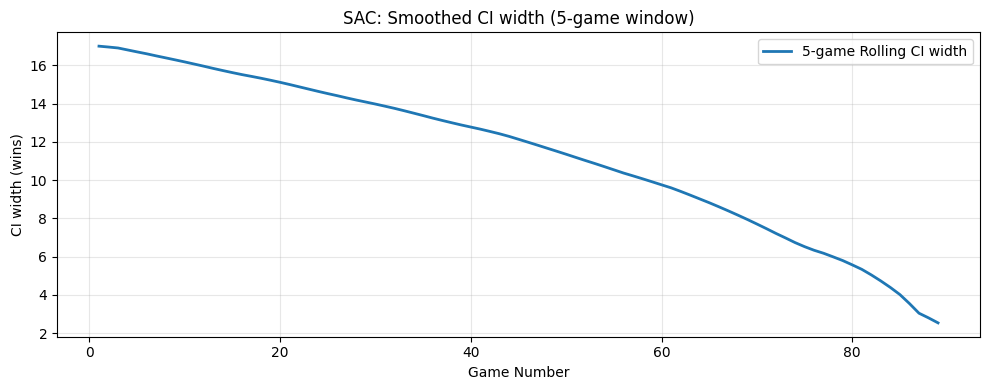

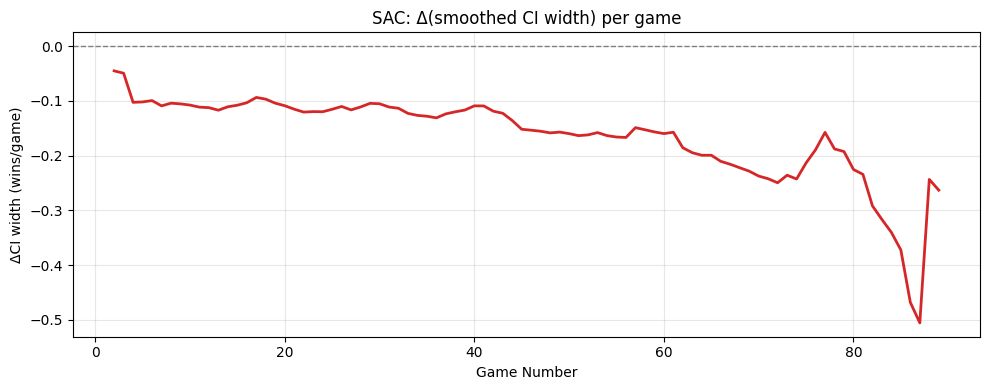

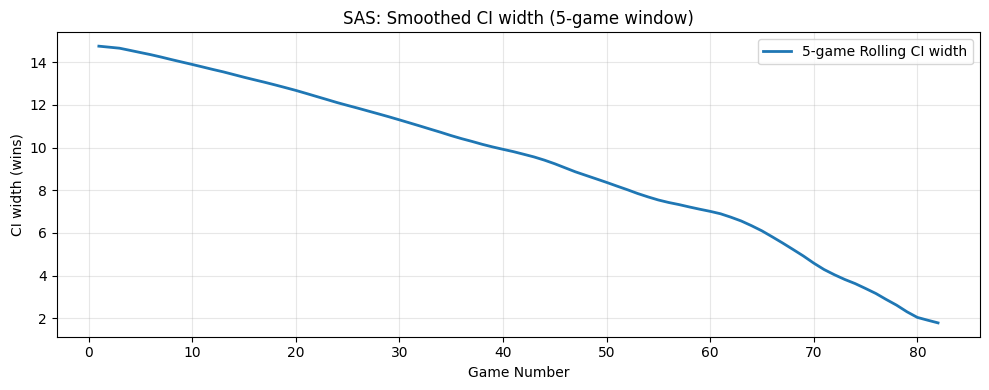

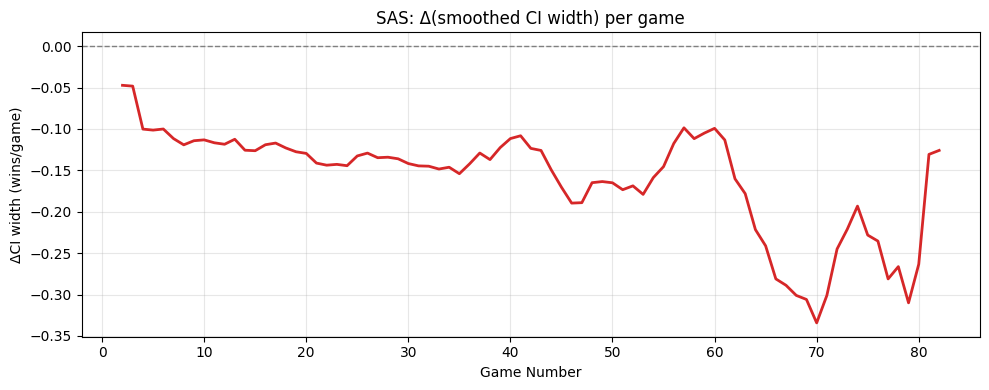

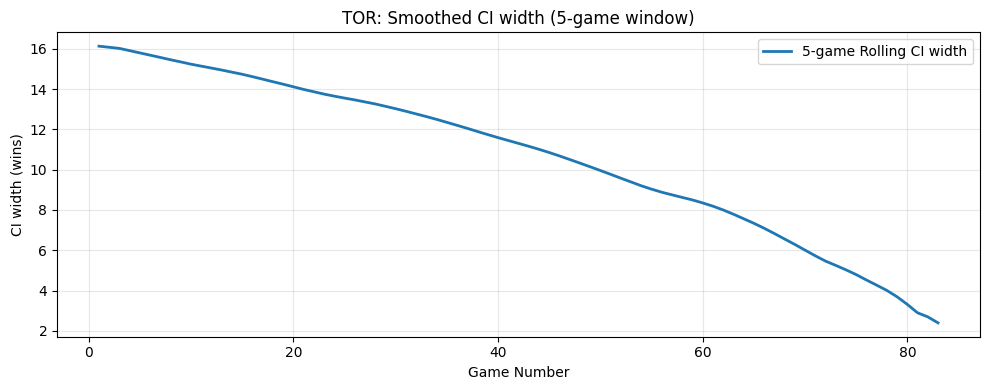

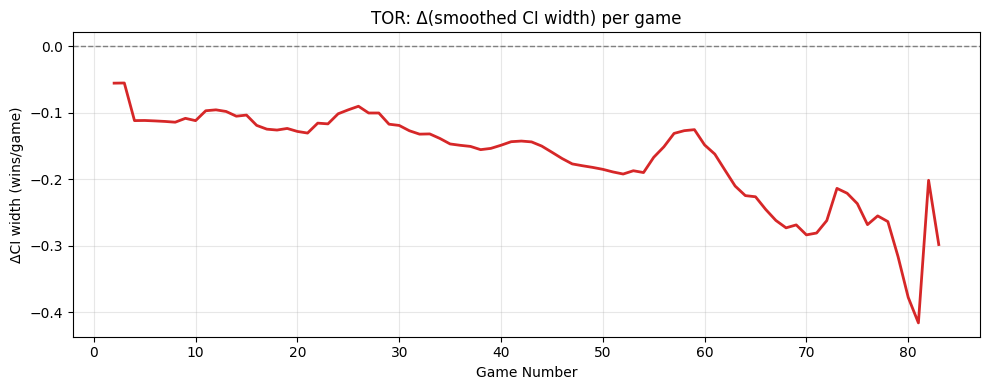

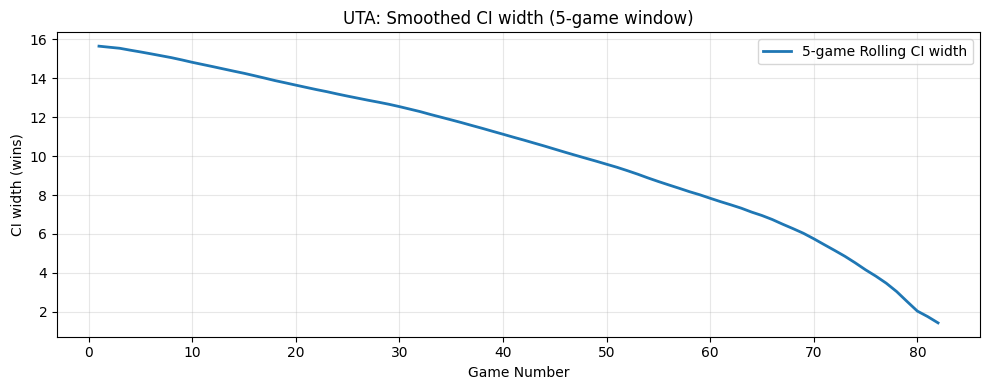

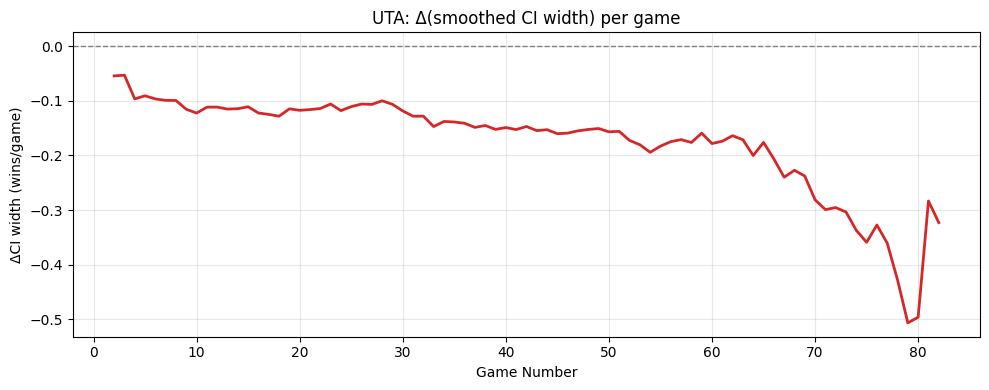

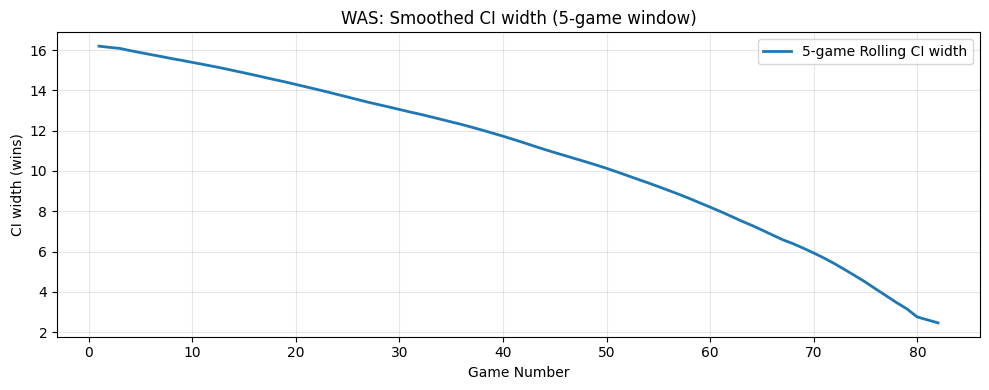

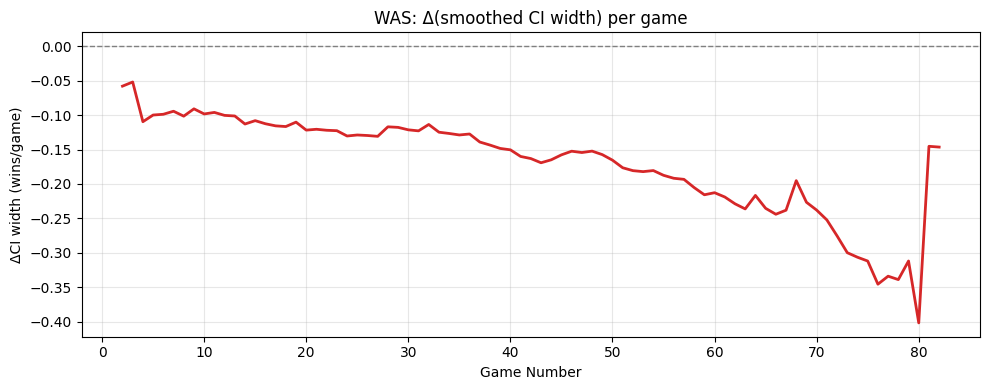

In [23]:
# choose your smoothing window (in games)
window = 5

for team in sorted(flat['team'].unique()):
    ts = build_ts(team)                     # gives you ['date','ci_width',...]
    ts = ts.reset_index(drop=True)
    ts['game_num'] = ts.index + 1

    # 1) smooth the raw CI width
    ts['ci_smooth'] = ts['ci_width'].rolling(
        window=window, center=True, min_periods=1
    ).mean()

    # 2) slope per game of the smoothed series
    ts['slope_smooth'] = ts['ci_smooth'].diff()

    # 3) plot the smoothed CI width
    plt.figure(figsize=(10,4))
    plt.plot(ts['game_num'], ts['ci_smooth'], lw=2, label=f'{window}-game Rolling CI width')
    plt.title(f'{team}: Smoothed CI width ({window}-game window)')
    plt.xlabel('Game Number'); plt.ylabel('CI width (wins)')
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    # 4) plot its slope
    plt.figure(figsize=(10,4))
    plt.plot(ts['game_num'], ts['slope_smooth'], lw=2, color='C3')
    plt.axhline(0, color='gray', lw=1, linestyle='--')
    plt.title(f'{team}: Δ(smoothed CI width) per game')
    plt.xlabel('Game Number'); plt.ylabel('ΔCI width (wins/game)')
    plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


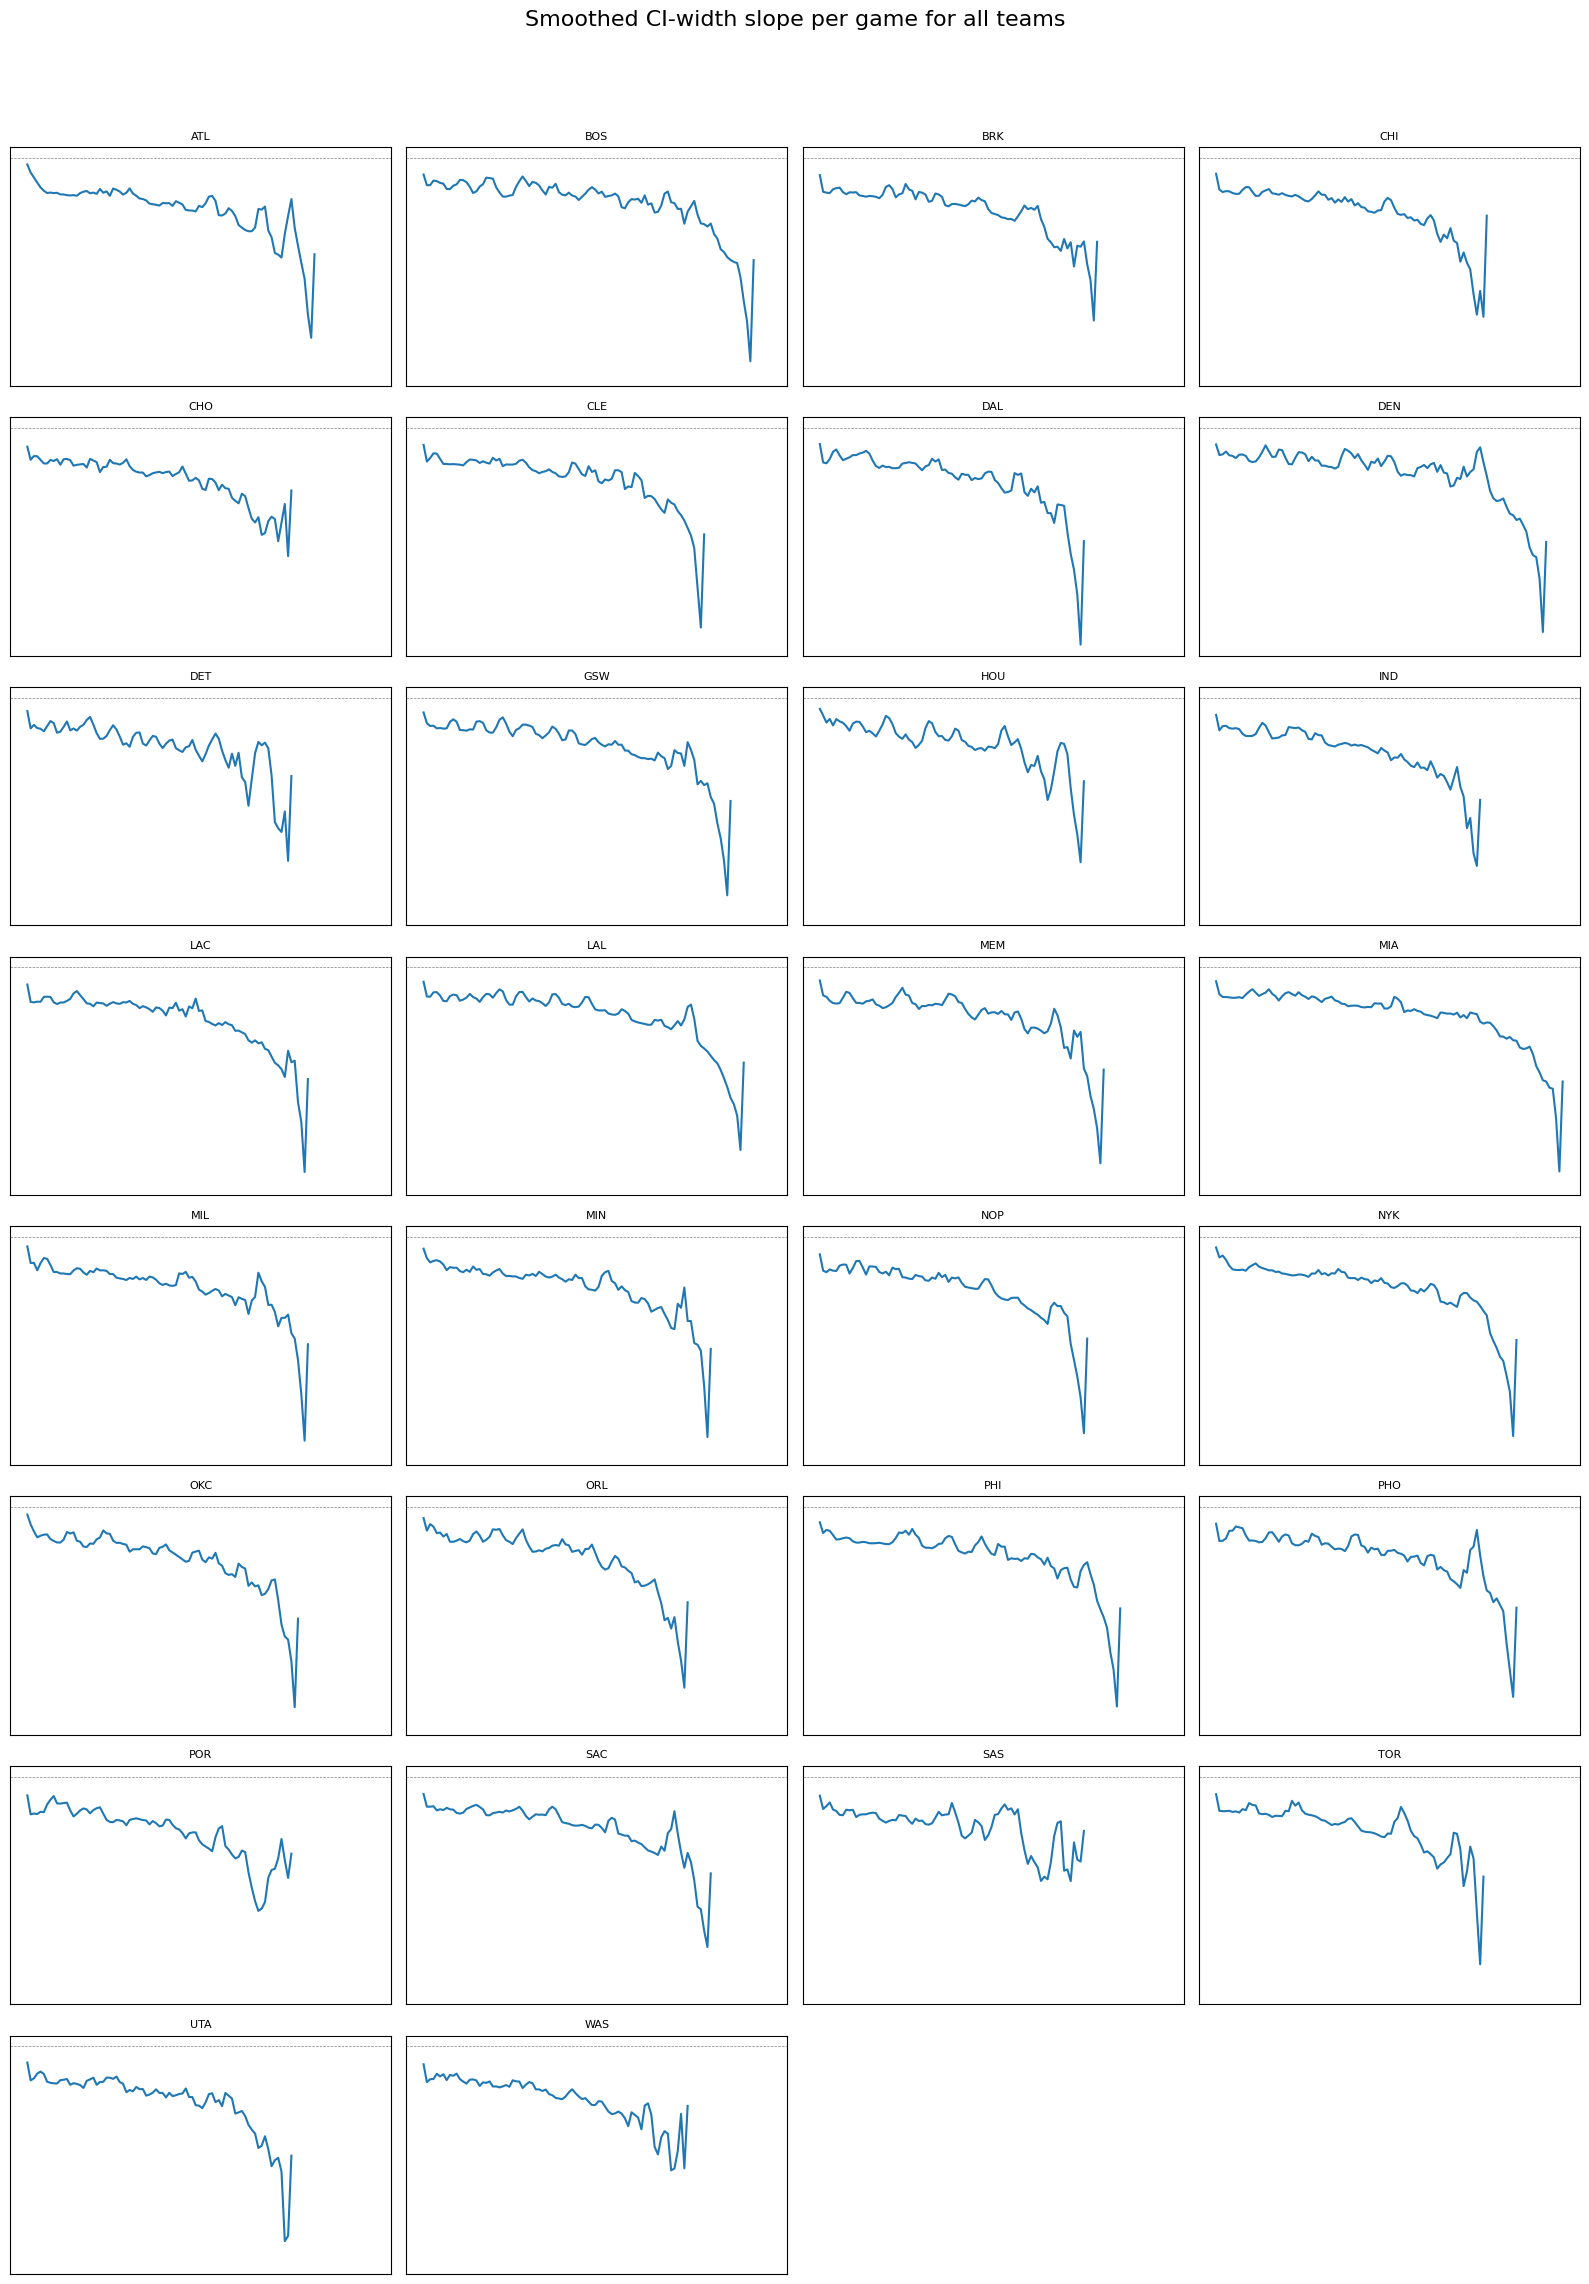

In [25]:
import math
import matplotlib.pyplot as plt

teams = sorted(flat['team'].unique())
n   = len(teams)
cols = 4                       # how many columns wide
rows = math.ceil(n / cols)     # auto-compute rows

fig, axes = plt.subplots(rows, cols,
                         figsize=(cols*4, rows*3),
                         sharex=True, sharey=True)
axes = axes.flatten()

for ax, team in zip(axes, teams):
    ts = build_ts(team).reset_index(drop=True)
    ts['game_num']    = range(len(ts))
    ts['ci_smooth']   = ts['ci_width'].rolling(3, center=True, min_periods=1).mean()
    ts['slope_game']  = ts['ci_smooth'].diff()

    ax.plot(ts['game_num'], ts['slope_game'], lw=1.5)
    ax.axhline(0, color='gray', lw=0.5, ls='--')
    ax.set_title(team, fontsize=8)
    ax.set_xticks([]); ax.set_yticks([])

# turn off any empty subplots
for ax in axes[n:]:
    ax.axis('off')

fig.suptitle('Smoothed CI-width slope per game for all teams', fontsize=16)
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


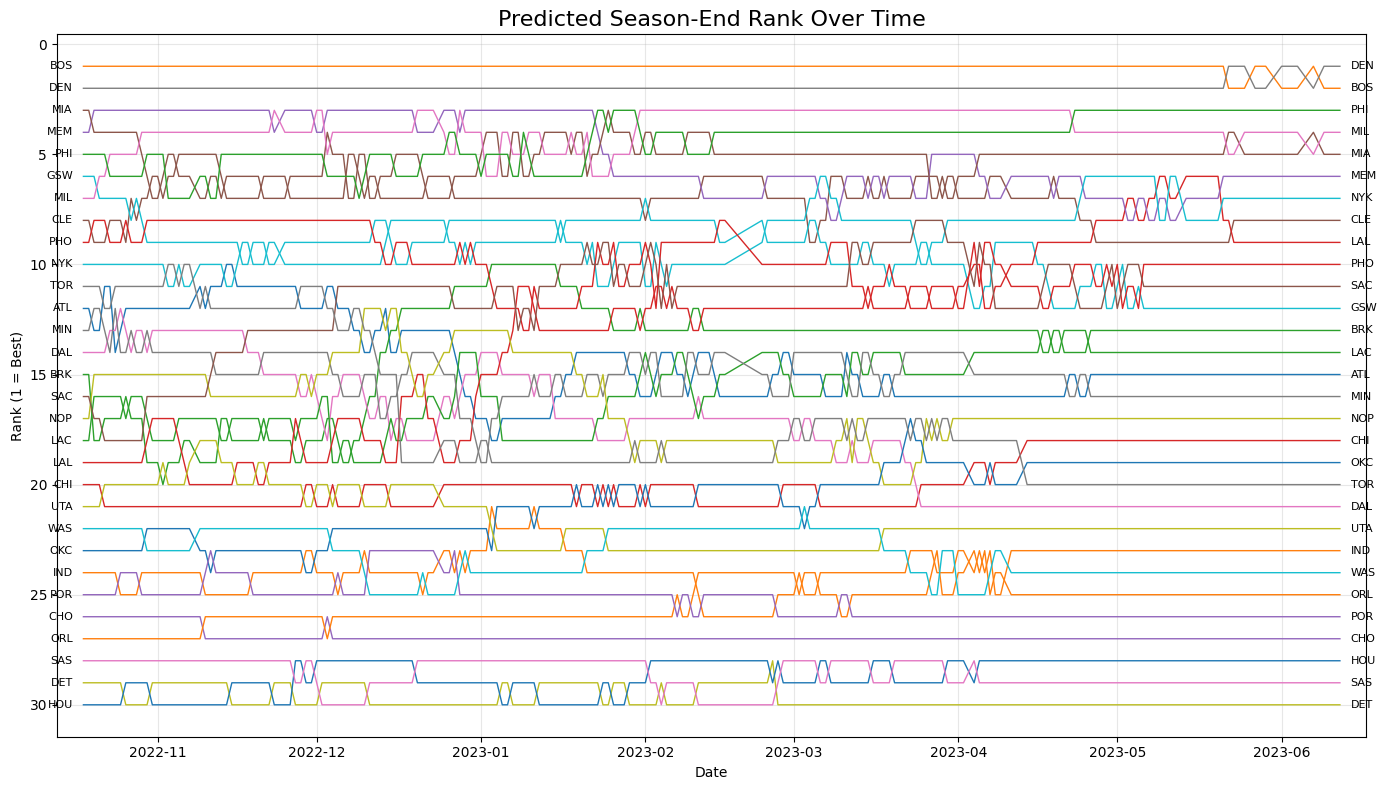

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# … assume you already have proj_df and have built rank_df as before …

# 1) Prepare figure and axes
fig, ax = plt.subplots(figsize=(14,8))

dates = rank_df.index
start, end = dates.min(), dates.max()

# 2) Expand x‐limits so there's room for labels
ax.set_xlim(start - pd.Timedelta(days=5), end + pd.Timedelta(days=5))

# 3) Plot each team and annotate start/end
for team in rank_df.columns:
    y = rank_df[team]
    ax.plot(dates, y, lw=1)

    # label at the very beginning
    ax.text(start - pd.Timedelta(days=2), y.iloc[0], team,
            ha='right', va='center', fontsize=8)

    # label at the very end
    ax.text(end + pd.Timedelta(days=2), y.iloc[-1], team,
            ha='left', va='center', fontsize=8)

# 4) Final formatting
ax.invert_yaxis()  # so rank 1 is up top
ax.set_title('Predicted Season-End Rank Over Time', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Rank (1 = Best)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
